# Учебная задача «Анализ сайта»

Компания «СберАвтоподписка» хочет увеличить эффективность сайта: улучшить пользовательский опыт, повысить конверсию, сделать рекламные кампании более результативными. Для этого вам предстоит **создать модель, которая предсказывает вероятность того, что пользователь совершит целевое действие (оставит заявку, закажет звонок и пр.) на сайте**.

Эта модель поможет:
- Оценивать эффективность каналов привлечения трафика;
- Адаптировать рекламные кампании;
- Улучшать UX сайта за счет анализа поведения пользователей.

# EDA

## Импортируем необходимые библиотеки и напишем функции

In [1]:
import numpy as np
import pandas as pd

from itertools import combinations
from tqdm import tqdm 

from scipy.stats import chi2_contingency, spearmanr, kendalltau
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt
# настройка визуализации
%matplotlib inline
plt.style.use('seaborn-v0_8')
%config InlineBackend.figure_format = "retina"

In [2]:
def analyze_categorical_feature(df, feature, target, plot=True, figsize=(15, 6)):
    """
    Функция анализирует связь категориального признака с бинарным таргетом (0/1).
    Для этого используется тест Xi-квадрат и рассчитывается коэффициент Крамера V.
    Данные сводятся в таблицу и выводятся диаграммы.
    
    Параметры:
    - df: DataFrame с данными
    - feature: имя категориального признака (может быть строковым или числовым)
    - target: имя бинарного таргета (должен содержать только 0 и 1)
    - plot: флаг для построения графиков (True/False)
    - figsize: размер выходных графиков
    
    Возвращает:
    - DataFrame с аналитической отчетностью
    """
    
    # ======================
    # 1. ПРОВЕРКА ДАННЫХ
    # ======================
    
    # Проверка наличия указанных колонок в DataFrame
    if feature not in df.columns or target not in df.columns:
        raise ValueError("Указанные колонки отсутствуют в DataFrame")
    
    # Проверка что таргет содержит только 0 и 1
    unique_targets = df[target].dropna().unique()
    if set(unique_targets) != {0, 1}:
        raise ValueError(f"Таргет должен содержать только 0 и 1. Найдены значения: {unique_targets}")

    # ======================
    # 2. ПОДГОТОВКА ДАННЫХ
    # ======================
    
    # Создаем копию данных только с нужными колонками и удаляем пропуски
    analysis_df = df[[feature, target]].copy().dropna()
    
    # Преобразуем категориальный признак в строковый тип для единообразия
    #analysis_df[feature] = analysis_df[feature].astype(str)
    
    # ======================
    # 3. СТАТИСТИЧЕСКИЙ АНАЛИЗ
    # ======================
    
    # Создаем кросс-таблицы:
    # - cross_tab: абсолютные частоты
    cross_tab = pd.crosstab(analysis_df[feature], analysis_df[target], margins=True)
    # - cross_tab_pct: относительные частоты в процентах
    cross_tab_pct = pd.crosstab(analysis_df[feature], analysis_df[target], normalize='index') * 100
    
    # Вычисляем статистическую значимость связи (хи-квадрат тест)
    chi2, p_val, _, _ = chi2_contingency(pd.crosstab(analysis_df[feature], analysis_df[target]))
    
    # Рассчитываем коэффициент Крамера V для оценки силы связи (0-1)
    cramers_v = np.sqrt(chi2 / (len(analysis_df) * (min(cross_tab.shape) - 1)))
    
    # ======================
    # 4. ФОРМИРОВАНИЕ ОТЧЕТА
    # ======================
    
    # Удаление строки All
    if 'All' in cross_tab.index:
        cross_tab = cross_tab.drop('All')
    if 'All' in cross_tab_pct.index:
        cross_tab_pct = cross_tab_pct.drop('All')
    
    # Создаем отчетный DataFrame
    report = pd.DataFrame({
        'Общее_количество': cross_tab['All'] if 'All' in cross_tab.columns else cross_tab.sum(axis=1),
        'Доля_от_общего_%': (cross_tab['All'] / len(analysis_df) * 100).round(2) if 'All' in cross_tab.columns 
                         else (cross_tab.sum(axis=1) / len(analysis_df) * 100).round(2),
        'Частота_0': cross_tab[0],
        'Частота_1': cross_tab[1],
        'Доля_класса_1_%': cross_tab_pct[1].round(2)
    }).sort_values('Доля_класса_1_%', ascending=False)
    
    # ======================
    # 5. ВЫВОД РЕЗУЛЬТАТОВ
    # ======================
    
    print(f"\n📊 Анализ признака '{feature}' (уникальных значений: {len(report)}):")
    print(f"► Тест хи-квадрат: p-value = {p_val:.4f} {'(значимо)' if p_val < 0.05 else '(не значимо)'}")
    print(f"► Коэф. Крамера V (сила связи): {cramers_v:.3f}")
    print("\n📈 Распределение таргета по категориям (по убыванию доли класса 1):")
    display(report)
    
    # ======================
    # 6. ВИЗУАЛИЗАЦИЯ
    # ======================
    
    if plot and len(report) > 1:  # Строим графики только если есть что показывать
        plt.figure(figsize=figsize)
        
        # График 1: Доля класса 1 по категориям (столбчатая диаграмма)
        plt.subplot(1, 2, 1)
        ax = sns.barplot(
            data=report.reset_index(),
            x=feature,
            y='Доля_класса_1_%',
            hue=feature,
            palette='viridis',
            dodge=False,
            legend=False
        )
        plt.title(f'Доля класса 1 по категориям {feature}\n(p-value: {p_val:.4f})')
        plt.xticks(rotation=45, ha='right')
        plt.ylabel('Доля класса 1, %')
        plt.ylim(0, 100)
        
        # Добавляем подписи значений на столбцы
        for p in ax.patches:
            ax.annotate(f"{p.get_height():.1f}%", 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha='center', va='center', 
                       xytext=(0, 5), 
                       textcoords='offset points')
        
        # График 2: Распределение категорий (круговая диаграмма)
        plt.subplot(1, 2, 2)

        # Сортируем данные по убыванию количества
        sorted_report = report.sort_values('Общее_количество', ascending=False)
        wedges, _, _ = plt.pie(
            sorted_report['Общее_количество'],
            autopct=lambda p: f'{p:.1f}%' if p > 5 else '',  # Проценты только для долей >5%
            startangle=90,
            pctdistance=0.85,  # Отодвигаем проценты ближе к краю
            textprops={'fontsize': 10, 'color': 'black'},
            wedgeprops={'width': 0.4}  # Для donut-эффекта 
        )

        # Создаем легенду с категориями и значениями (уже отсортированную)
        legend_labels = [f'{label} ({value})' for label, value in 
                        zip(sorted_report.index, sorted_report['Общее_количество'])]

        plt.legend(wedges, legend_labels,
                title="Категории (по убыванию)",
                loc="center left",
                bbox_to_anchor=(1, 0, 0.5, 1),
                fontsize=10)

        plt.title(f'Распределение категорий {feature}\n(отсортировано по количеству)')
        plt.ylabel('')

        plt.tight_layout()
        plt.show()
    
    return report

In [3]:
def analyze_numeric_feature(df, feature, target, plot=True, figsize=(15, 6)):
    """
    Анализирует непрерывный числовой признак в разрезе бинарного таргета (0/1).
    
    Параметры:
    - df: DataFrame с данными
    - feature: имя числового признака
    - target: имя бинарного таргета (0/1)
    - plot: строить ли графики
    - figsize: размер графиков
    
    Возвращает:
    - DataFrame с аналитической отчетностью
    """
    
    # ======================
    # 1. ПРОВЕРКА ДАННЫХ
    # ======================
    if feature not in df.columns or target not in df.columns:
        raise ValueError("Указанные колонки отсутствуют в DataFrame")
    
    if set(df[target].dropna().unique()) != {0, 1}:
        raise ValueError("Таргет должен содержать только 0 и 1")
    
    # ======================
    # 2. ПОДГОТОВКА ДАННЫХ
    # ======================
    analysis_df = df[[feature, target]].copy().dropna()
    class_0 = analysis_df[analysis_df[target] == 0][feature]
    class_1 = analysis_df[analysis_df[target] == 1][feature]
    
    # ======================
    # 3. СТАТИСТИЧЕСКИЙ АНАЛИЗ
    # ======================
    # Основные статистики
    stats_report = pd.DataFrame({
        'Класс 0': class_0.describe(),
        'Класс 1': class_1.describe()
    }).T
    
    # Дополнительные метрики
    effect_size = class_1.mean() - class_0.mean()
    _, p_value = stats.ttest_ind(class_0, class_1, equal_var=False) # t-тест Уэлча
    cohens_d = effect_size / np.sqrt((class_0.std()**2 + class_1.std()**2)/2) # размер эффекта
    
    # ======================
    # 4. ФОРМИРОВАНИЕ ОТЧЕТА
    # ======================
    print(f"\n📊 Анализ признака '{feature}':")
    print(f"► Размер эффекта (разность средних): {effect_size:.4f}")
    print(f"► t-тест Уэлча: p-value = {p_value:.4f} {'(значимо)' if p_value < 0.05 else '(не значимо)'}")
    print(f"► Коэф. Коэна d: {cohens_d:.3f} {'(малый)' if abs(cohens_d) < 0.5 else '(средний/большой)'}")
    print("\n📈 Основные статистики:")
    display(stats_report)
    
    # ======================
    # 5. ВИЗУАЛИЗАЦИЯ
    # ======================
    if plot:
        plt.figure(figsize=figsize)
        
        # График 1: Распределения по классам
        plt.subplot(1, 2, 1)
        sns.kdeplot(data=analysis_df, x=feature, hue=target, 
                   palette={0: 'blue', 1: 'orange'}, 
                   fill=True, alpha=0.3, common_norm=False)
        plt.title(f'Распределение {feature} по классам')
        plt.xlabel(feature)
        plt.ylabel('Плотность')
        plt.legend(title='Класс', labels=['0', '1'])
        
        # График 2: Boxplot по классам (исправленная версия)
        plt.subplot(1, 2, 2)
        sns.boxplot(
            data=analysis_df, 
            x=target, 
            y=feature, 
            hue=target,  # Добавлено для устранения предупреждения
            palette={0: 'blue', 1: 'orange'},
            legend=False  # Отключаем дублирующую легенду
        )
        plt.title(f'Boxplot {feature} по классам')
        plt.xlabel('Класс')
        plt.ylabel(feature)
        plt.xticks([0, 1], ['Класс 0', 'Класс 1'])
        
        plt.tight_layout()
        plt.show()
    
    return stats_report


## Загрузка датасета

In [4]:
df = pd.read_csv('data/dataset.csv')
df

event_categories_number  hit_number_median  target top_car_brand  \
0                             10                9.5   False          none   
1                              6                7.5   False          none   
2                             11               10.0   False      lada-vaz   
3                             12               10.5   False          none   
4                              1                3.0   False          none   
...                          ...                ...     ...           ...   
1731851                        1                3.0   False          none   
1731852                        2                3.5   False          none   
1731853                       12               12.0   False          none   
1731854                        4                5.5   False          none   
1731855                        1                3.0   False          none   

            client_id  visit_date visit_time  visit_number  \
0        2.328328e+08  2021-09-26   16:00:00           1.0   
1        2.328330e+08  2021-10-23   21:24:03           1.0   
2        2.328338e+08  2021-10-28   09:35:56           1.0   
3        2.328347e+08  2021-06-12   12:00:00           1.0   
4        2.328354e+08  2021-06-29   08:00:00           1.0   
...               ...         ...        ...           ...   
1731851  2.328214e+08  2021-07-21   00:00:00           1.0   
1731852  2.328227e+07  2021-07-20   23:00:00           1.0   
1731853  2.328229e+08  2021-12-02   09:58:50           1.0   
1731854  2.328280e+08  2021-06-13   06:00:00           1.0   
1731855  2.328282e+08  2021-10-15   18:00:00           1.0   

                   utm_source utm_medium device_category device_brand  \
0        MvfHsxITijuriZxsqZqt        cpm          mobile      samsung   
1        fDLlAcSmythWSCVMvqvL     banner          mobile      samsung   
2        ZpYIoDJMcFzVoPFsHGJL     banner          mobile      samsung   
3        ZpYIoDJMcFzVoPFsHGJL     banner          mobile       realme   
4        fDLlAcSmythWSCVMvqvL     banner          mobile        apple   
...                       ...        ...             ...          ...   
1731851  MvfHsxITijuriZxsqZqt        cpm          mobile       huawei   
1731852  ZpYIoDJMcFzVoPFsHGJL     banner          mobile        apple   
1731853  ZpYIoDJMcFzVoPFsHGJL     banner          mobile       xiaomi   
1731854  ZpYIoDJMcFzVoPFsHGJL     banner          mobile      samsung   
1731855  MvfHsxITijuriZxsqZqt        cpm          mobile    (not set)   

           device_browser geo_country          geo_city  screen_area  \
0                  chrome      russia        gelendzhik     358028.0   
1        samsung internet      russia          voronezh     230400.0   
2                  chrome      russia         cherkessk     348552.0   
3                  chrome      russia           irkutsk     280800.0   
4                  safari      russia            moscow     304704.0   
...                   ...         ...               ...          ...   
1731851            chrome      russia            moscow     280800.0   
1731852            safari      russia  saint petersburg     250125.0   
1731853            chrome      russia   nizhny novgorod     343089.0   
1731854  samsung internet      russia       chelyabinsk     301584.0   
1731855         yabrowser      russia  zheleznodorozhny     335256.0   

        aspect_ratio  
0            412:869  
1               9:16  
2            206:423  
3               6:13  
4               9:16  
...              ...  
1731851         6:13  
1731852      375:667  
1731853      131:291  
1731854      103:183  
1731855      229:366  

[1731856 rows x 17 columns]

In [5]:
# переведем значения таргета в 1 и 0
df['target'] = df['target'].astype(int)

In [6]:
# выведем соотношение значений таргета
df.target.value_counts(dropna=False, normalize=True).apply(lambda x: f'{x:0.2%}')

target
0    95.26%
1     4.74%
Name: proportion, dtype: object

## Признак `client_id`

In [7]:
print(f'Размер датасета = {df.shape}')
print(f'Количество уникальных client_id = {df.client_id.nunique()}')

Размер датасета = (1731856, 17)
Количество уникальных client_id = 1320512


Видно, что количество уникальных клиентов меньше, чем количество сессий. Можно было бы посчитать, используя признаки даты и времени, номер сессии для каждого клиента, однако у нас уже есть признак `visit_number`. Признак удаляем.

In [8]:
df.drop(['client_id'], axis=1, inplace=True)

## Признак `visit_number`

`visit_number` — порядковый номер визита для данного клиента 

In [9]:
df.groupby('target')['visit_number'].agg(['mean', 'median', 'count', 'std', 'min', 'max'])

mean  median    count        std  min    max
target                                                  
0       2.558982     1.0  1649729  10.879981  1.0  564.0
1       3.930425     1.0    82127  21.710837  1.0  562.0

Видно без всяких графиков, что признак содержит выбросы. В обоих классах таргета медианное количество посещений равно 1, а вот по среднему и std видно, что все же положительном классе больше повторных посещений, хотя эти посещения будут уже вероятно, в зоне выбросов.     
Для дальнейшего анализа будем использовать маску.


📊 Анализ признака 'visit_number':
► Размер эффекта (разность средних): 0.2441
► t-тест Уэлча: p-value = 0.0000 (значимо)
► Коэф. Коэна d: 0.187 (малый)

📈 Основные статистики:


count      mean       std  min  25%  50%  75%  max
Класс 0  1603004.0  1.456879  1.151992  1.0  1.0  1.0  1.0  9.0
Класс 1    78360.0  1.700944  1.444366  1.0  1.0  1.0  2.0  9.0

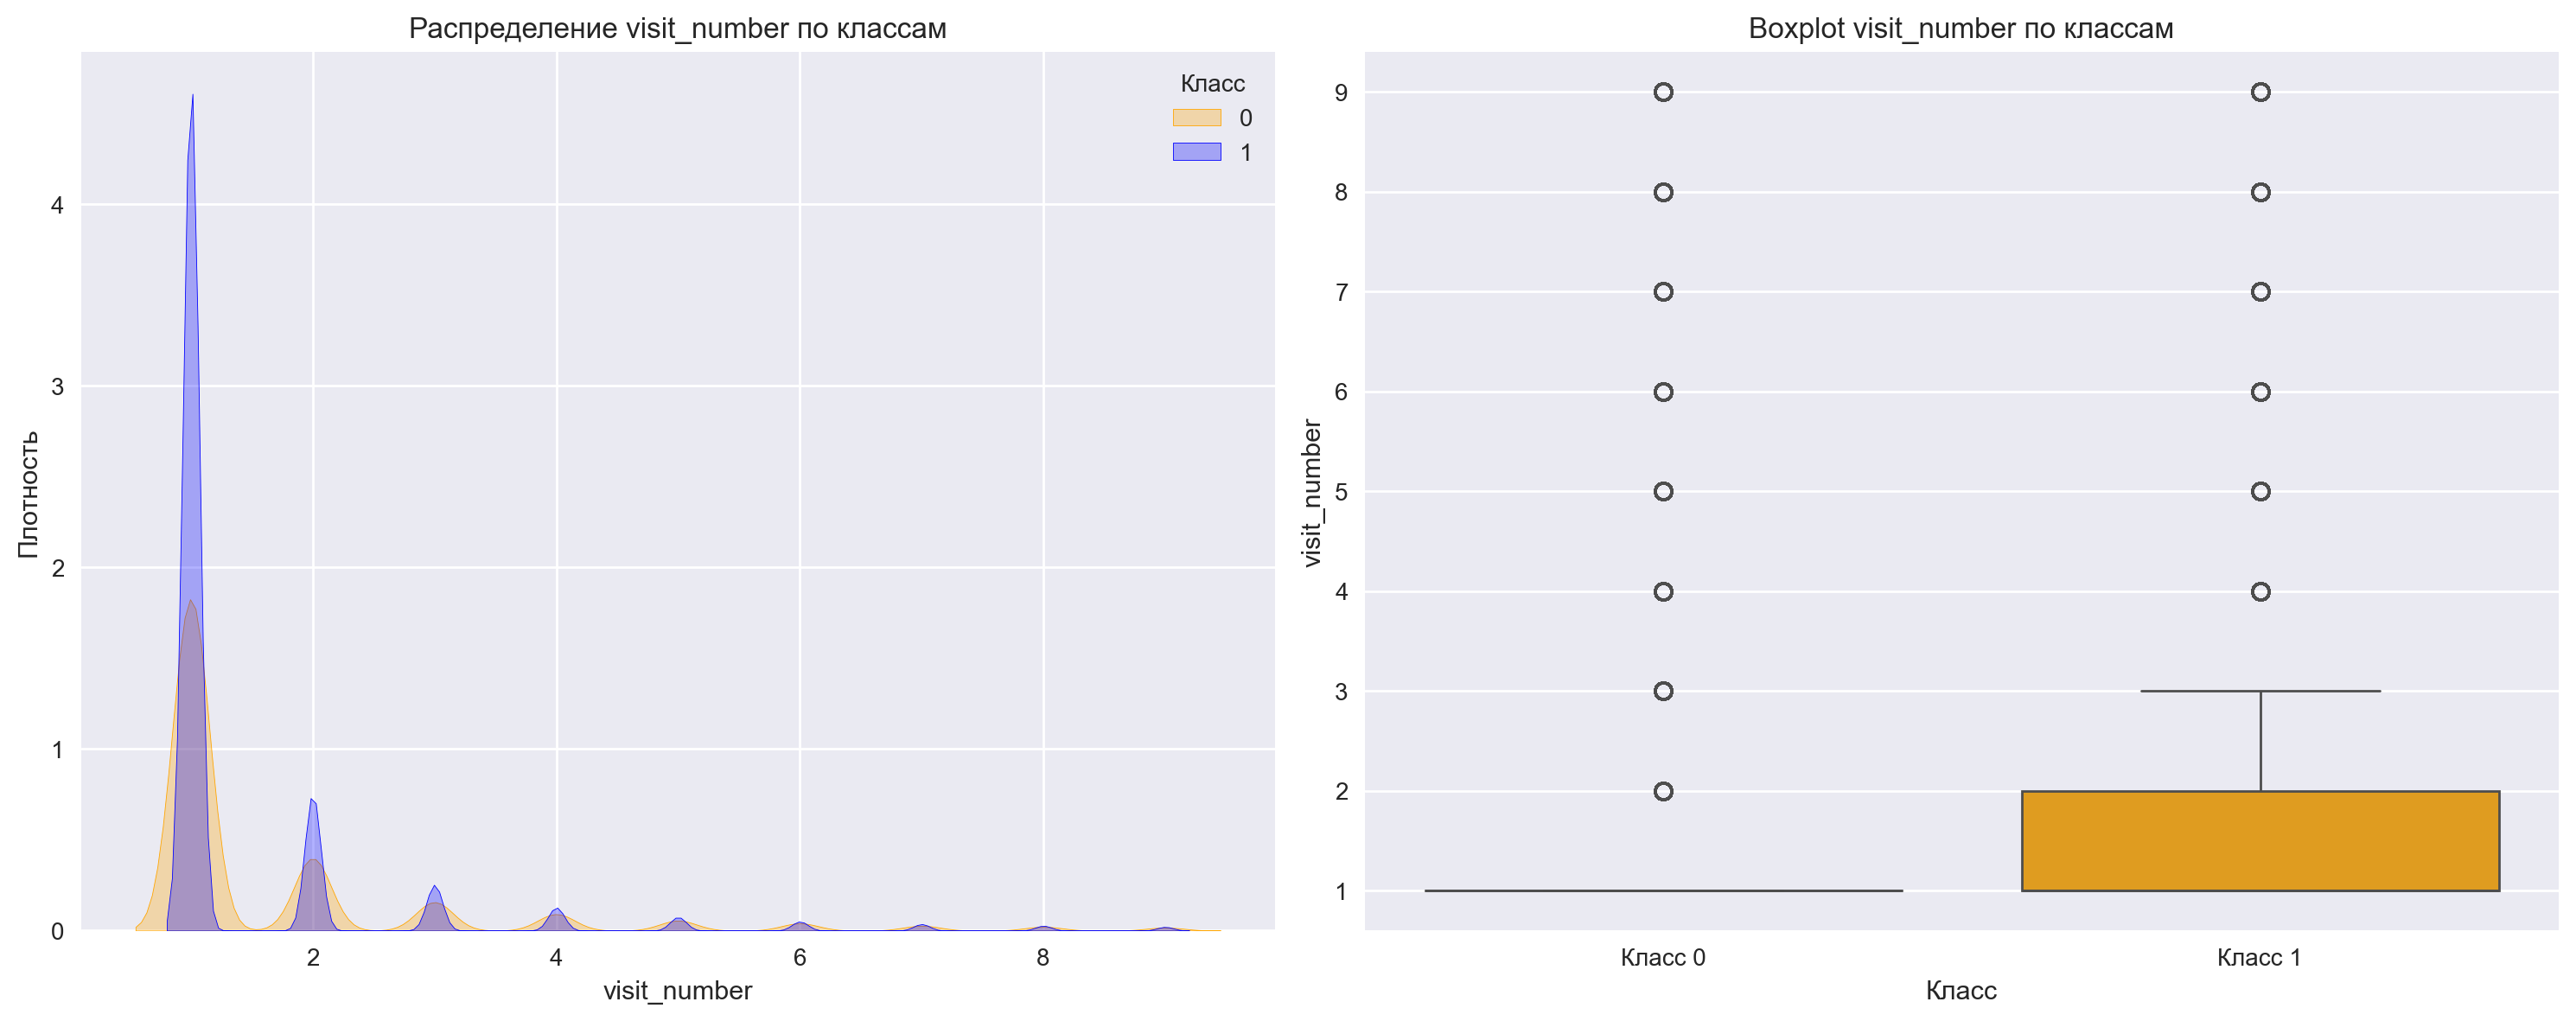

In [10]:
mask = df['visit_number'] < 10
report = analyze_numeric_feature(df[mask], 'visit_number', 'target')


📊 Анализ признака 'visit_number' (уникальных значений: 9):
► Тест хи-квадрат: p-value = 0.0000 (значимо)
► Коэф. Крамера V (сила связи): 0.033

📈 Распределение таргета по категориям (по убыванию доли класса 1):


Общее_количество  Доля_от_общего_%  Частота_0  Частота_1  \
visit_number                                                             
9.0                       5922              0.35       5425        497   
8.0                       7715              0.46       7084        631   
6.0                      14511              0.86      13325       1186   
7.0                      10330              0.61       9538        792   
5.0                      21476              1.28      19836       1640   
4.0                      36582              2.18      33879       2703   
3.0                      71806              4.27      67139       4667   
2.0                     212127             12.62     200279      11848   
1.0                    1300895             77.37    1246499      54396   

              Доля_класса_1_%  
visit_number                   
9.0                      8.39  
8.0                      8.18  
6.0                      8.17  
7.0                      7.67  
5.0                      7.64  
4.0                      7.39  
3.0                      6.50  
2.0                      5.59  
1.0                      4.18

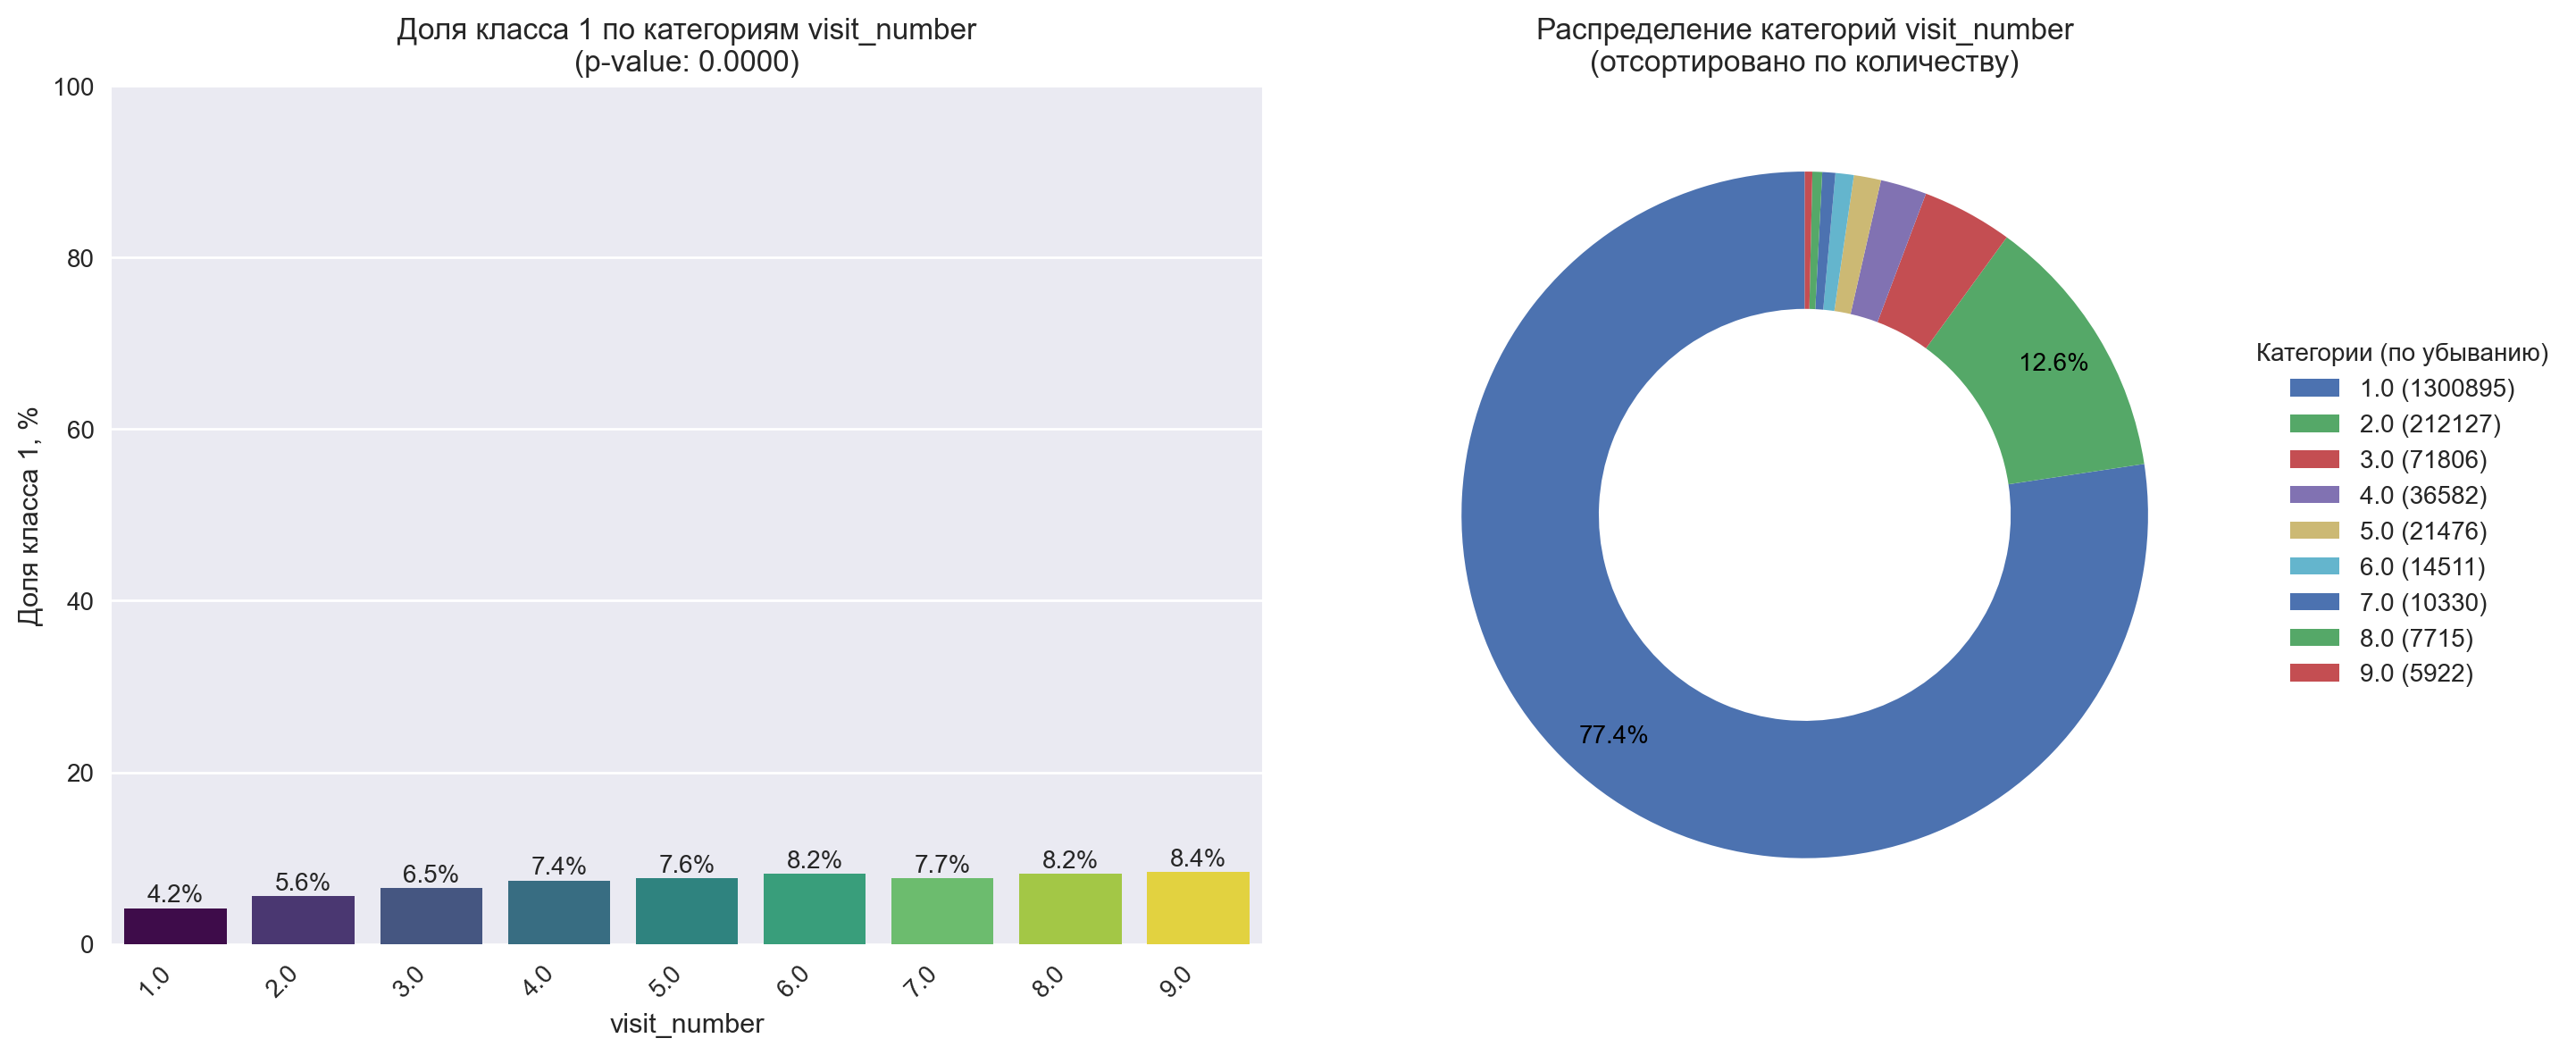

In [11]:
# проанализируем этот же признак как категориальный с той же маской
report = analyze_categorical_feature(df[mask], 'visit_number', 'target')

Чем больше по счету визит, тем выше доля целевых действий. Но больше 3 - это выбросы. Думаю более правильно перевести данный признак в категориальный, где 1-3 это номер посещения оставляем без изменений, 4 - обозначим все остальное (по сути - метка выбросов).


📊 Анализ признака 'visit_number' (уникальных значений: 4):
► Тест хи-квадрат: p-value = 0.0000 (значимо)
► Коэф. Крамера V (сила связи): 0.036

📈 Распределение таргета по категориям (по убыванию доли класса 1):


Общее_количество  Доля_от_общего_%  Частота_0  Частота_1  \
visit_number                                                             
4.0                     147028              8.49     135812      11216   
3.0                      71806              4.15      67139       4667   
2.0                     212127             12.25     200279      11848   
1.0                    1300895             75.12    1246499      54396   

              Доля_класса_1_%  
visit_number                   
4.0                      7.63  
3.0                      6.50  
2.0                      5.59  
1.0                      4.18

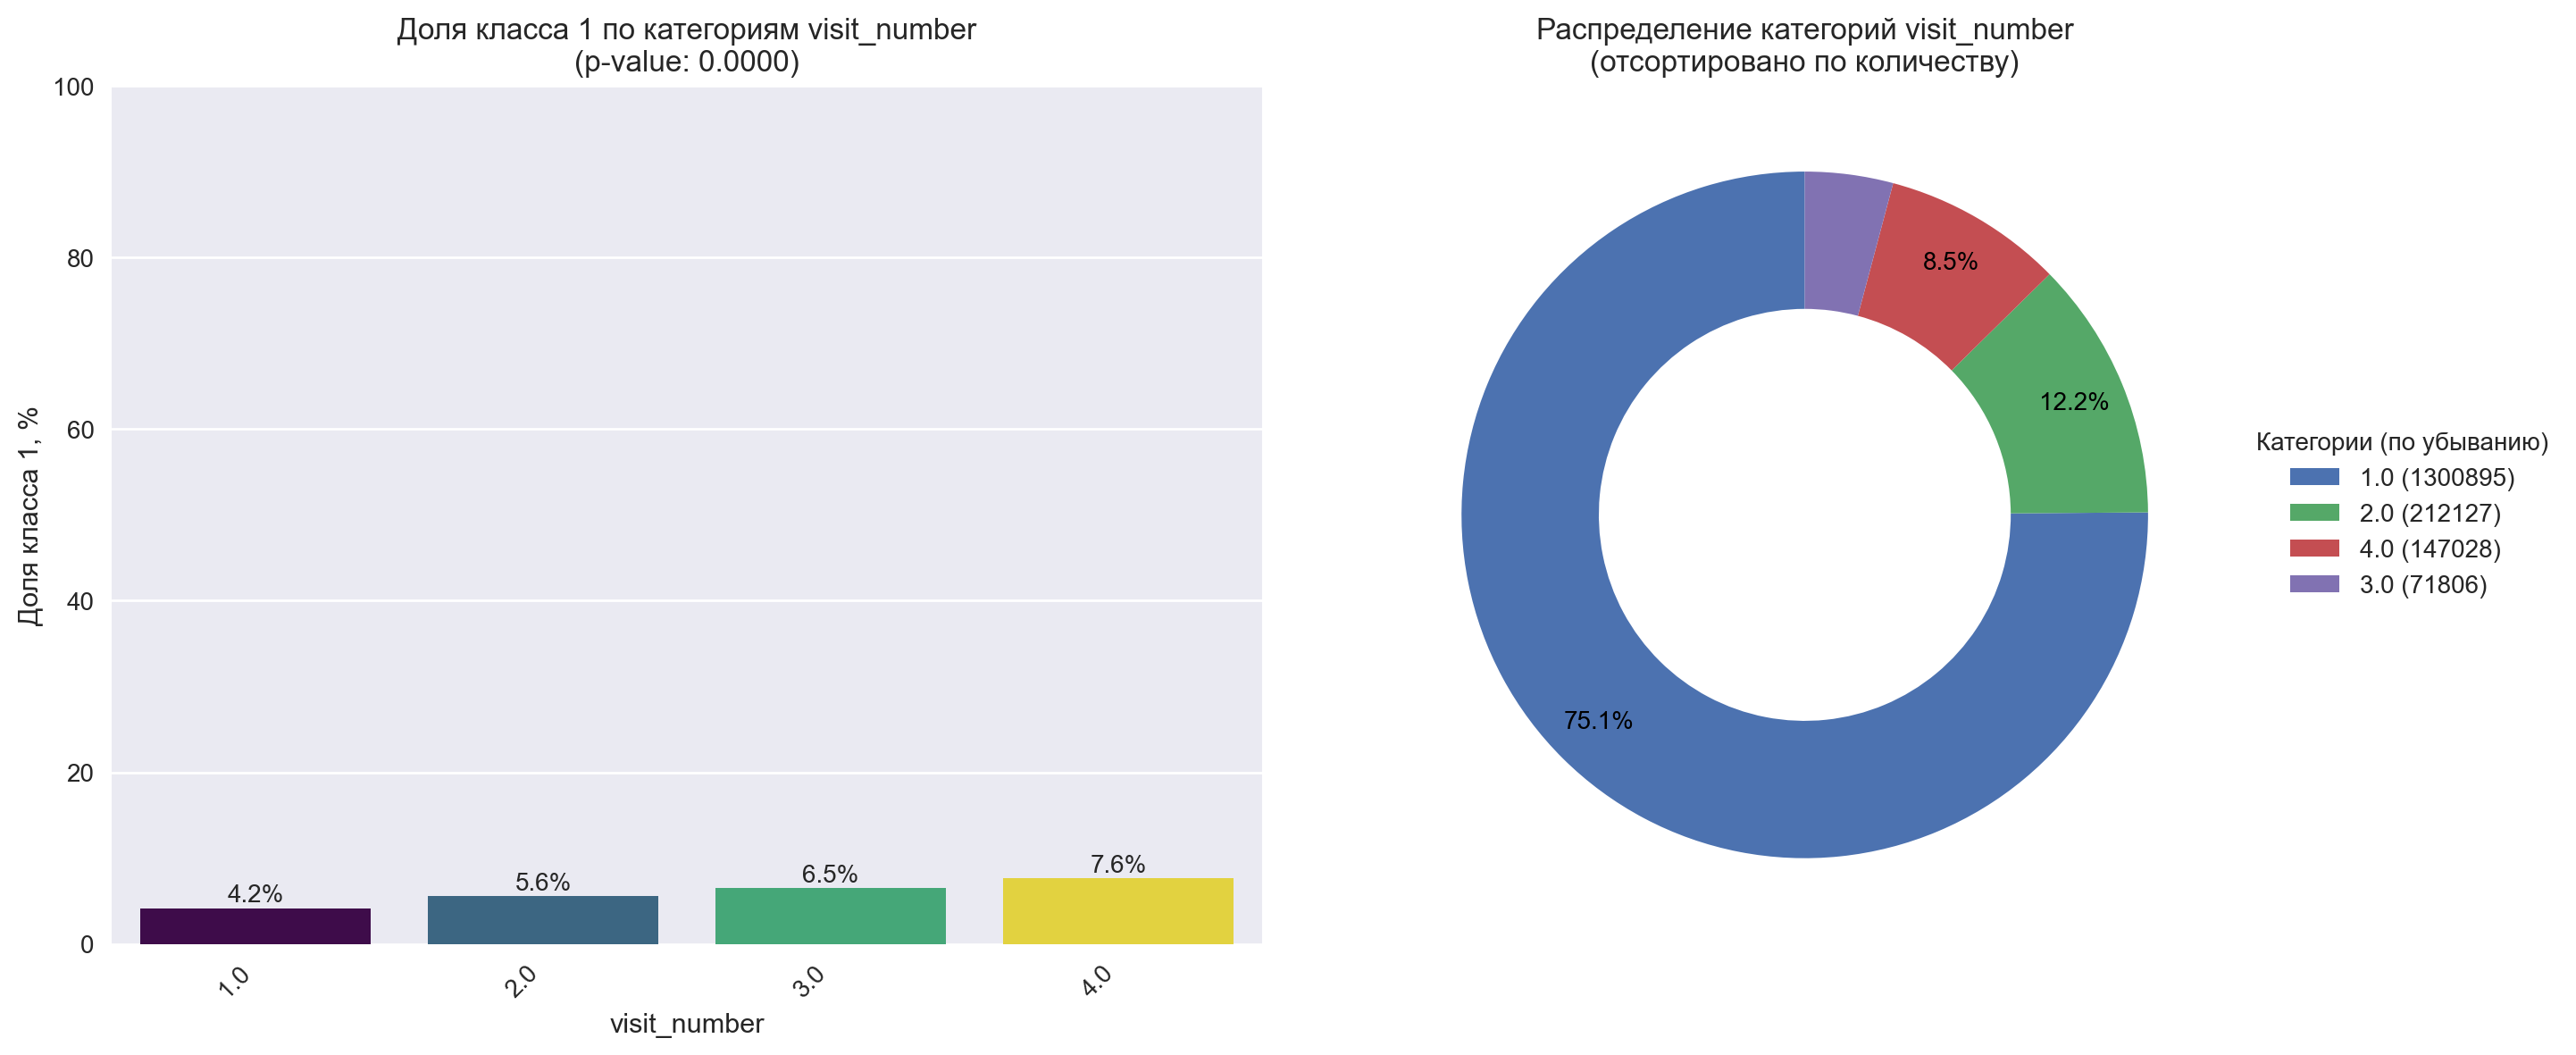

In [12]:
# переводим признак в явный категориальный
df['visit_number'] = df['visit_number'].apply(lambda x: x if x<4 else 4)

# повторный анализ
report = analyze_categorical_feature(df, 'visit_number', 'target')

Видим, что в 75% случаев это 1 визит и доля целевых действий минимальна. В остальных случаях, хоть их доля невелика, доля именно целевых действий растет.

## Признак `event_categories_number`

Это признак, полученный из признака `event_category` - тип действия. Данный признак показывает количество типов (категорий) действий, который совершил пользователь за данную сессию. 


📊 Анализ признака 'event_categories_number':
► Размер эффекта (разность средних): 15.8920
► t-тест Уэлча: p-value = 0.0000 (значимо)
► Коэф. Коэна d: 0.814 (средний/большой)

📈 Основные статистики:


count       mean        std  min  25%   50%   75%    max
Класс 0  1649729.0   8.300600  12.654463  1.0  1.0   3.0  10.0  768.0
Класс 1    82127.0  24.192568  24.529634  1.0  9.0  17.0  32.0  475.0

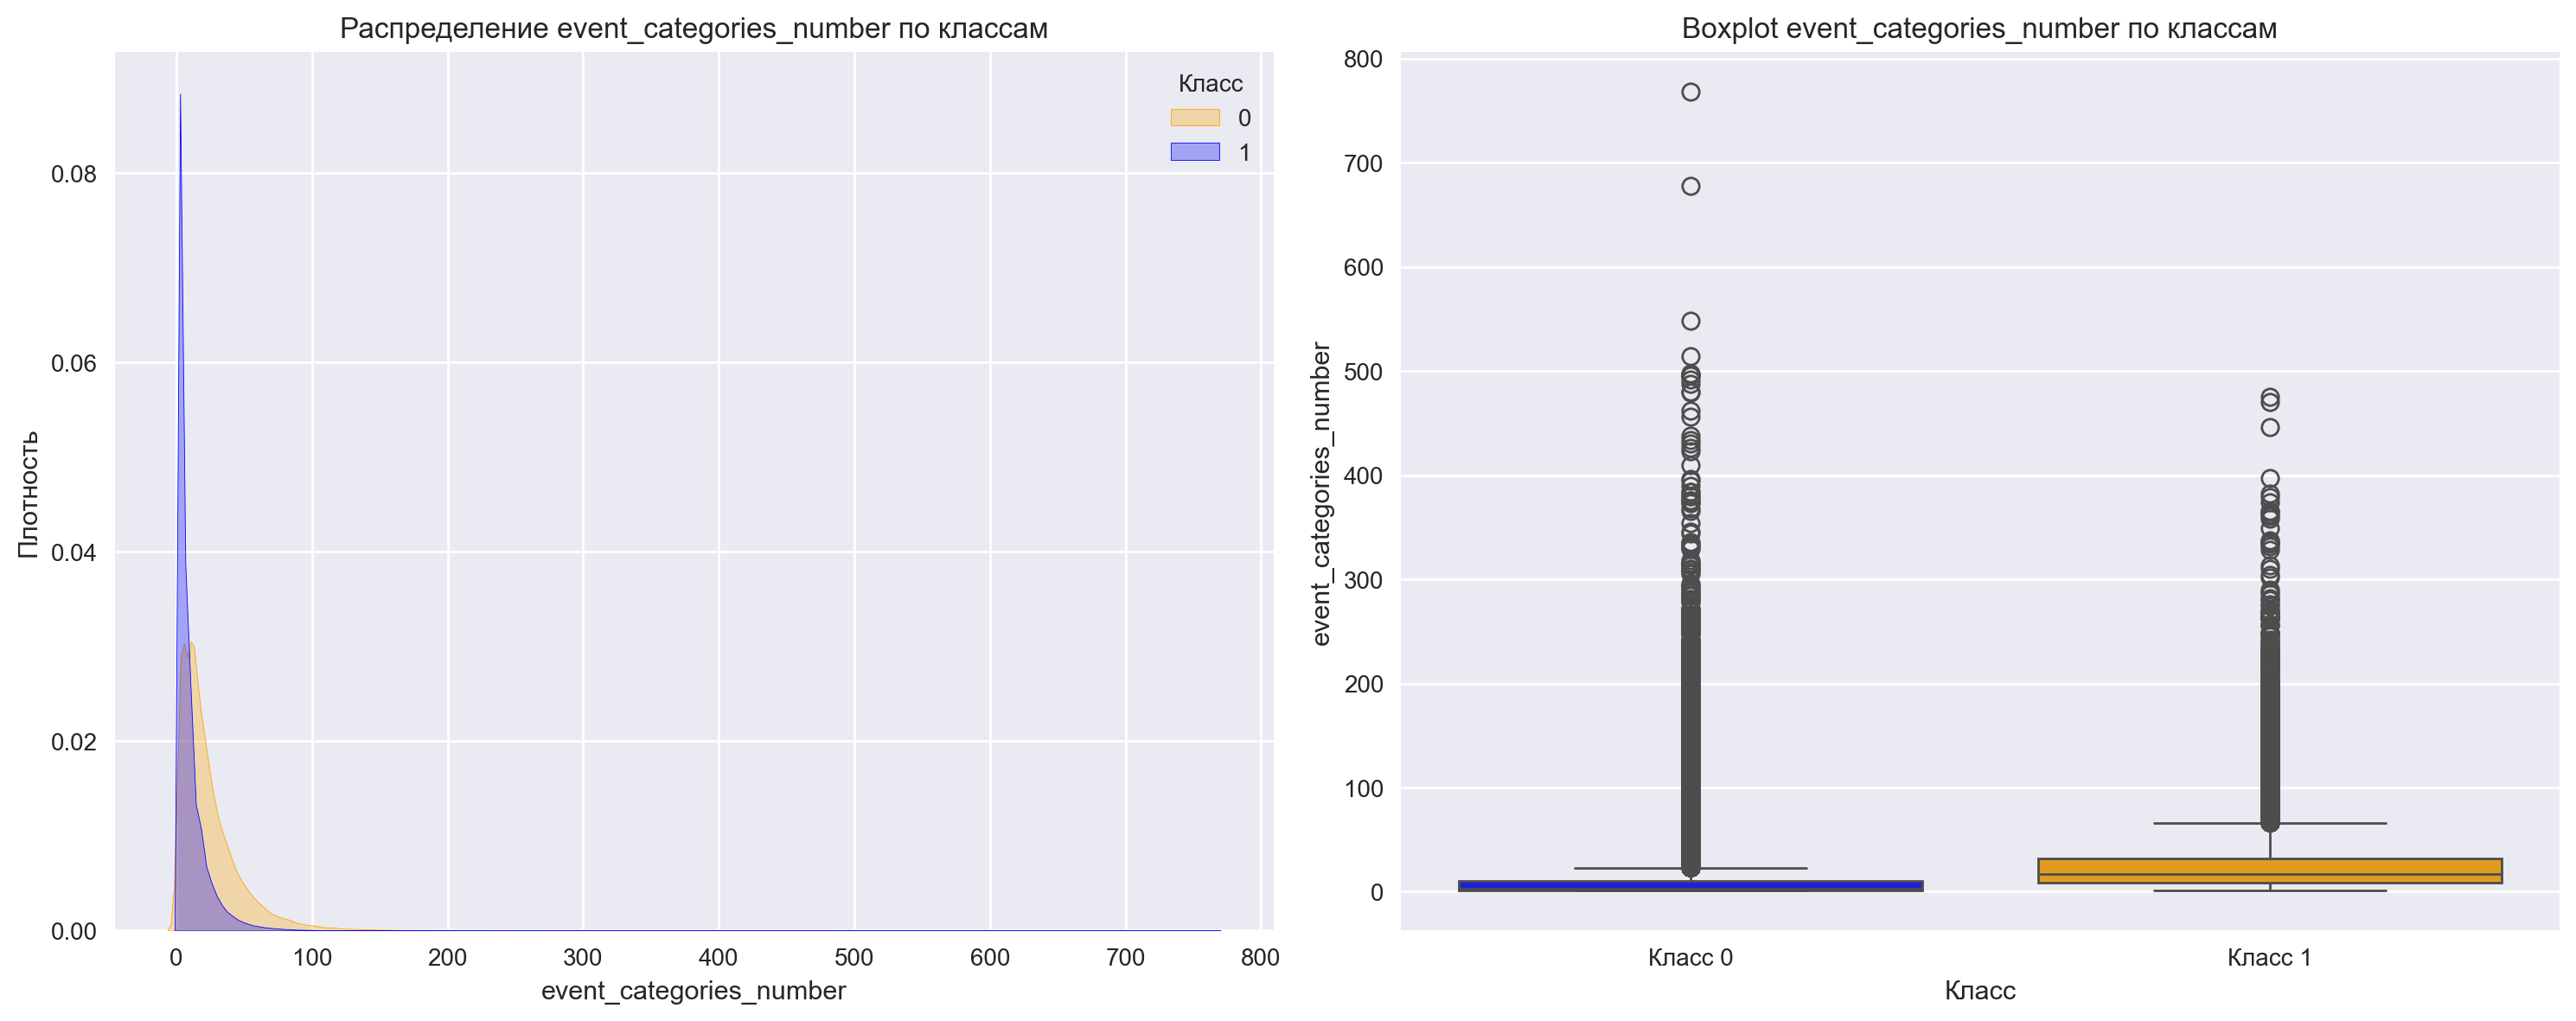

In [13]:
report = analyze_numeric_feature(df, 'event_categories_number', 'target')

А вот здесь уже разница между классами более существенная, видно, что в положительном классе пользователь в текущей сессии совершает значительно больше различных категорий действий. Значения выше 100 - явно выбросы. Проанализируем данные повторно по маске.


📊 Анализ признака 'event_categories_number':
► Размер эффекта (разность средних): 14.2045
► t-тест Уэлча: p-value = 0.0000 (значимо)
► Коэф. Коэна d: 0.913 (средний/большой)

📈 Основные статистики:


count       mean        std  min  25%   50%   75%   max
Класс 0  1646870.0   8.078512  11.279970  1.0  1.0   3.0  10.0  99.0
Класс 1    80762.0  22.283004  18.896929  1.0  9.0  17.0  31.0  99.0

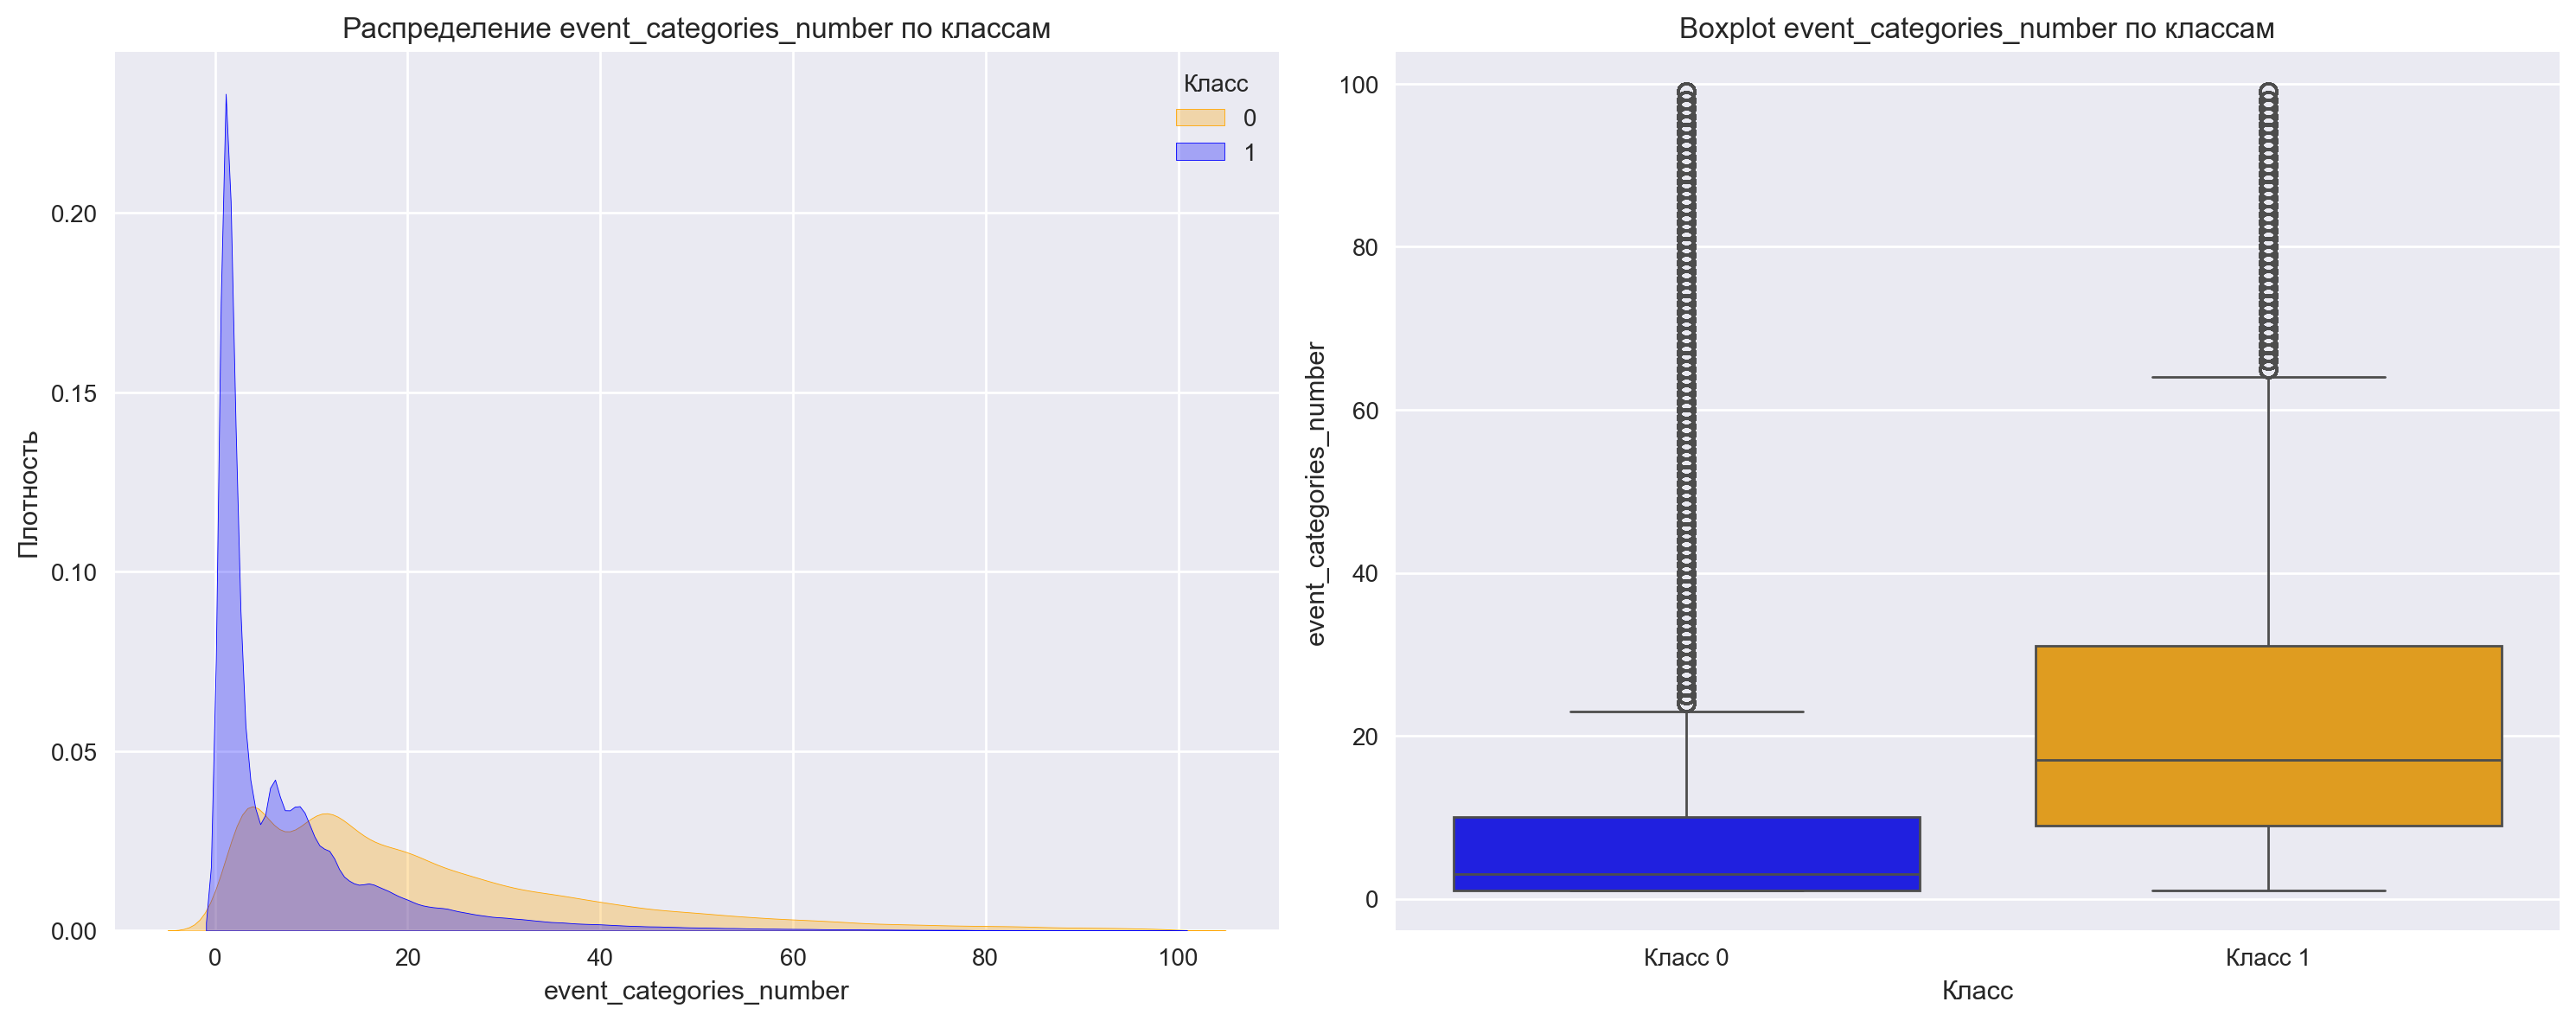

In [14]:
mask = df['event_categories_number'] < 100
report = analyze_numeric_feature(df[mask], 'event_categories_number', 'target')

Хороший признак для задачи классификации, оставляем без изменений.

## Признак `hit_number_median`

Это медианное значение порядковых номеров событий в рамках сессии.

In [15]:
df.groupby('target')['hit_number_median'].agg(['mean', 'median', 'count', 'std', 'min', 'max'])

mean  median    count        std  min    max
target                                                   
0        8.754754     5.0  1649729  10.463558  1.0  496.0
1       20.034234    15.0    82127  18.512684  1.0  434.0

Опять выбросы. Снова анализируем по маске значения данного признака.


📊 Анализ признака 'hit_number_median':
► Размер эффекта (разность средних): 10.5784
► t-тест Уэлча: p-value = 0.0000 (значимо)
► Коэф. Коэна d: 0.846 (средний/большой)

📈 Основные статистики:


count       mean        std  min  25%   50%   75%   max
Класс 0  1647850.0   8.598150   9.192305  1.0  3.0   5.0  11.5  99.5
Класс 1    81537.0  19.176552  15.103047  1.0  9.0  15.0  25.0  99.5

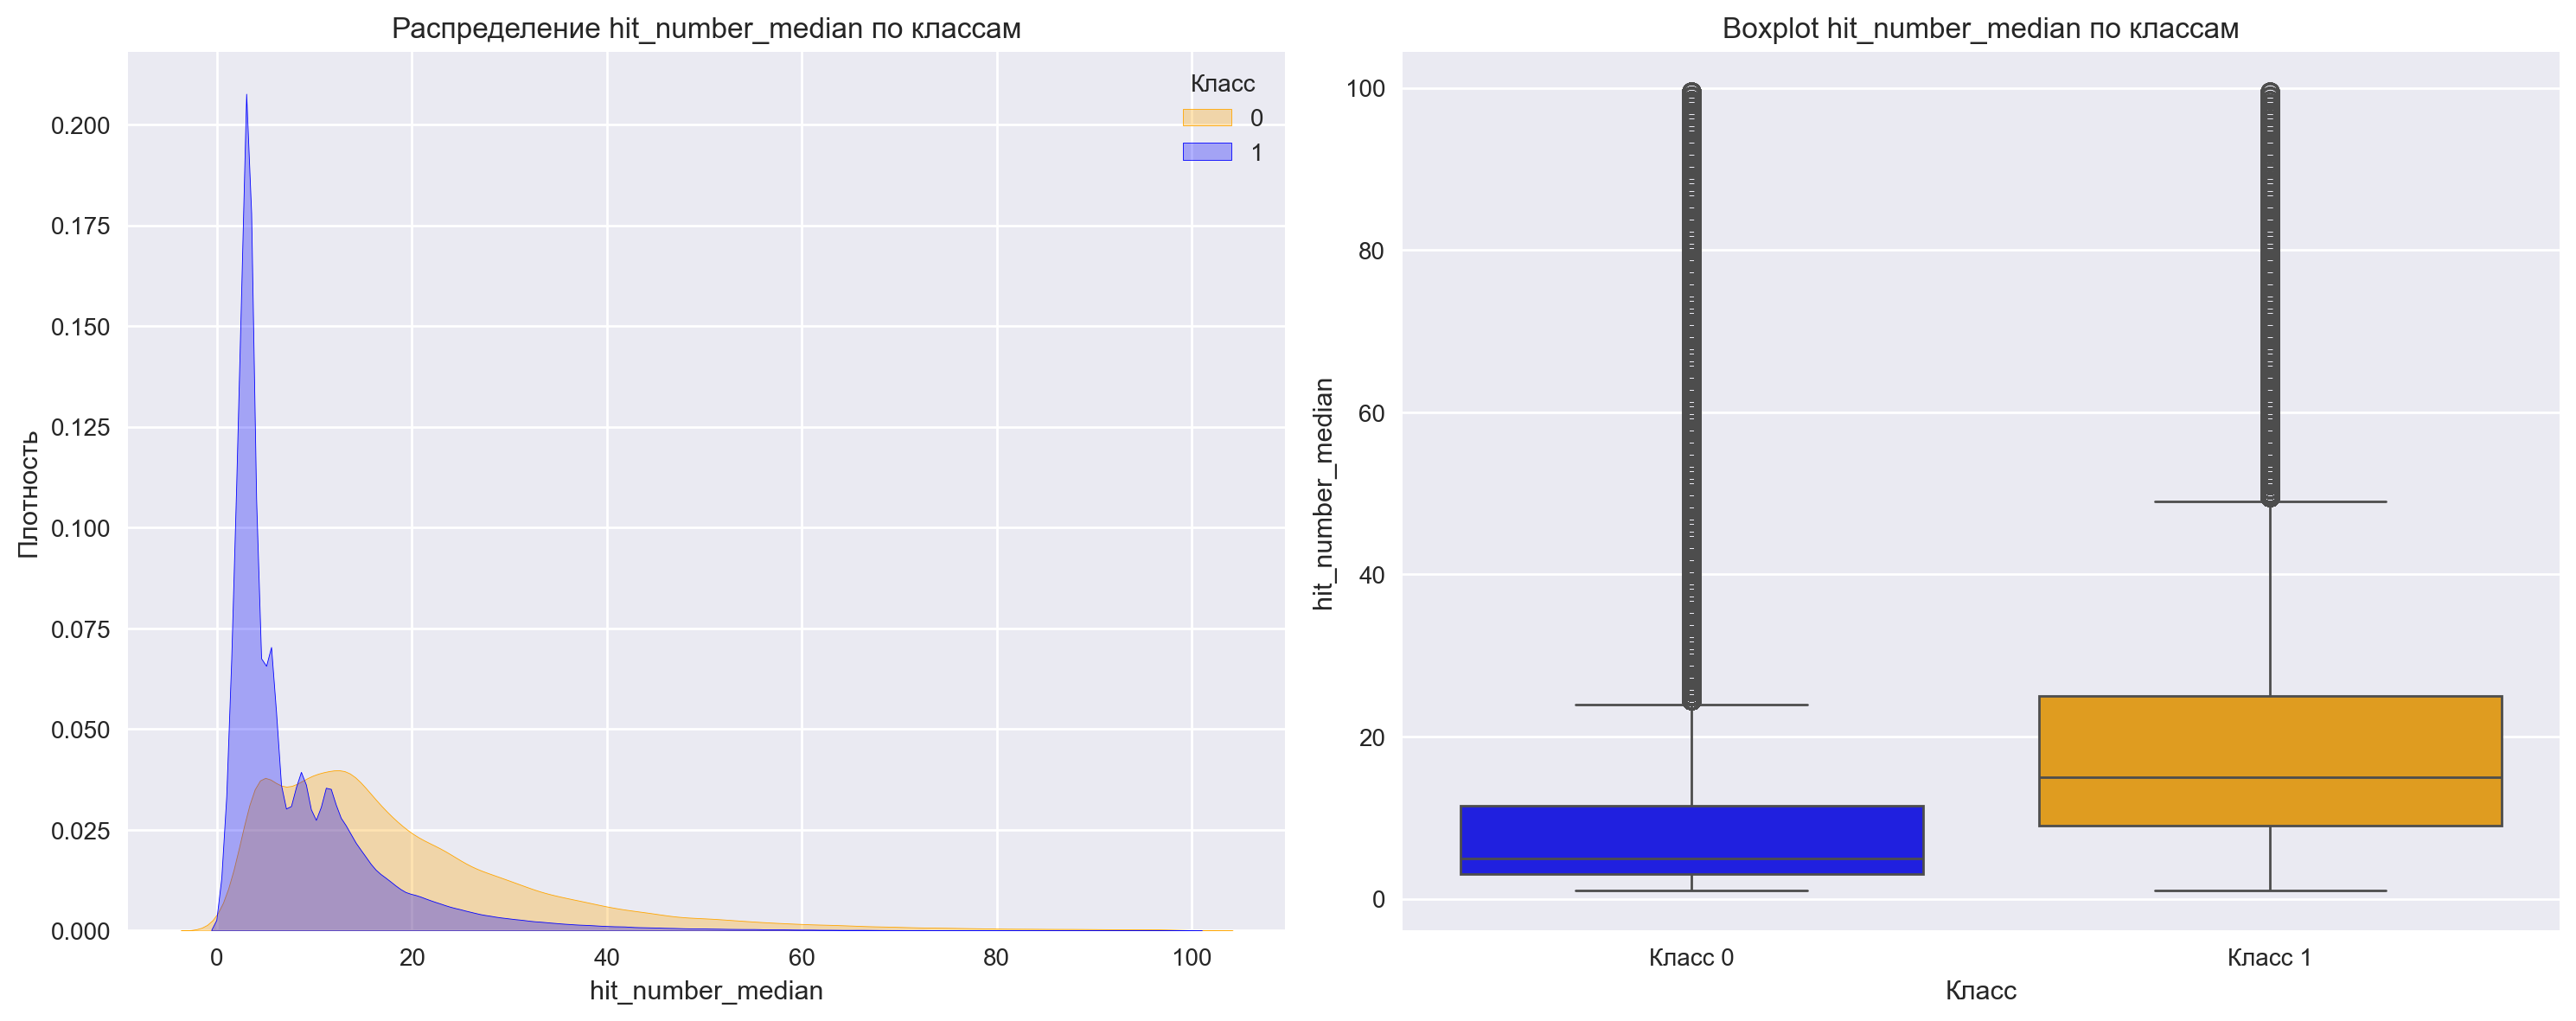

In [16]:
mask = df['hit_number_median'] < 100
report = analyze_numeric_feature(df[mask], 'hit_number_median', 'target')

Снова мы видим, что разница между классами существенная, видно, что в положительном классе медианное и среднее значение порядковых номеров событий выше. Ну и так же видно, что распределние далеко от нормального и содержит выбросы (примерно все, что выше 50). Вероятно, будет коррелировать с предыдущим признаком. Также хороший признак для нашей задачи классификации, оставляем без изменений.

## Признак `screen_area`

Площадь экрана.

In [17]:
df.groupby('target')['screen_area'].agg(['mean', 'median', 'count', 'std', 'min', 'max'])

mean    median    count            std       min         max
target                                                                       
0       608331.651843  334443.0  1649729  707120.137371   57600.0  32000000.0
1       624747.137823  334443.0    82127  664472.149066  153600.0   8294400.0

Различие между средним и медианой в обеих классах практически нет, имеются выбросы. Проанализируем признак по отсекающей маске.


📊 Анализ признака 'screen_area':
► Размер эффекта (разность средних): 416.9612
► t-тест Уэлча: p-value = 0.0482 (значимо)
► Коэф. Коэна d: 0.008 (малый)

📈 Основные статистики:


count           mean           std       min       25%       50%  \
Класс 0  1307080.0  310406.680406  52599.182839   57600.0  273600.0  304704.0   
Класс 1    63063.0  310823.641628  51719.797628  153600.0  273600.0  304704.0   

              75%       max  
Класс 0  358028.0  499200.0  
Класс 1  358028.0  499200.0

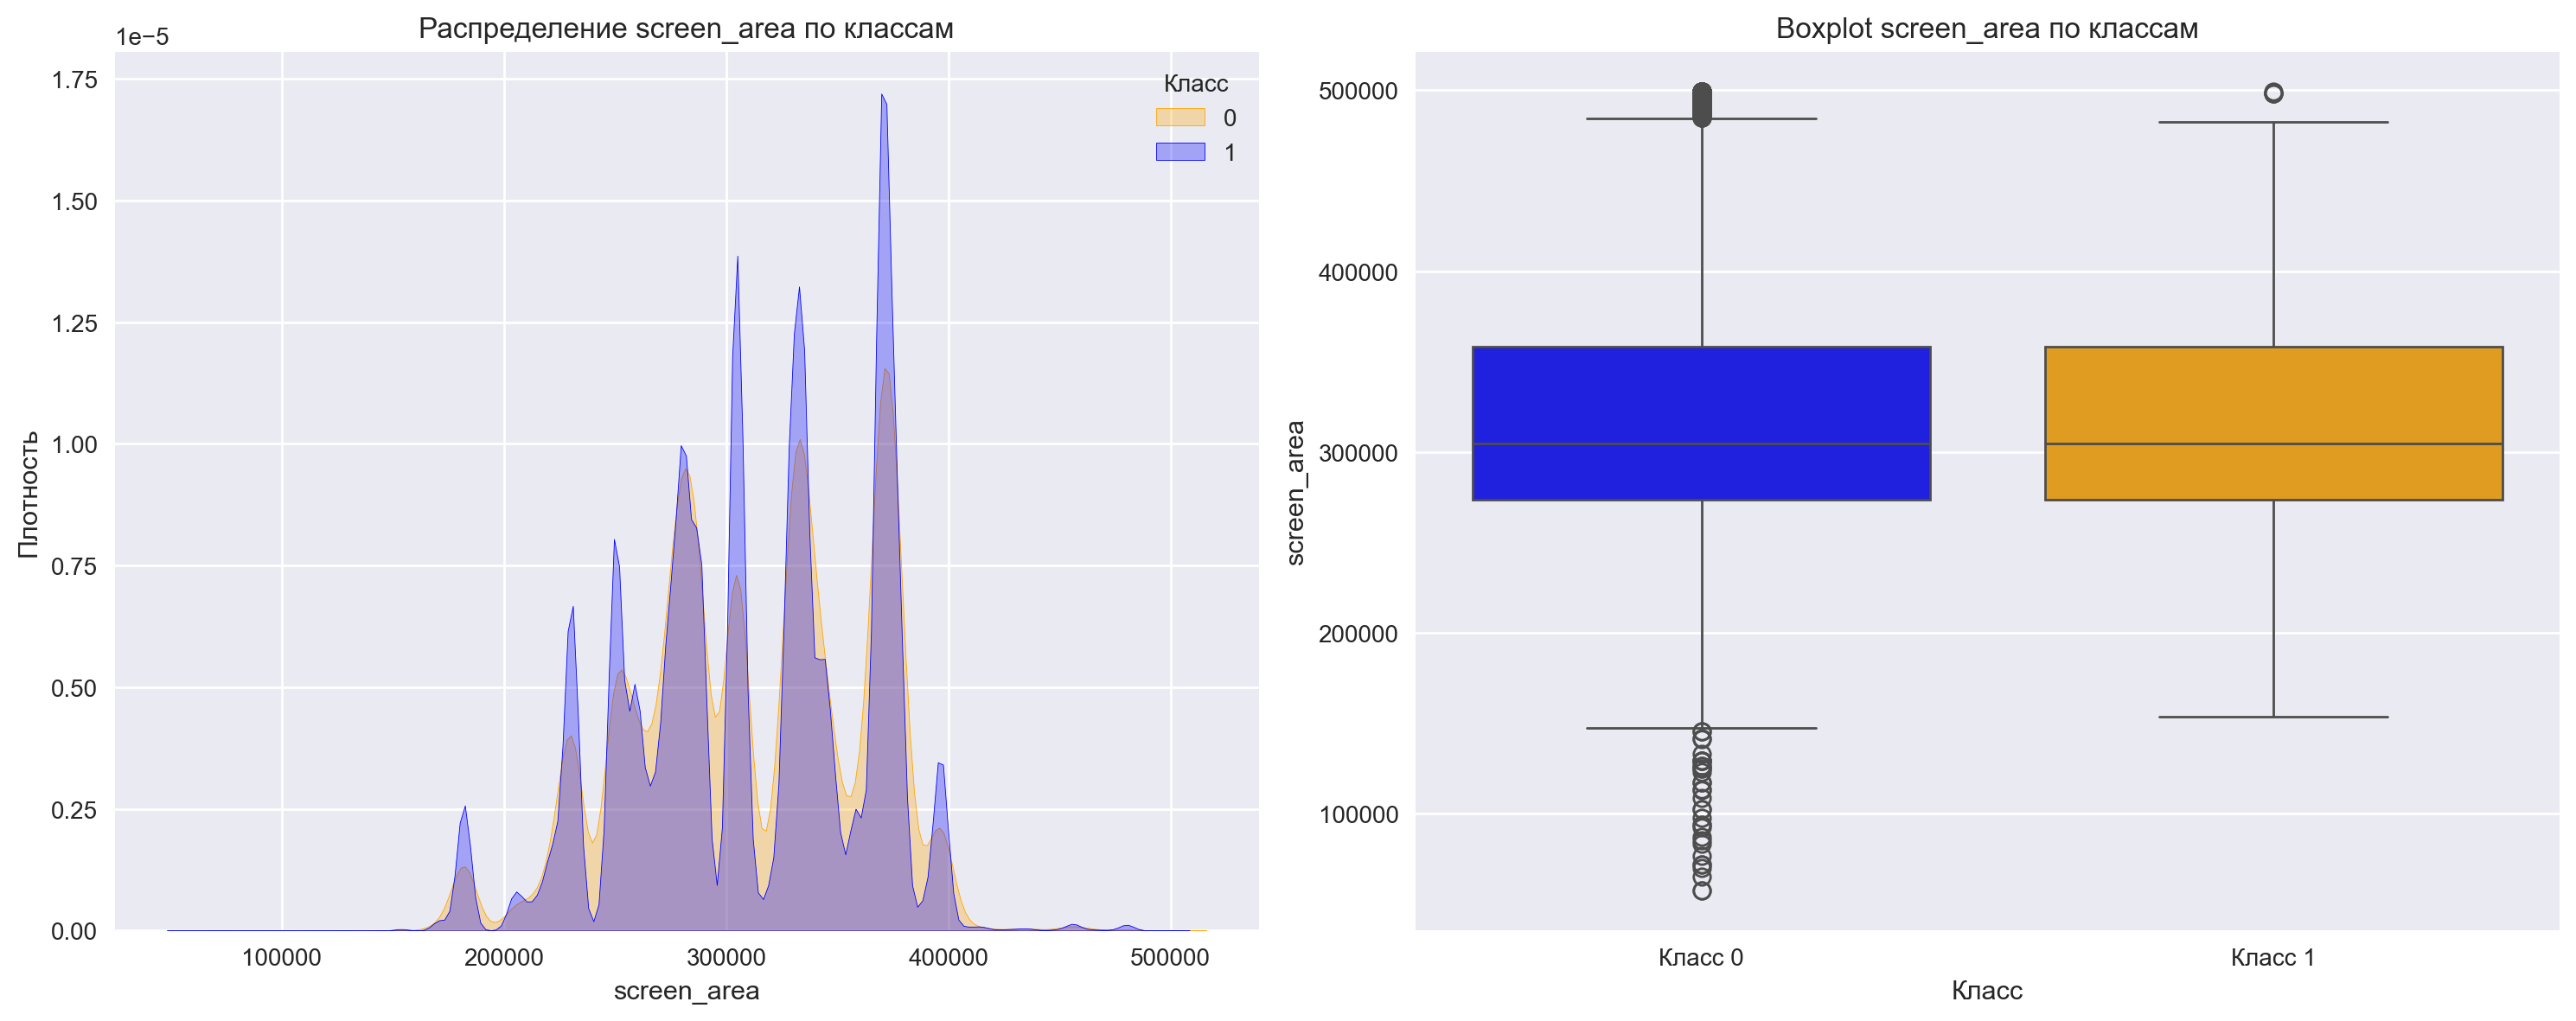

In [18]:
mask = df['screen_area'] < 500000
report = analyze_numeric_feature(df[mask], 'screen_area', 'target')

Учитывая данные диаграмм, статистических показателй (в т.ч. t-test Уэлча с p равным почти 0.05 и малым коэффициентом Коэна) можно сказать, что разницы по доле целевых действий в классах нет. Признак удаляем.

In [19]:
df.drop(['screen_area'], axis=1, inplace=True)

## Признак `visit_date`

In [20]:
# Преобразование в datetime
df['visit_date'] = pd.to_datetime(df['visit_date'])

In [21]:
print('Даты первого и послденего визита в данных: ',df.visit_date.min(), ' ', df.visit_date.max() )

Даты первого и послденего визита в данных:  2021-05-19 00:00:00   2021-12-31 00:00:00


In [22]:
# создание месяца визита
df['month'] = df['visit_date'].dt.month
# создание дня недели визита
df['day_of_week'] = df['visit_date'].dt.dayofweek


📊 Анализ признака 'month' (уникальных значений: 8):
► Тест хи-квадрат: p-value = 0.0000 (значимо)
► Коэф. Крамера V (сила связи): 0.043

📈 Распределение таргета по категориям (по убыванию доли класса 1):


Общее_количество  Доля_от_общего_%  Частота_0  Частота_1  \
month                                                             
10               263402             15.21     244859      18543   
11               263702             15.23     249831      13871   
5                104584              6.04      99130       5454   
8                154975              8.95     147060       7915   
9                243770             14.08     231587      12183   
12               366176             21.14     352452      13724   
6                160573              9.27     154861       5712   
7                174674             10.09     169949       4725   

       Доля_класса_1_%  
month                   
10                7.04  
11                5.26  
5                 5.21  
8                 5.11  
9                 5.00  
12                3.75  
6                 3.56  
7                 2.71

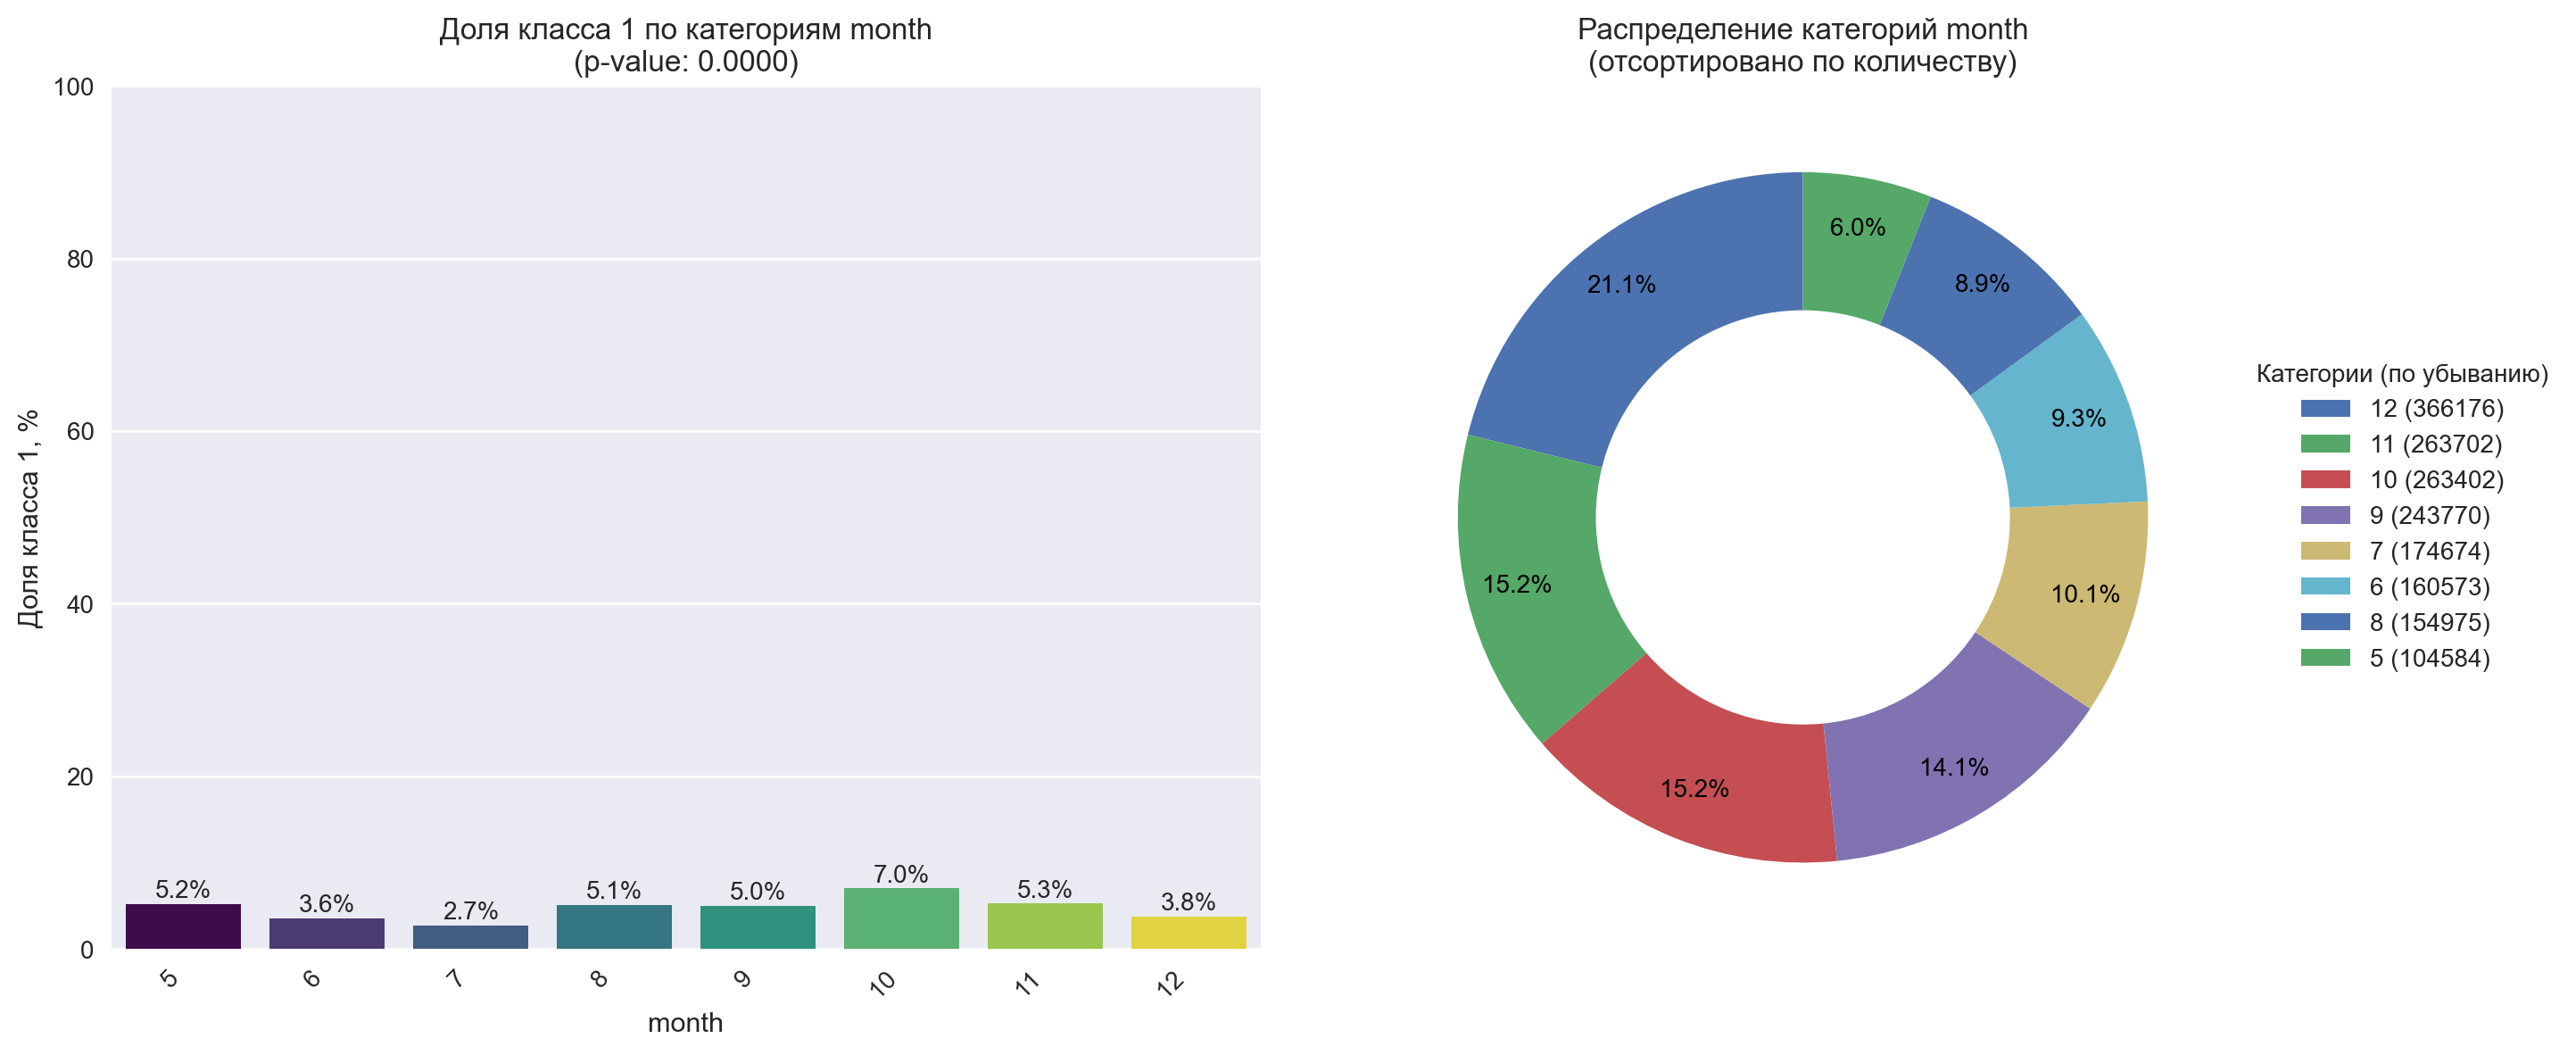

In [23]:
# анализируем связь нового признака month с таргетом
report = analyze_categorical_feature(df, 'month', 'target')


📊 Анализ признака 'day_of_week' (уникальных значений: 7):
► Тест хи-квадрат: p-value = 0.0000 (значимо)
► Коэф. Крамера V (сила связи): 0.005

📈 Распределение таргета по категориям (по убыванию доли класса 1):


Общее_количество  Доля_от_общего_%  Частота_0  Частота_1  \
day_of_week                                                             
2                      240873             13.91     228832      12041   
3                      252169             14.56     239741      12428   
1                      286921             16.57     273275      13646   
0                      281714             16.27     268423      13291   
4                      248501             14.35     237028      11473   
6                      210553             12.16     200820       9733   
5                      211125             12.19     201610       9515   

             Доля_класса_1_%  
day_of_week                   
2                       5.00  
3                       4.93  
1                       4.76  
0                       4.72  
4                       4.62  
6                       4.62  
5                       4.51

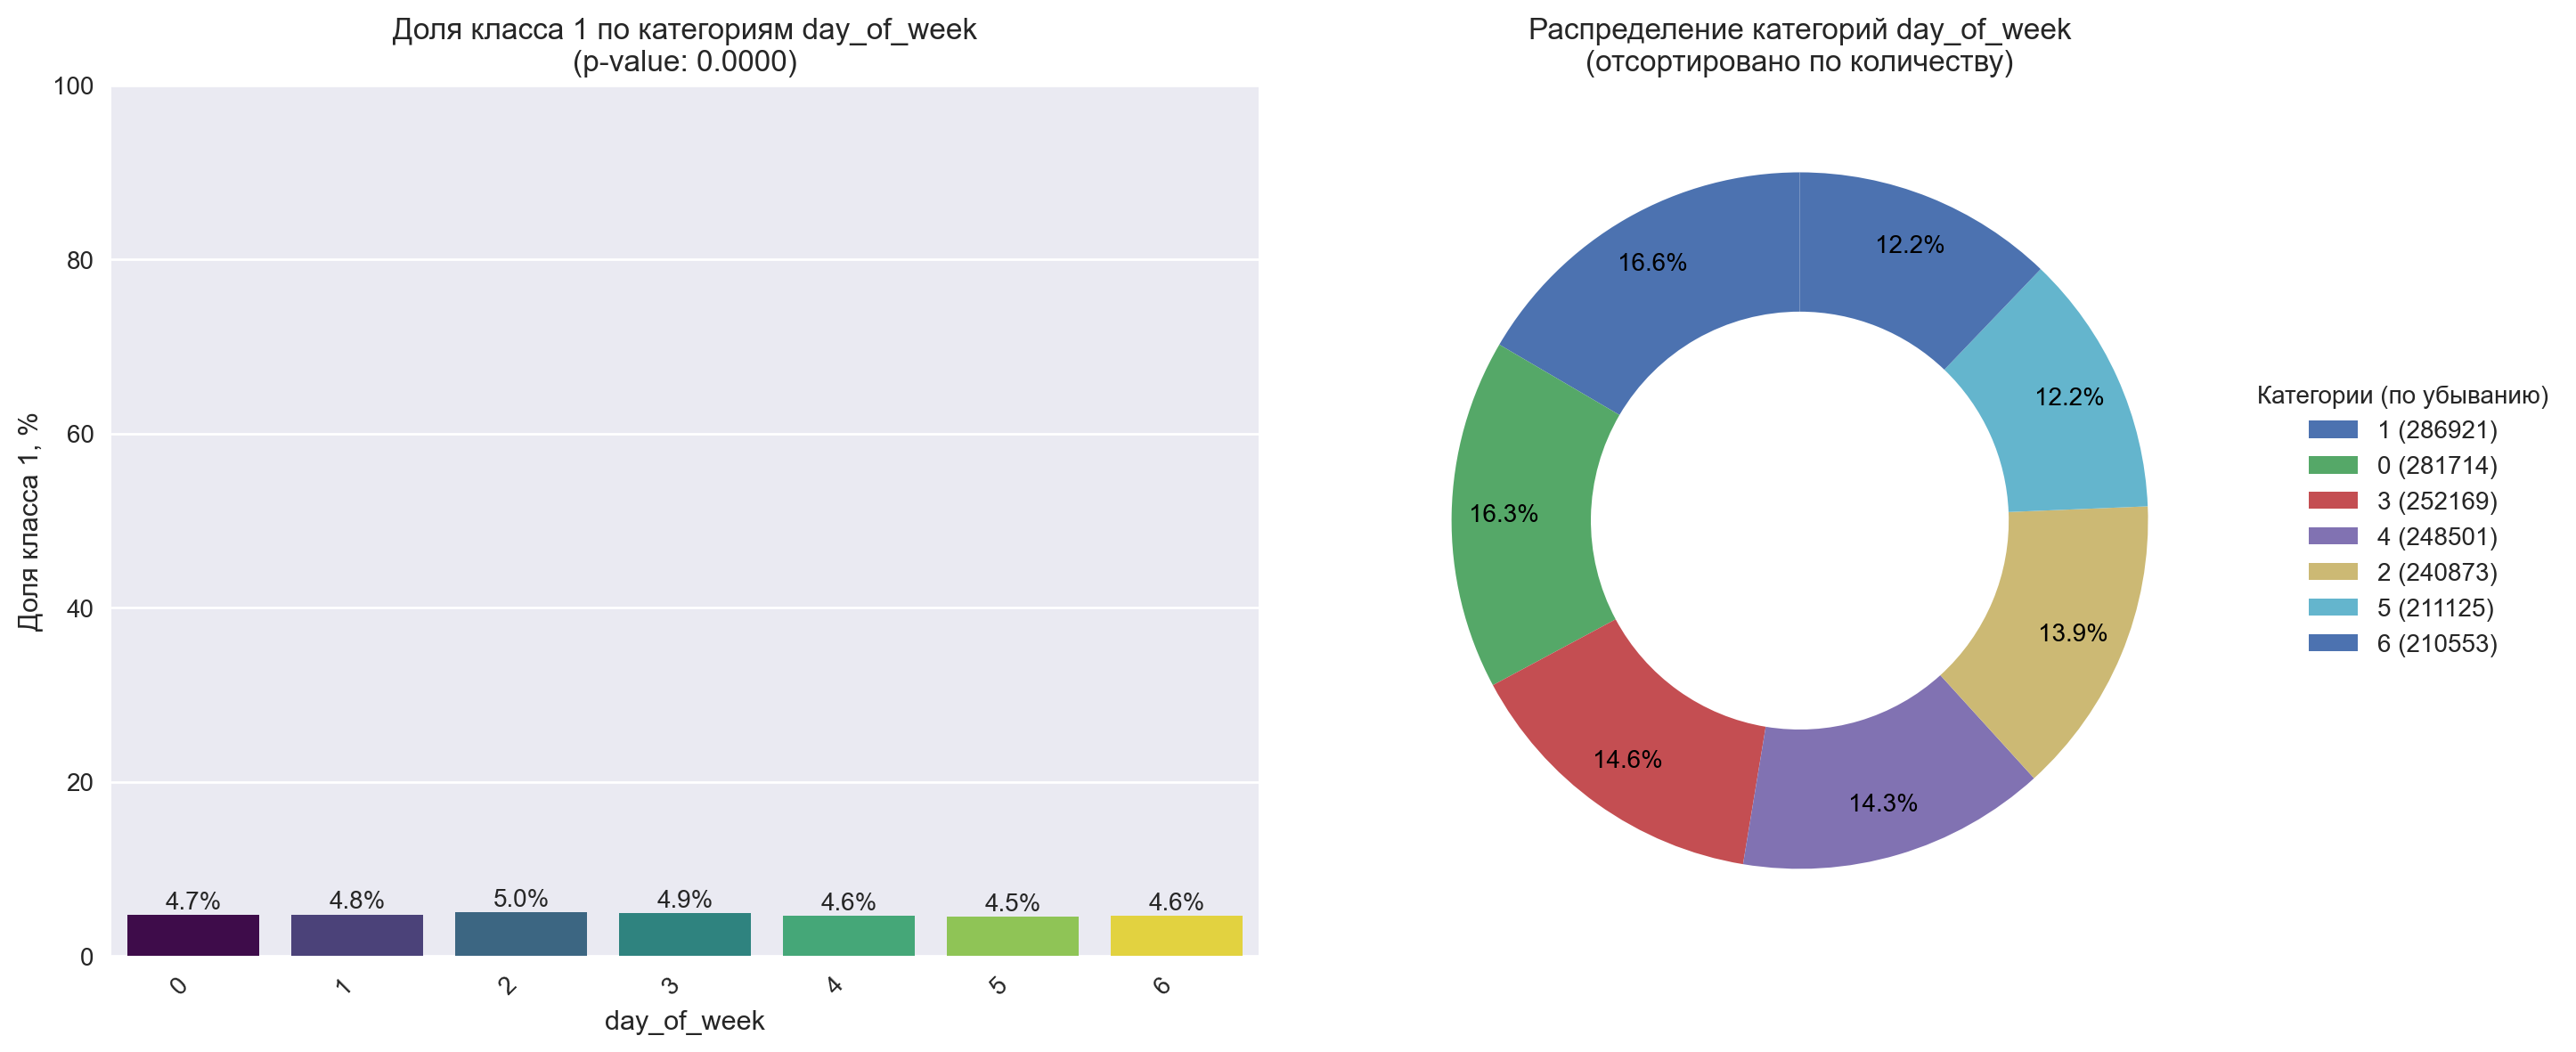

In [24]:
# анализируем связь нового признака day_of_week с таргетом
report = analyze_categorical_feature(df, 'day_of_week', 'target')

Данные представлены с 19 мая по 31 декабря 2021 года. Наибольшее количество сессий в декабре. Видно, что есть статистически значимая разница в соотношении классов в разрезе месяца посещения и дня недели, однако также видно, что эта разница более существенная в разрезе месяца - наибольшая доля целевых действий в октябре, наименьшая в июле.

## Признак `visit_time`

In [25]:
# Создаем новый признак visit_hour
df['visit_hour'] = pd.to_datetime(df['visit_time']).dt.hour

/var/folders/82/7qspv7mx2wj5rh25ylxc2jpr0000gn/T/ipykernel_96409/446425336.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['visit_hour'] = pd.to_datetime(df['visit_time']).dt.hour



📊 Анализ признака 'visit_hour' (уникальных значений: 24):
► Тест хи-квадрат: p-value = 0.0000 (значимо)
► Коэф. Крамера V (сила связи): 0.014

📈 Распределение таргета по категориям (по убыванию доли класса 1):


Общее_количество  Доля_от_общего_%  Частота_0  Частота_1  \
visit_hour                                                             
13                     95810              5.53      90754       5056   
16                     98446              5.68      93274       5172   
17                     94289              5.44      89369       4920   
11                     93658              5.41      88780       4878   
15                     96862              5.59      91841       5021   
12                     94588              5.46      89732       4856   
14                    104189              6.02      98908       5281   
10                     93150              5.38      88639       4511   
18                     94652              5.47      90088       4564   
20                     91689              5.29      87426       4263   
0                      61980              3.58      59123       2857   
21                     90626              5.23      86458       4168   
19                     92001              5.31      87784       4217   
9                      85349              4.93      81471       3878   
22                     87339              5.04      83470       3869   
8                      66922              3.86      64064       2858   
1                      37544              2.17      35967       1577   
23                     79326              4.58      76021       3305   
4                      19020              1.10      18243        777   
3                      19844              1.15      19056        788   
6                      34112              1.97      32763       1349   
2                      25566              1.48      24555       1011   
7                      51132              2.95      49117       2015   
5                      23762              1.37      22826        936   

            Доля_класса_1_%  
visit_hour                   
13                     5.28  
16                     5.25  
17                     5.22  
11                     5.21  
15                     5.18  
12                     5.13  
14                     5.07  
10                     4.84  
18                     4.82  
20                     4.65  
0                      4.61  
21                     4.60  
19                     4.58  
9                      4.54  
22                     4.43  
8                      4.27  
1                      4.20  
23                     4.17  
4                      4.09  
3                      3.97  
6                      3.95  
2                      3.95  
7                      3.94  
5                      3.94

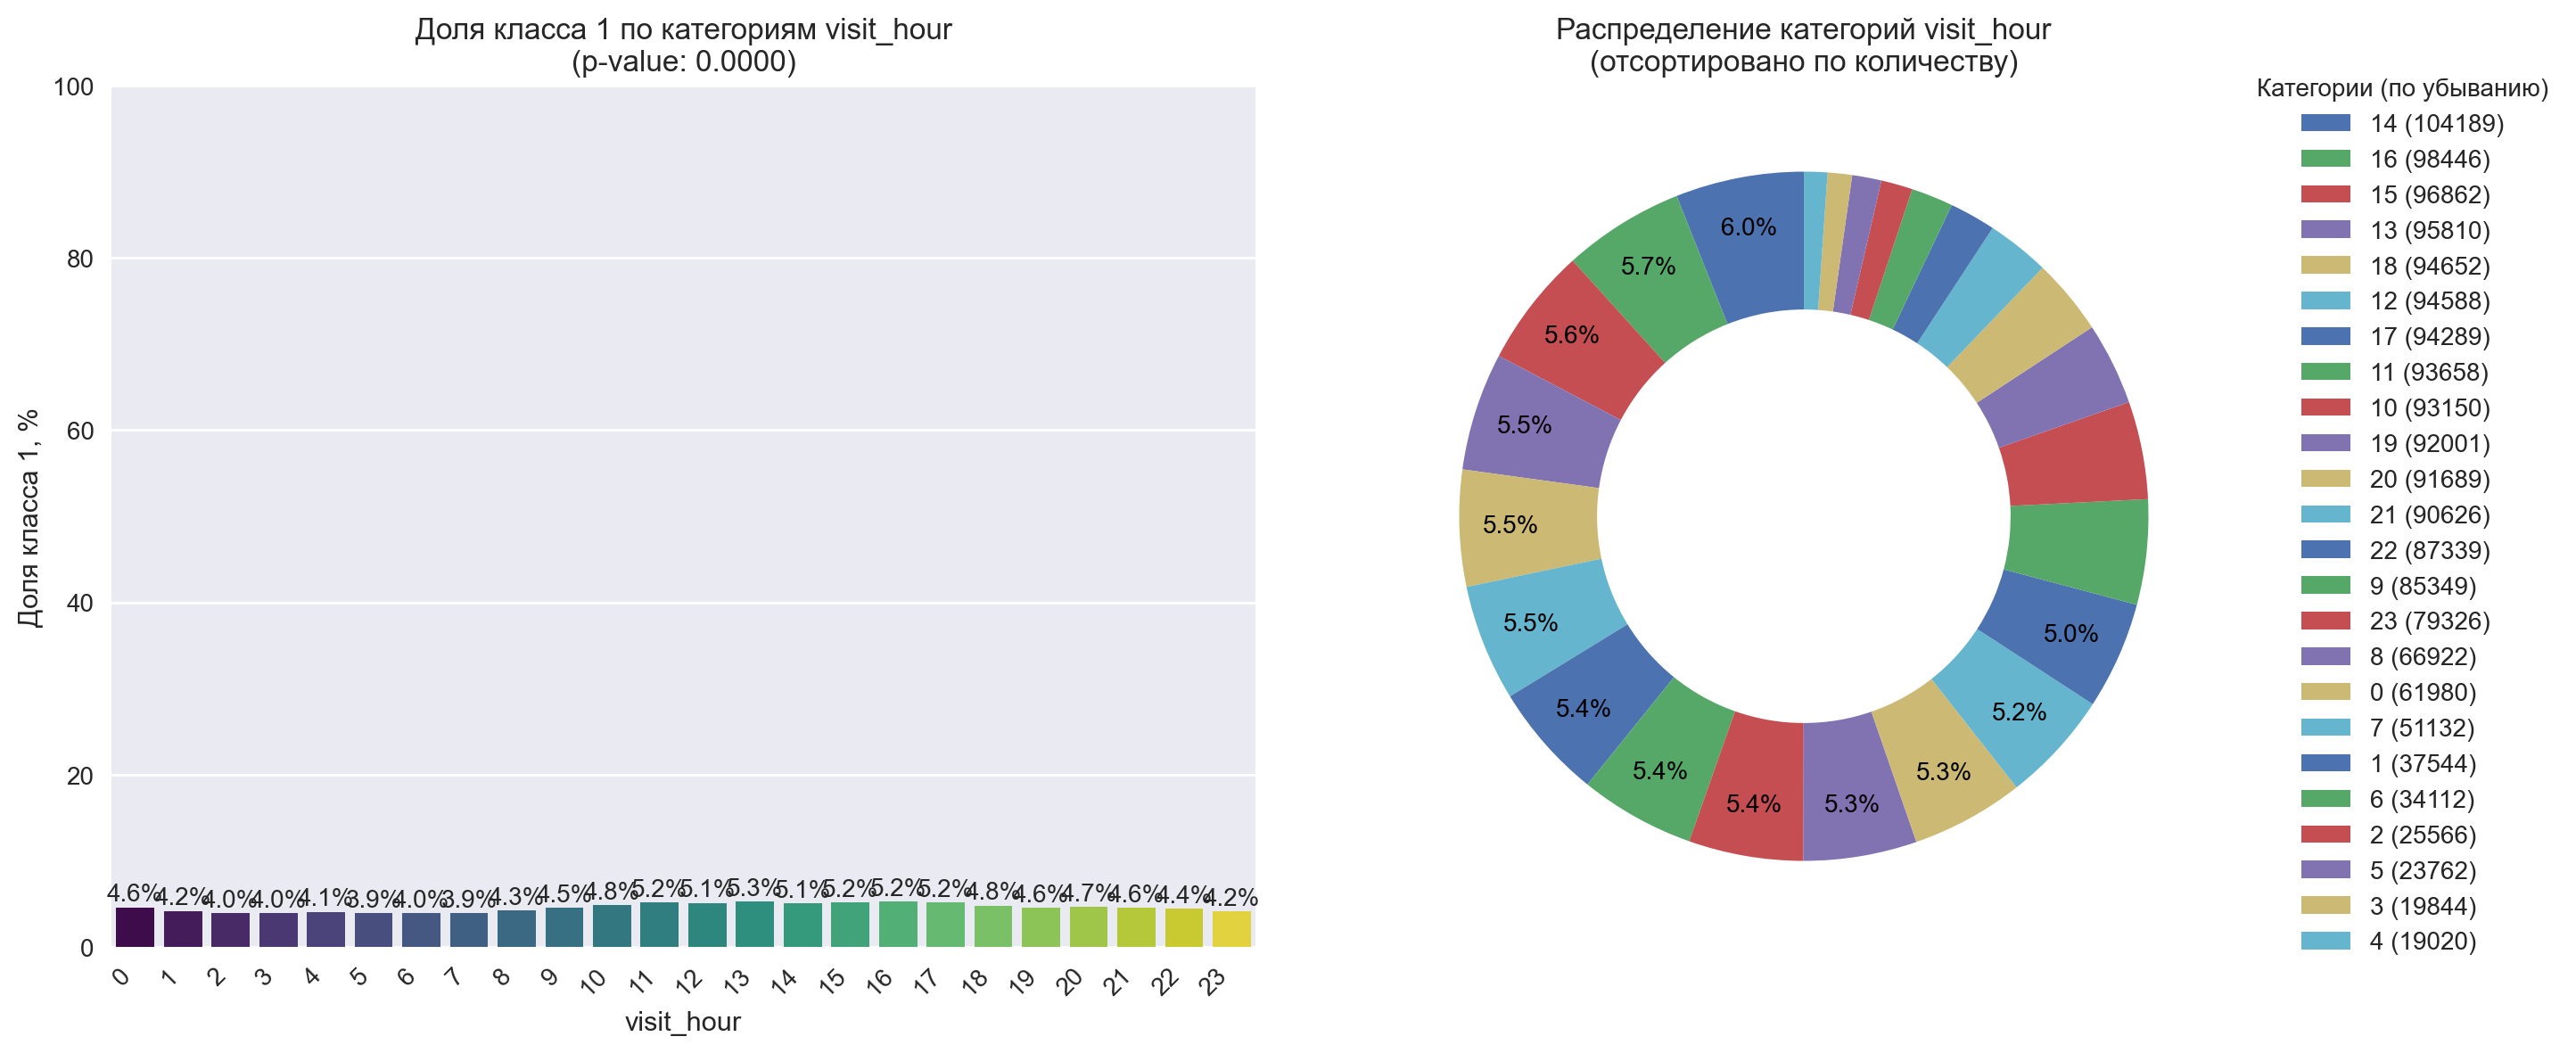

In [26]:
# анализируем связь нового признака visit_hour с таргетом
report = analyze_categorical_feature(df, 'visit_hour', 'target')

Видим, что доля 1 класса выше 5% в промежутке 11-17 часов, в остальное время она ниже 5%.

In [27]:
# создадим новый признак time_of_day

time_mapping = {
    **{hour: 'night' for hour in range(0, 6)},
    **{hour: 'morning' for hour in range(6, 11)},
    **{hour: 'day' for hour in range(11, 18)},
    **{hour: 'evening' for hour in range(18, 24)}
}
df['time_of_day'] = df['visit_hour'].map(time_mapping)


📊 Анализ признака 'time_of_day' (уникальных значений: 4):
► Тест хи-квадрат: p-value = 0.0000 (значимо)
► Коэф. Крамера V (сила связи): 0.012

📈 Распределение таргета по категориям (по убыванию доли класса 1):


Общее_количество  Доля_от_общего_%  Частота_0  Частота_1  \
time_of_day                                                             
day                    677842             39.14     642658      35184   
evening                535633             30.93     511247      24386   
morning                330665             19.09     316054      14611   
night                  187716             10.84     179770       7946   

             Доля_класса_1_%  
time_of_day                   
day                     5.19  
evening                 4.55  
morning                 4.42  
night                   4.23

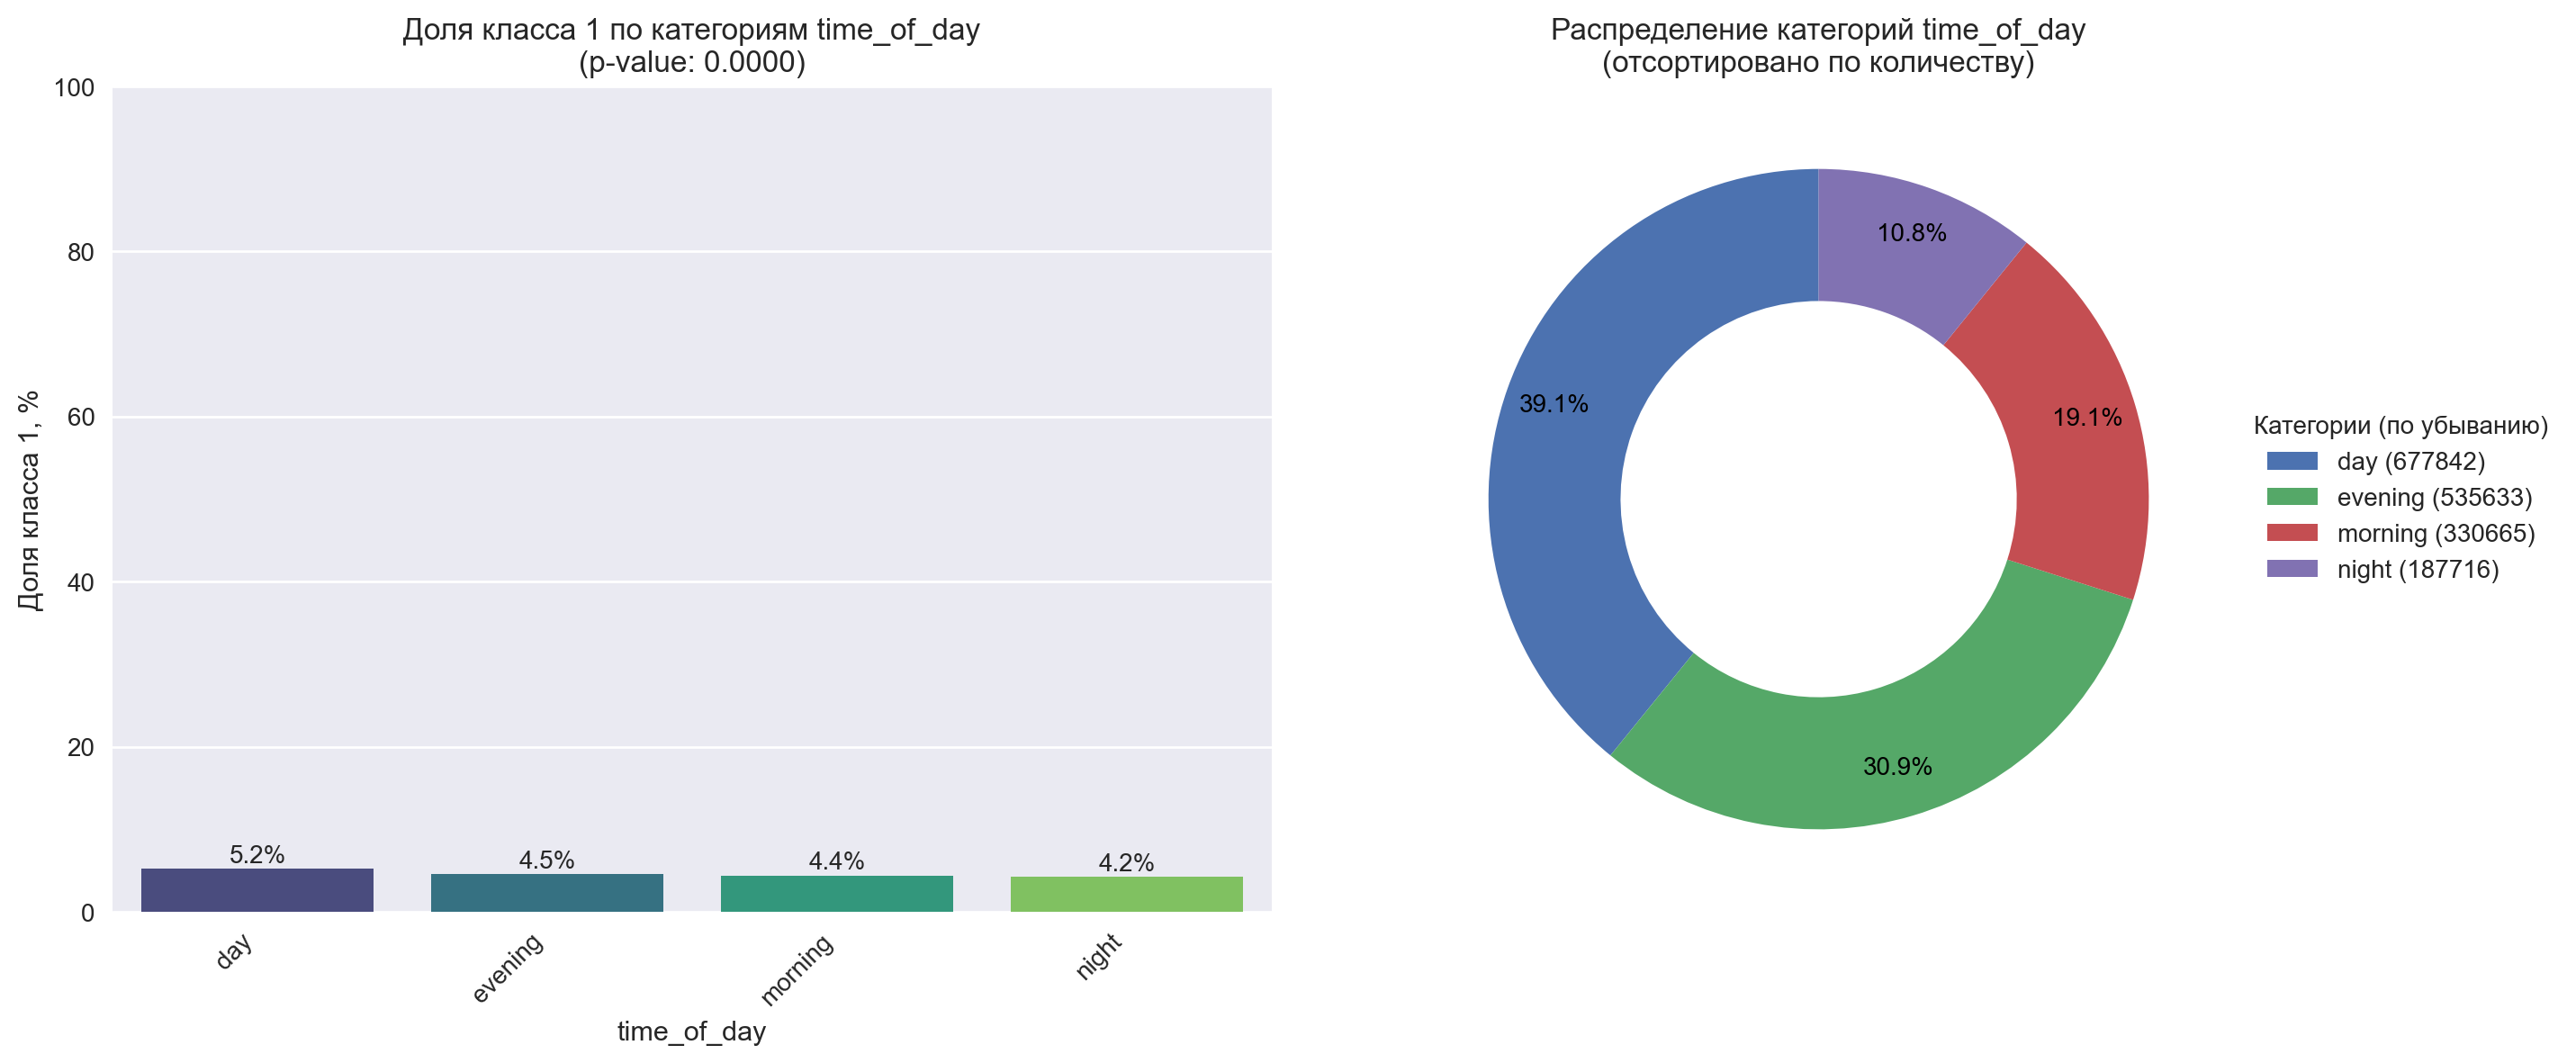

In [28]:
# анализируем связь нового признака time_of_day с таргетом
report = analyze_categorical_feature(df, 'time_of_day', 'target')

Видно, что наибольшее количество посещений в дневное время, наименьшее - ночью. Доля целевых действий (класс 1) выше днем, наименьшая ночью. 

In [29]:
# удалим исходные признаки visit_date, visit_time, visit_hour
df.drop(['visit_date', 'visit_time', 'visit_hour'], axis=1, inplace=True)

## Признак `top_car_brand`	

Указывает на страницу с какой маркой авто пользователь заходил чаще всего в данную сессию.


📊 Анализ признака 'top_car_brand' (уникальных значений: 21):
► Тест хи-квадрат: p-value = 0.0000 (значимо)
► Коэф. Крамера V (сила связи): 0.066

📈 Распределение таргета по категориям (по убыванию доли класса 1):


Общее_количество  Доля_от_общего_%  Частота_0  Частота_1  \
top_car_brand                                                             
lada-vaz                  39585              2.29      34402       5183   
hyundai                    1600              0.09       1396        204   
kia                       16583              0.96      14849       1734   
volkswagen                34315              1.98      30911       3404   
toyota                    11236              0.65      10179       1057   
skoda                     69231              4.00      63052       6179   
haval                      4014              0.23       3679        335   
peugeot                    2194              0.13       2034        160   
nissan                    22484              1.30      21103       1381   
renault                   16123              0.93      15178        945   
volvo                      3950              0.23       3723        227   
audi                       4194              0.24       3964        230   
mini                       2663              0.15       2520        143   
bmw                       14272              0.82      13506        766   
mercedes-benz             40798              2.36      38620       2178   
none                    1434657             82.84    1377111      57546   
land-rover                 1706              0.10       1646         60   
lexus                      6461              0.37       6245        216   
porsche                    5781              0.33       5602        179   
infiniti                      4              0.00          4          0   
honda                         5              0.00          5          0   

               Доля_класса_1_%  
top_car_brand                   
lada-vaz                 13.09  
hyundai                  12.75  
kia                      10.46  
volkswagen                9.92  
toyota                    9.41  
skoda                     8.93  
haval                     8.35  
peugeot                   7.29  
nissan                    6.14  
renault                   5.86  
volvo                     5.75  
audi                      5.48  
mini                      5.37  
bmw                       5.37  
mercedes-benz             5.34  
none                      4.01  
land-rover                3.52  
lexus                     3.34  
porsche                   3.10  
infiniti                  0.00  
honda                     0.00

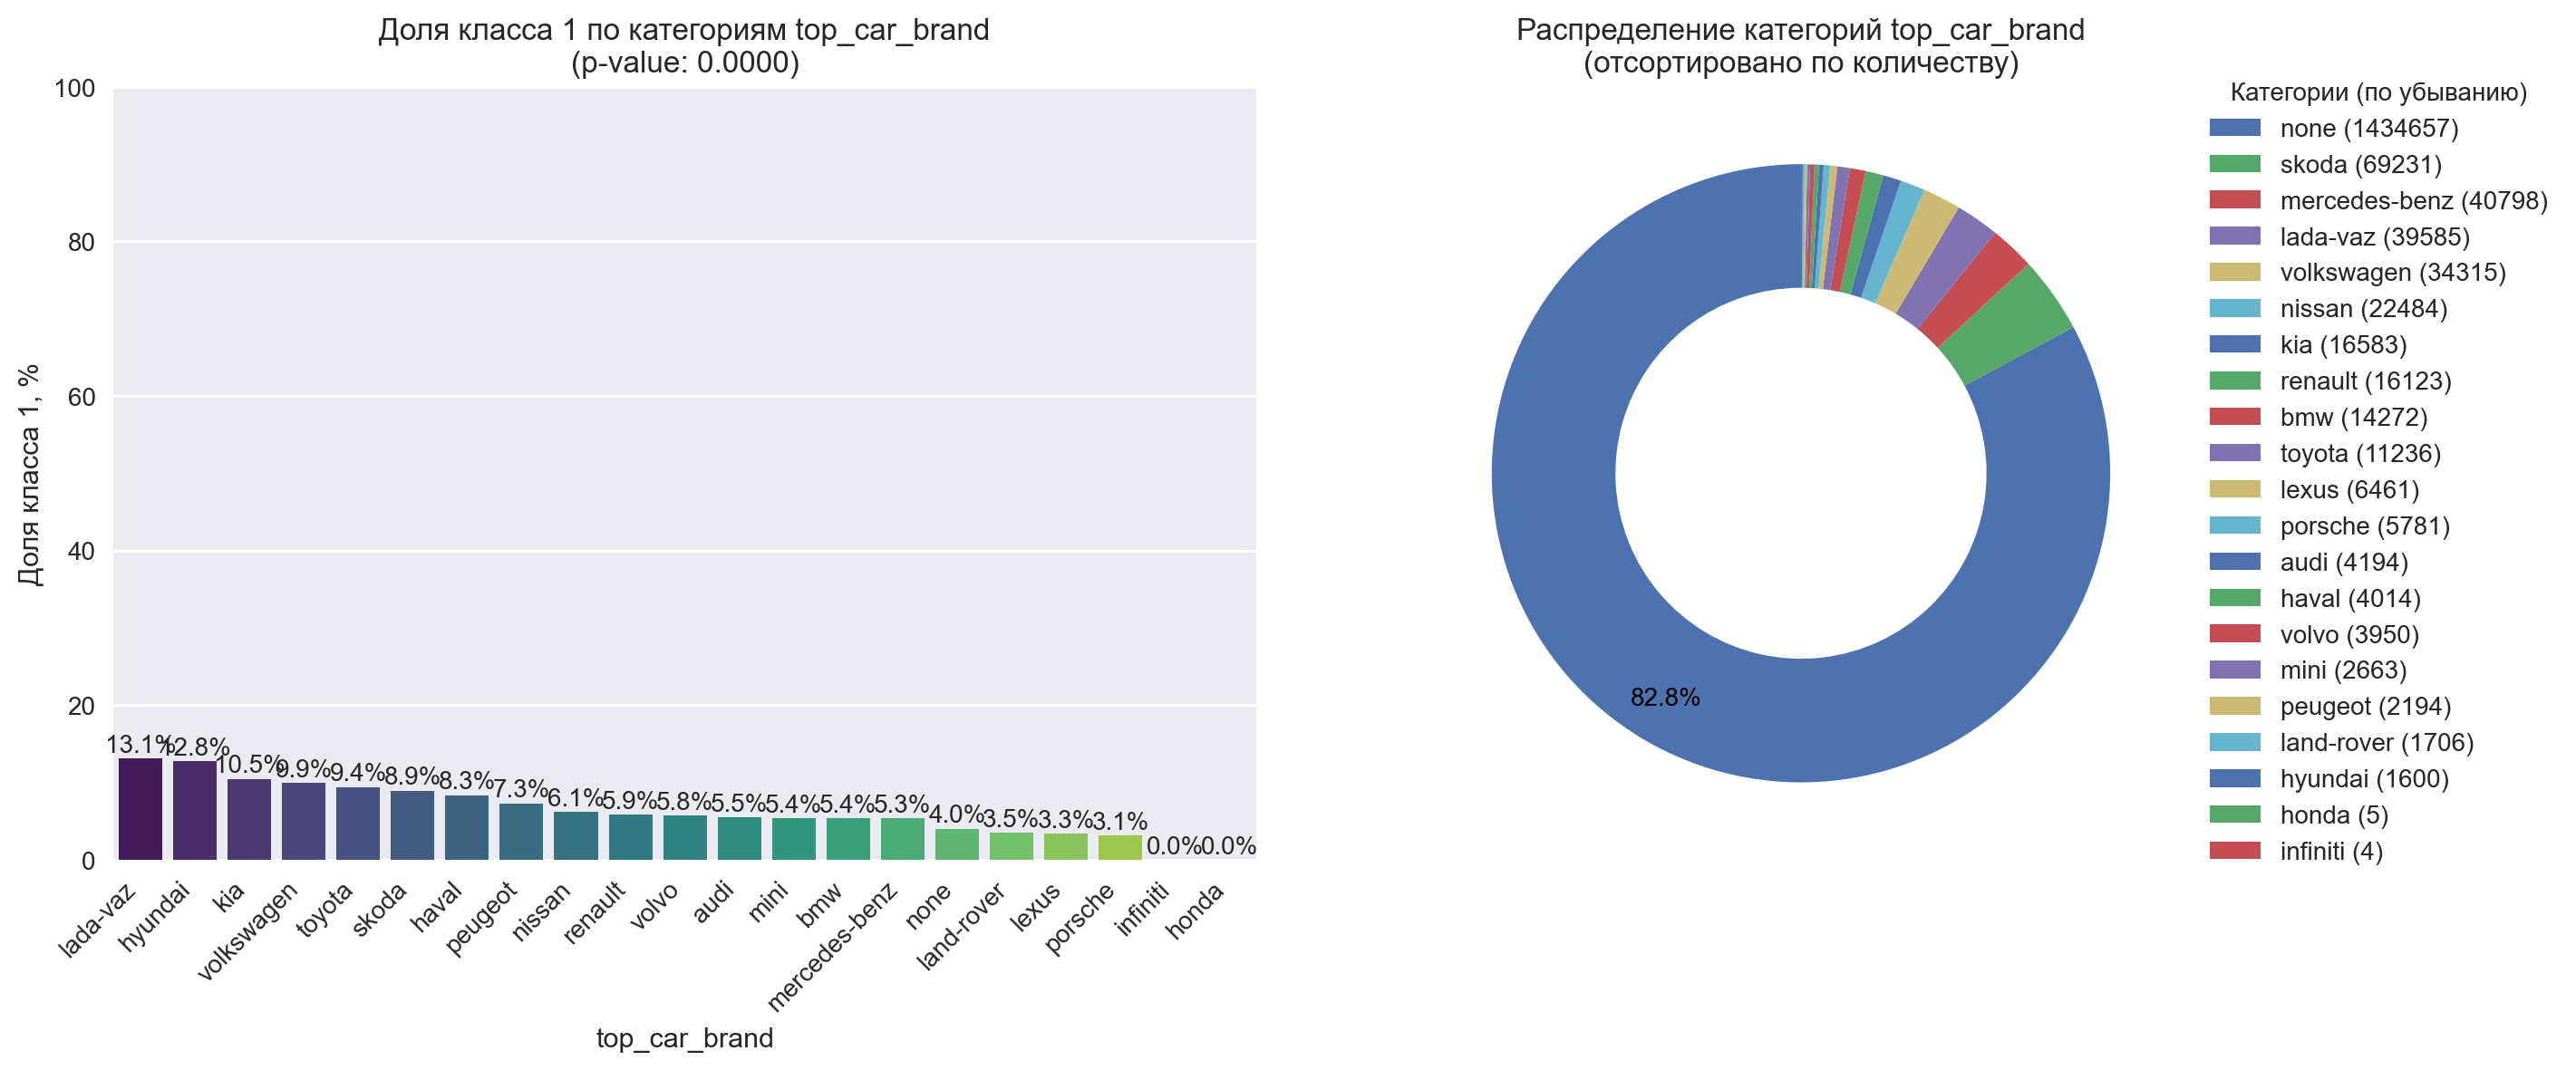

In [30]:
report = analyze_categorical_feature(df, 'top_car_brand', 'target')

Почти в 83% сессий мы не знаем информацию о посещенных страницах с выбором автомобиля. Но в оставшемся объеме данныхв ТОП-3 марок - Skoda, Mercedes-Benz и Lada-Vaz. При этом мы видим, что в данных со значением признака 'none' доля целевых действий только 4%.   
 
Разделим данный признак на 3 части: 
- топ-15 марок, где доля целевых действий > 5% обозначим значением = 1
- значения *infiniti* и *honda*, где доля целевых действий 0% обозначим значением = 0
- остальное обозначим 2

In [31]:
top_15_car_brand = report.index[:15].to_list()
down_2_car_brand = ['infiniti', 'honda']

def map_car_brand(brand):
    '''
    Функция меняет значения признака top_car_brand по условиям
    '''
    if brand in top_15_car_brand:
        return 1
    elif brand in down_2_car_brand:
        return 0
    else:
        return 2

df['top_car_brand'] = df['top_car_brand'].apply(map_car_brand)

## Признак `utm_source`

Канал привлечения.

In [32]:
df.utm_source.value_counts()[:30]

utm_source
ZpYIoDJMcFzVoPFsHGJL    552551
fDLlAcSmythWSCVMvqvL    277064
kjsLglQLzykiRbcDiGcD    245159
MvfHsxITijuriZxsqZqt    175818
BHcvLfOaCWvWTykYqHVe    110943
bByPQxmDaMXgpHeypKSM     90400
QxAxdyPLuQMEcrdZWdWb     45267
aXQzDWsJuGXeBXexNHjc     29528
jaSOmLICuBzCFqHfBdRg     28286
RmEBuqrriAfAVsLQQmhk     27412
PlbkrSYoHuZBWfYjYnfw     20362
vFcAhRxLfOWKhvxjELkx     18287
hTjLvqNxGggkGnxSCaTm     14392
gDBGzjFKYabGgSPZvrDH     13331
fgymSoTvjKPEgaIJqsiH      9557
geDcueAOghDzHkGMmdOq      8178
ISrKoXQCxqqYvAZICvjs      7836
nSReTmyFtbSjlPrTKoaX      5814
eLzNJHzPelJpEyBwMrKo      4578
IZEXUFLARCUMynmHNBGo      4248
iNFgfQPqHPBuvGCYtrQE      3101
gVRrcxiDQubJiljoTbGm      2733
SzZERoLMmrEUEhDaYcyN      2648
oZCzWSykfixnjMPDNjSU      2585
nmfptFmSirEqNzAzqbXA      2197
GpAkIXsclxDGyILfNlrR      2071
TxKUcPpthBDPieTGmVhx      2024
ghoaGAksqhKomdFrxgyJ      1859
KgicpPxiEQfzPlPwQZJq      1674
nrKihqcWGIzDsOqljdAv      1514
Name: count, dtype: int64

Слишком много значений в которых мы просто утонем. Оставим только ТОП-5, обозначив их, соответствено, от 0-4, а 5 - это все остальное.

In [33]:
# получаем топ-5 значений
top_5 = df['utm_source'].value_counts()[:5].index.to_list()

# создаем словарь для замены: {старое_значение: новое_значение}
replace_dict = {value: idx for idx, value in enumerate(top_5)}

# заменяем значения: топ-5 на их индексы (0-4), остальные на 5
df['utm_source'] = df['utm_source'].map(replace_dict).fillna(5).astype(int)

Теперь проводим анализ признака.


📊 Анализ признака 'utm_source' (уникальных значений: 6):
► Тест хи-квадрат: p-value = 0.0000 (значимо)
► Коэф. Крамера V (сила связи): 0.033

📈 Распределение таргета по категориям (по убыванию доли класса 1):


Общее_количество  Доля_от_общего_%  Частота_0  Частота_1  \
utm_source                                                             
0                     552551             31.91     521719      30832   
4                     110943              6.41     104992       5951   
5                     370321             21.38     351595      18726   
1                     277064             16.00     263948      13116   
2                     245159             14.16     235713       9446   
3                     175818             10.15     171762       4056   

            Доля_класса_1_%  
utm_source                   
0                      5.58  
4                      5.36  
5                      5.06  
1                      4.73  
2                      3.85  
3                      2.31

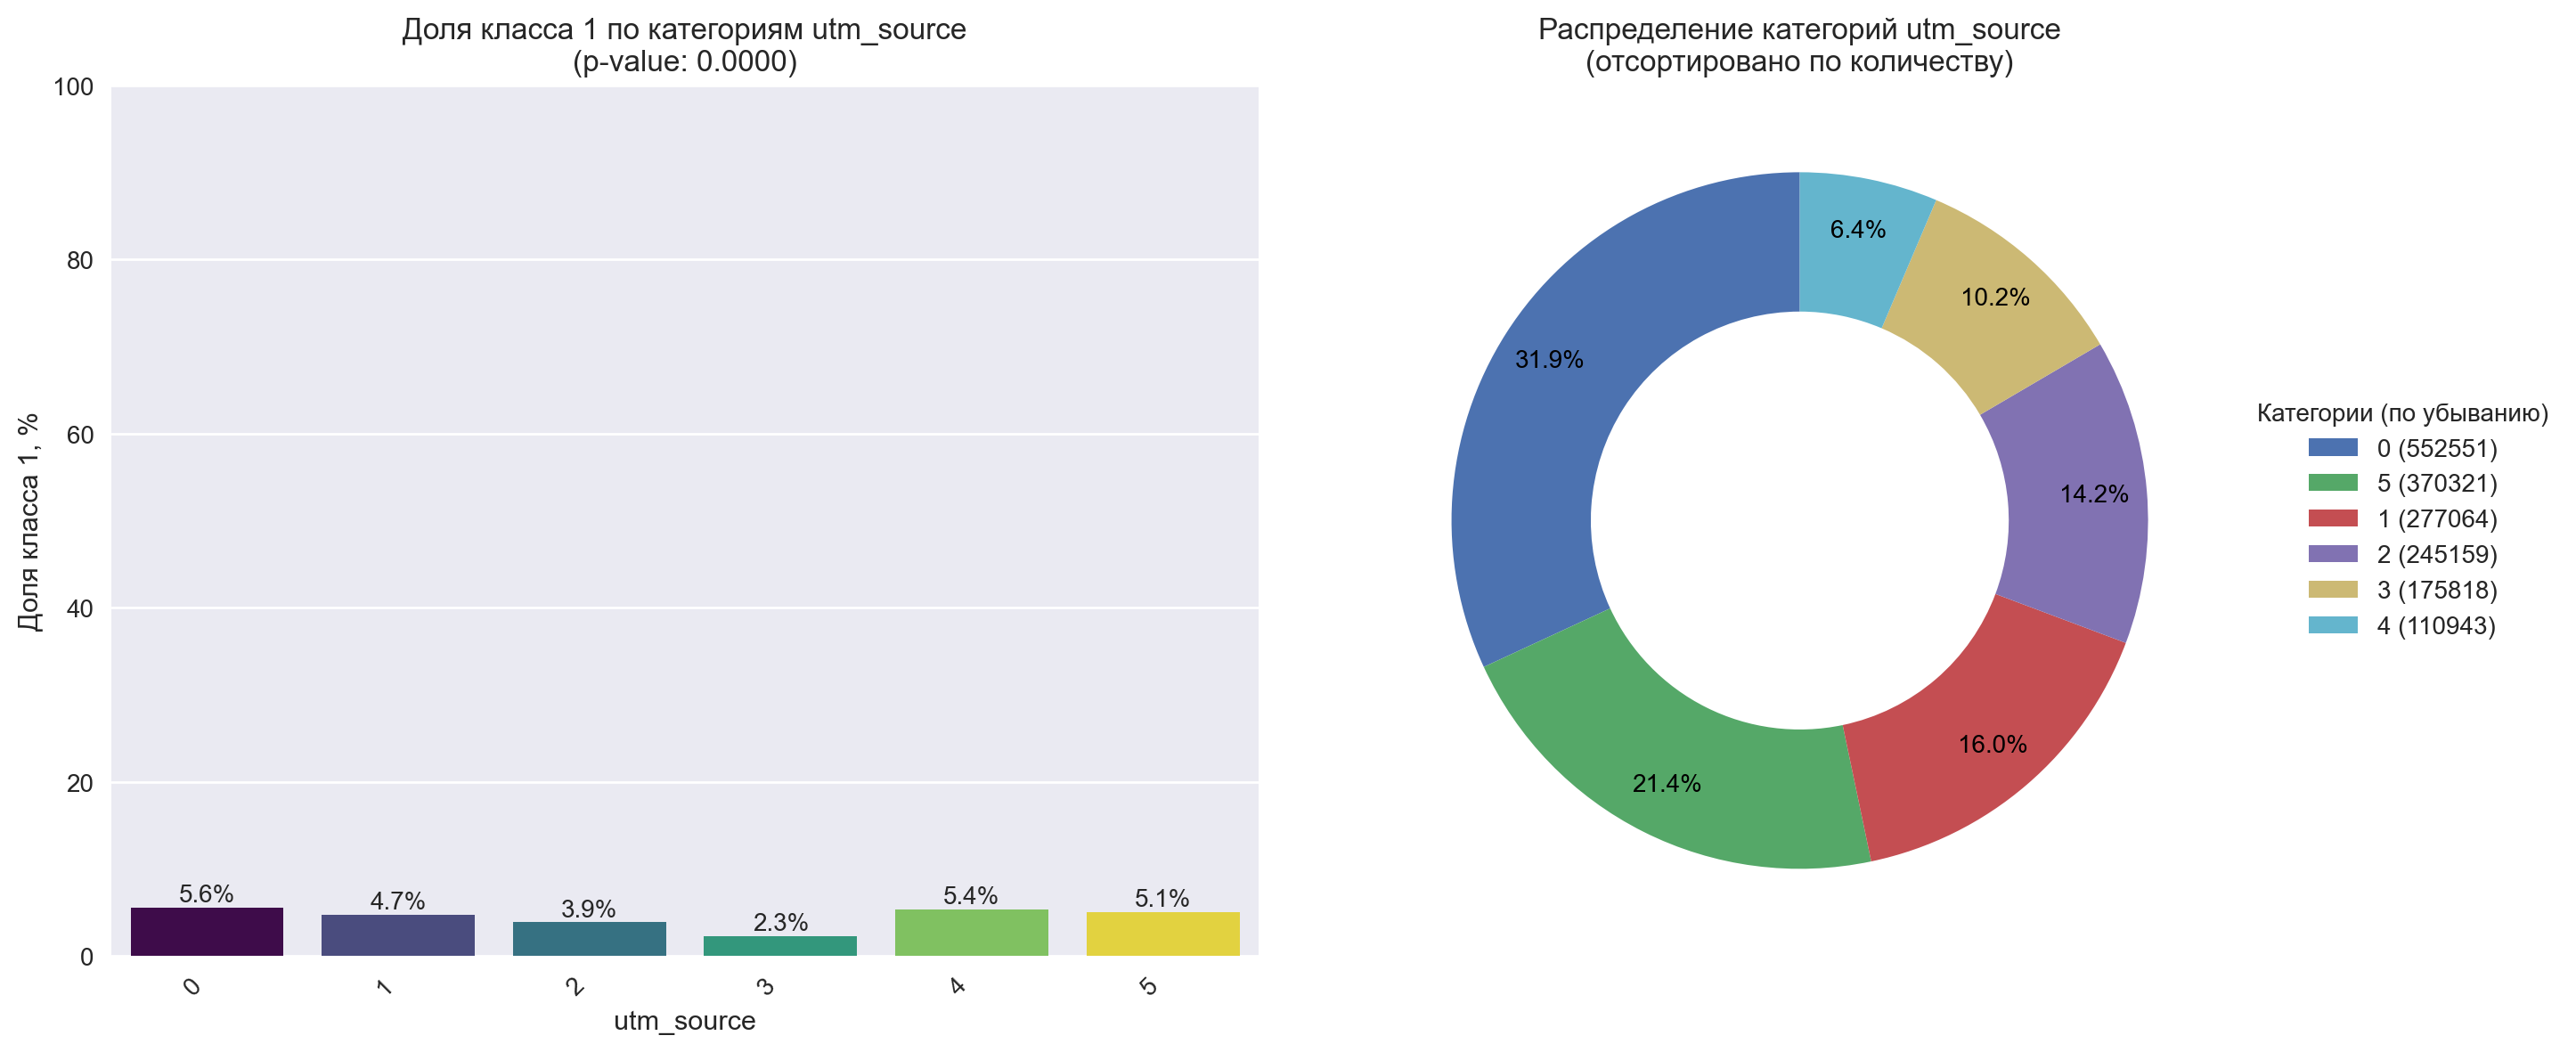

In [34]:
report = analyze_categorical_feature(df, 'utm_source', 'target')

При значениях признака равных 2 и 3 доля целевых действий минимальна, а при значениях 0,4,5 более 5%.

## Признак `utm_medium`

Тип привлечения.

In [35]:
df.utm_medium.value_counts()[:10]

utm_medium
banner             802270
cpc                399391
cpm                229825
referral           136850
organic             55008
email               28287
push                27710
stories             10472
cpv                  7815
blogger_channel      7731
Name: count, dtype: int64

Ситуация аналогична с предыдущим признаком. Оставим только ТОП-8, обозначив их, соответствено, от 0-7, а 8 - это все остальное.

In [36]:
# получаем топ-5 значений
top_8 = df['utm_medium'].value_counts()[:8].index.to_list()

# создаем словарь для замены: {старое_значение: новое_значение}
replace_dict = {value: idx for idx, value in enumerate(top_8)}

# заменяем значения: топ-8 на их индексы (0-7), остальные на 8
df['utm_medium'] = df['utm_medium'].map(replace_dict).fillna(8).astype(int)

Теперь проведем анализ признака.


📊 Анализ признака 'utm_medium' (уникальных значений: 9):
► Тест хи-квадрат: p-value = 0.0000 (значимо)
► Коэф. Крамера V (сила связи): 0.060

📈 Распределение таргета по категориям (по убыванию доли класса 1):


Общее_количество  Доля_от_общего_%  Частота_0  Частота_1  \
utm_medium                                                             
3                     136850              7.90     124186      12664   
4                      55008              3.18      51784       3224   
0                     802270             46.32     759377      42893   
5                      28287              1.63      27015       1272   
6                      27710              1.60      26478       1232   
8                      42043              2.43      40348       1695   
1                     399391             23.06     384669      14722   
2                     229825             13.27     225510       4315   
7                      10472              0.60      10362        110   

            Доля_класса_1_%  
utm_medium                   
3                      9.25  
4                      5.86  
0                      5.35  
5                      4.50  
6                      4.45  
8                      4.03  
1                      3.69  
2                      1.88  
7                      1.05

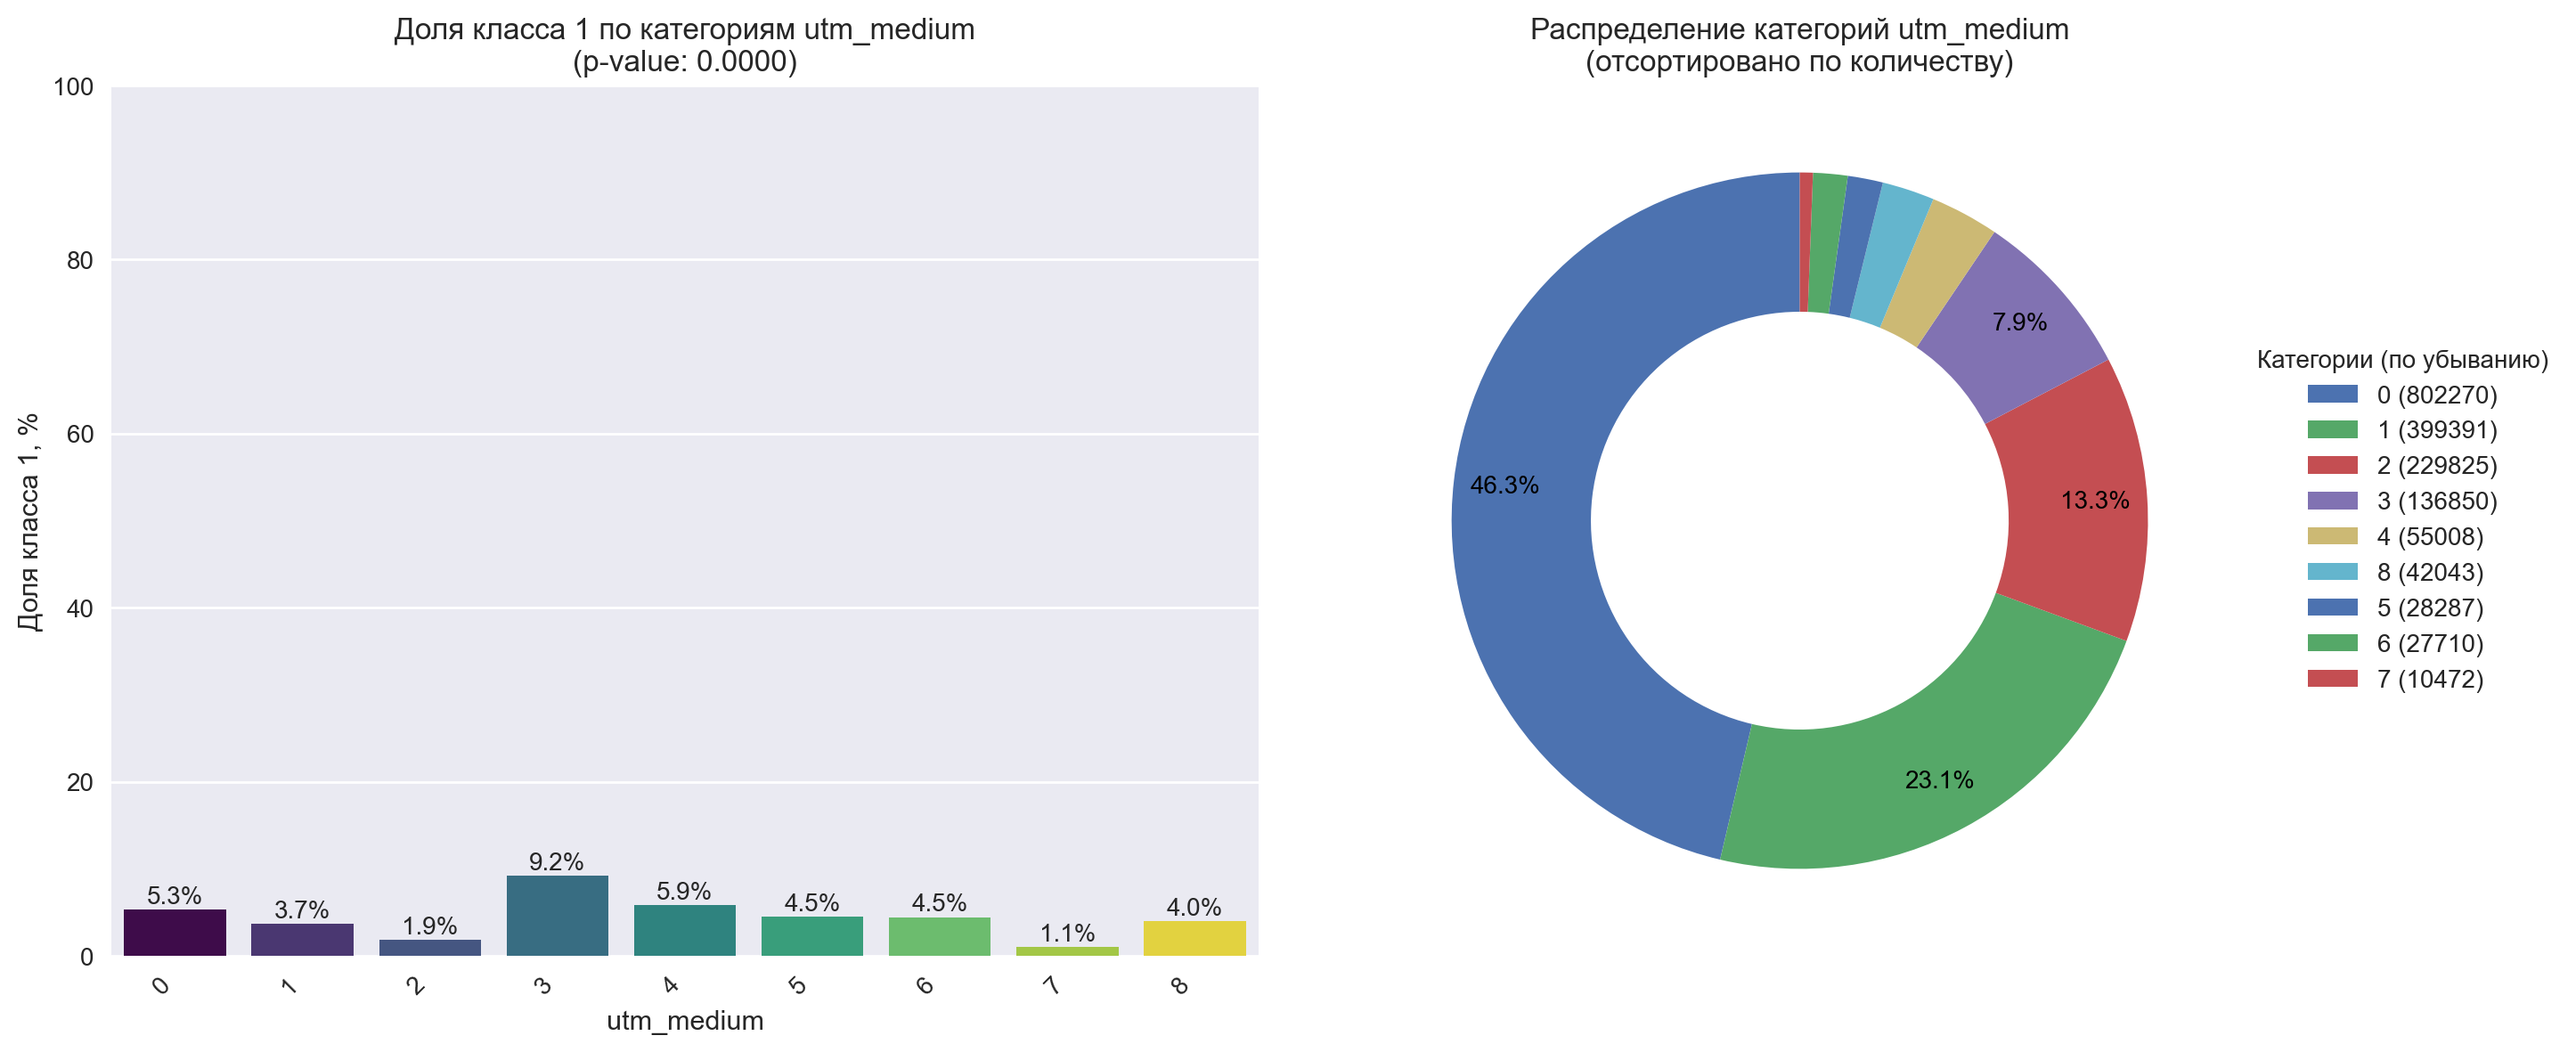

In [37]:
report = analyze_categorical_feature(df, 'utm_medium', 'target')

Минимальная доля целевых действий при значениях признака 7,2 и 1, максимальная доля целевых действий при значениях 0,4 и 3.

## Признак `device_category`

Категория устройства с которого выполнялась сессия.


📊 Анализ признака 'device_category' (уникальных значений: 3):
► Тест хи-квадрат: p-value = 0.0000 (значимо)
► Коэф. Крамера V (сила связи): 0.010

📈 Распределение таргета по категориям (по убыванию доли класса 1):


Общее_количество  Доля_от_общего_%  Частота_0  Частота_1  \
device_category                                                             
desktop                    346735             20.02     328185      18550   
tablet                      16696              0.96      15927        769   
mobile                    1368425             79.01    1305617      62808   

                 Доля_класса_1_%  
device_category                   
desktop                     5.35  
tablet                      4.61  
mobile                      4.59

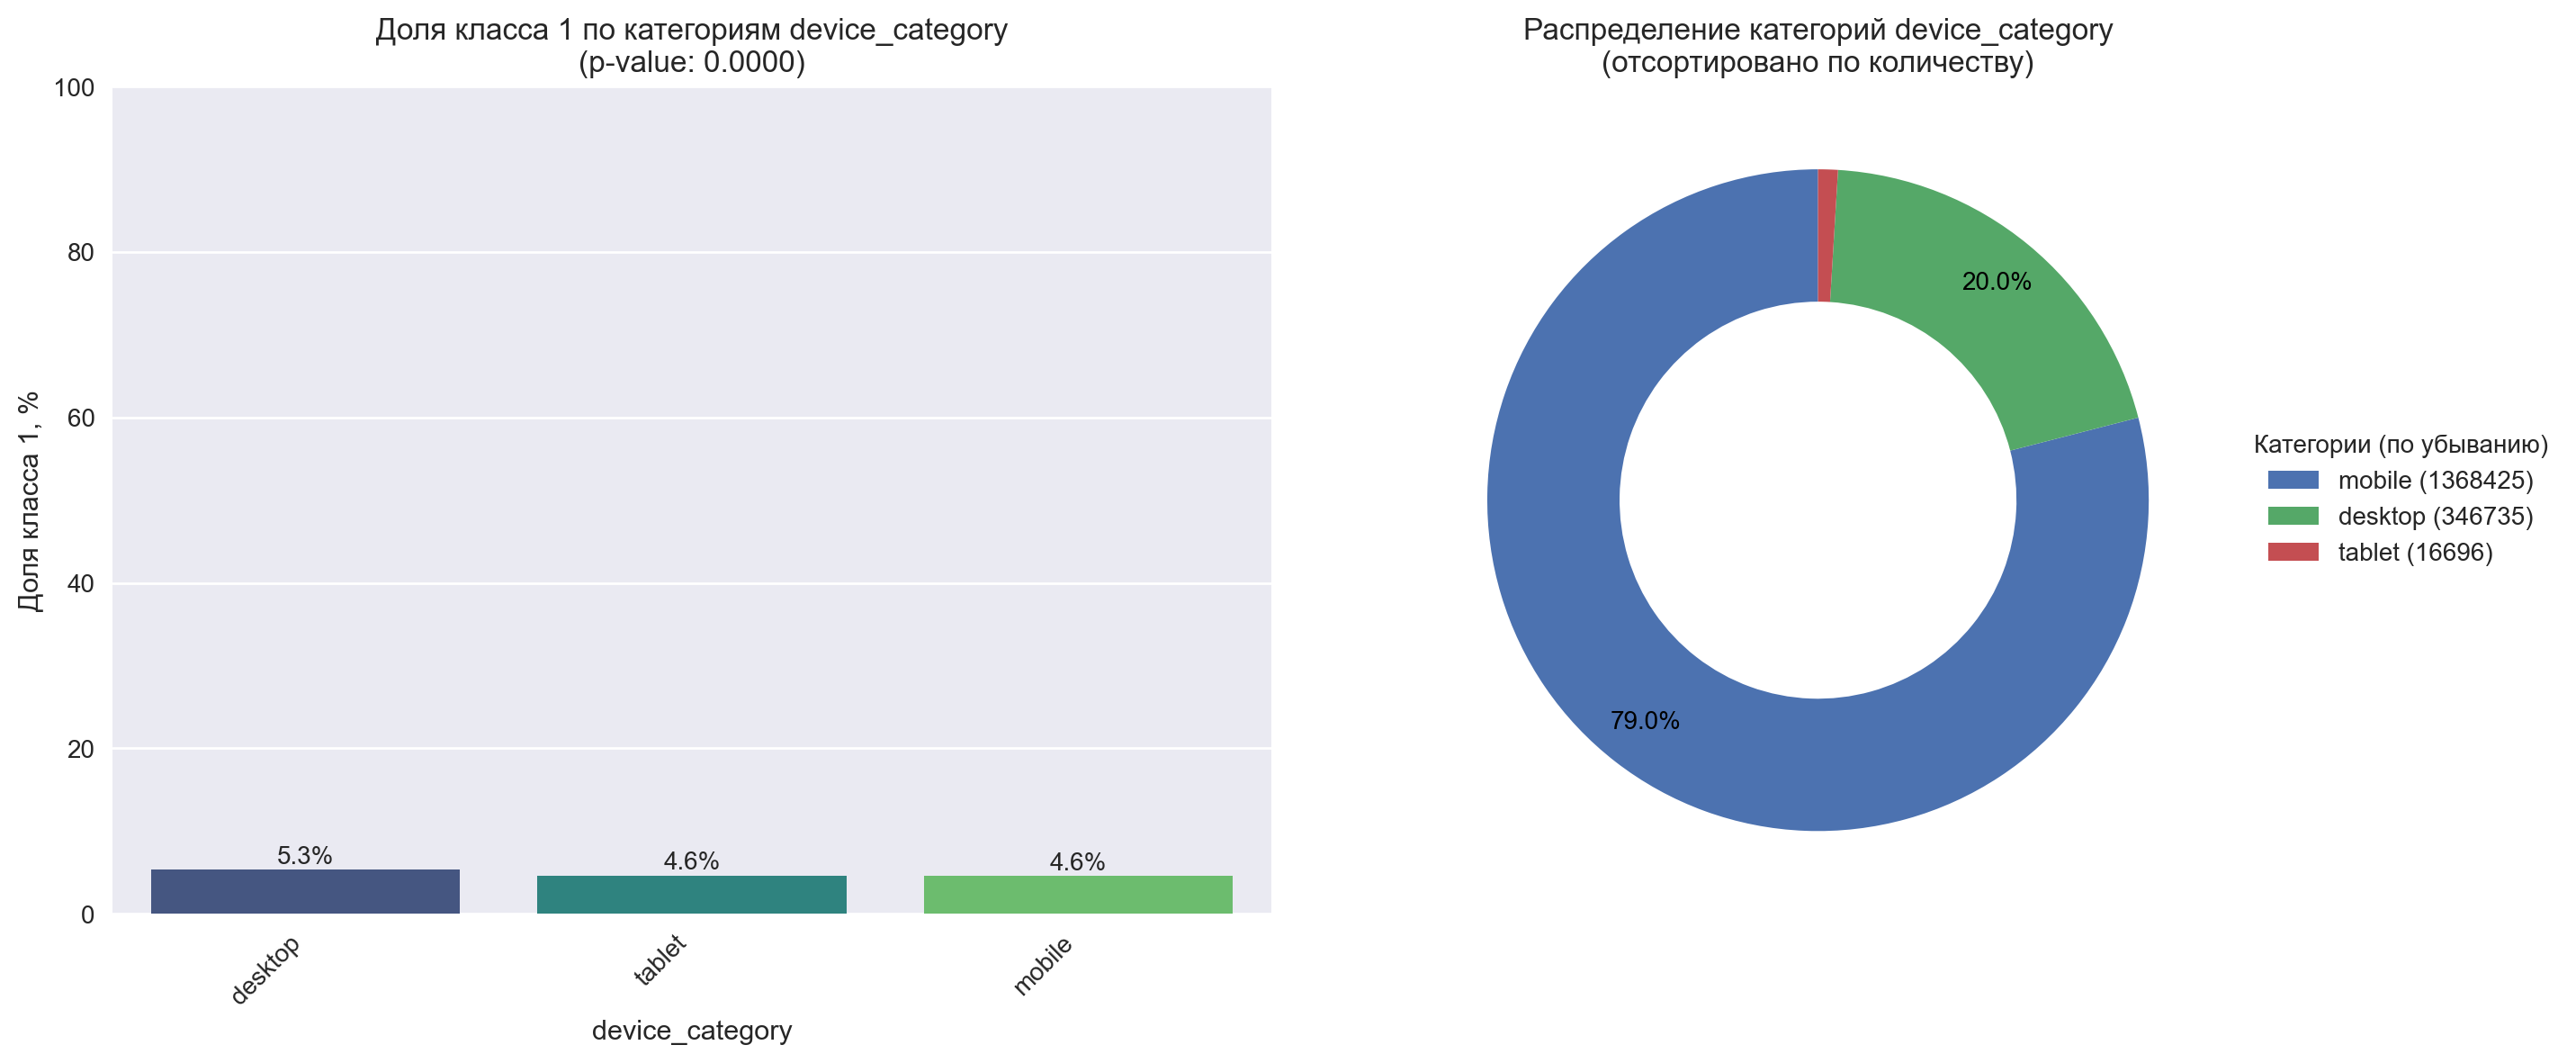

In [38]:
report = analyze_categorical_feature(df, 'device_category', 'target')

Доля значения *tablet* в признаке невелика, а доля целевых действий в нем такая же, как и в значении *mobile*. Объединим данные значения в одно - *mobile_device*. Доля целевых действий при значении *desktop* значимо выше, чем при других значениях.

In [39]:
df['device_category'] = df['device_category'].apply(lambda x: x if x=='desktop' else 'mobile_device')

## Признак `device_brand`

Марка устройства с которого выполнялась сессия.

In [40]:
# количество уникальных значений признака
df.device_brand.nunique()

201

In [41]:
df.device_brand.value_counts()[:20]

device_brand
apple        503365
unknown      347040
samsung      311612
xiaomi       269231
huawei       173795
realme        17926
(not set)     16391
oppo          12775
vivo          11026
oneplus        9319
asus           7487
nokia          6864
sony           6106
zte            5987
google         4472
meizu          3529
lenovo         2942
blackview      2592
tecno          2501
lg             2256
Name: count, dtype: int64

Видим неявные пропуски в виде значений *unknown* и *(not set)*. Также огромное количество значений данного признака (201). Выделим только следующие марки устройств (из топ-4 по количеству): *apple*, *samsung*, *xiaomi*, *huawei*. Всем остальным значениям присвоим *other*.

In [42]:
device_brands = ['apple','samsung','xiaomi','huawei']

df['device_brand'] = df['device_brand'].apply(lambda x: x if x in device_brands else 'other')

Теперь проведем анализ признака.


📊 Анализ признака 'device_brand' (уникальных значений: 5):
► Тест хи-квадрат: p-value = 0.0000 (значимо)
► Коэф. Крамера V (сила связи): 0.017

📈 Распределение таргета по категориям (по убыванию доли класса 1):


Общее_количество  Доля_от_общего_%  Частота_0  Частота_1  \
device_brand                                                             
samsung                 311612             17.99     295290      16322   
other                   473853             27.36     449169      24684   
huawei                  173795             10.04     165093       8702   
xiaomi                  269231             15.55     257097      12134   
apple                   503365             29.07     483080      20285   

              Доля_класса_1_%  
device_brand                   
samsung                  5.24  
other                    5.21  
huawei                   5.01  
xiaomi                   4.51  
apple                    4.03

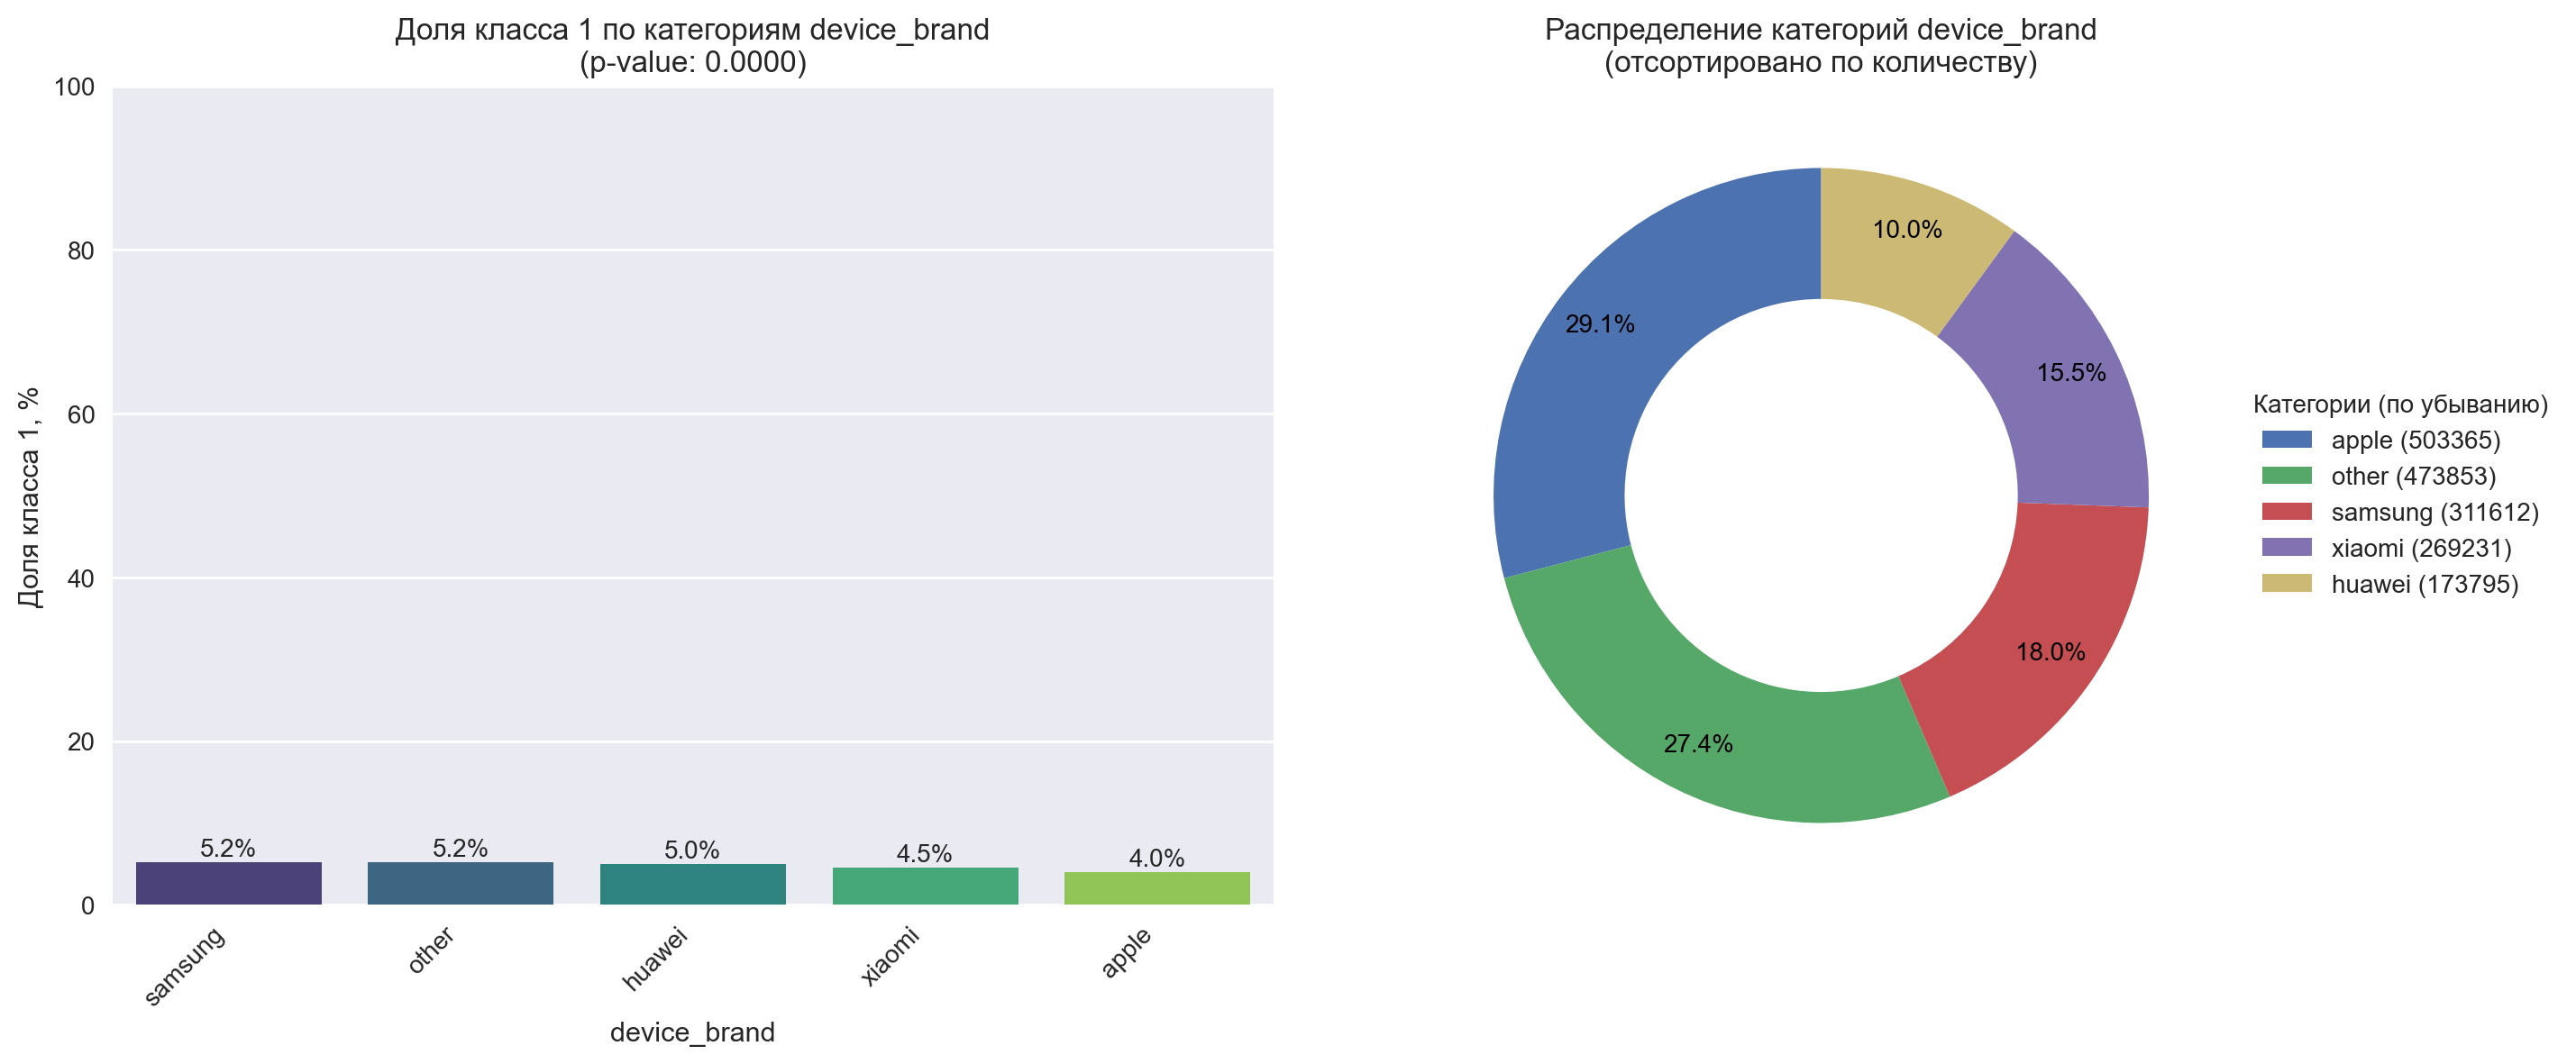

In [43]:
report = analyze_categorical_feature(df, 'device_brand', 'target')

Видно, что пользователи устройств *samsung*, *other* и *huawei* составляют более половины объема датасета, при этом доля целевых среди них превышает 5%. Пользователи устройств *apple* составляют почти 30% пользователей, однако доля целевых действий среди них минимальна.

## Признак `device_browser`

Браузер на устройстве через который пользователь заходил на сайт.

In [44]:
df.device_browser.value_counts()

device_browser
chrome                              951447
safari                              436547
yabrowser                           123710
safari (in-app)                      65952
android webview                      51919
samsung internet                     44266
opera                                25092
firefox                              15731
edge                                 15142
uc browser                             814
mozilla compatible agent               336
android runtime                        241
[fban                                  115
instagram 208.0.0.32.135 android        72
mrchrome                                72
instagram 209.0.0.21.119 android        49
android browser                         47
puffin                                  43
maxthon                                 30
internet explorer                       24
opera mini                              23
android                                 19
instagram 202.0.0.23.119               

Имеется небольшое количество неявных пропусков *(not set)*. Помимо стандартных названий браузеров (напимер, *chrome*, *safari* и т.д.) имеются названия, вроде *instagram 203.0.0.26.117* или *[fban* - это скорее всего браузеры приложений (Instagram и Facebok соответственно). Кроме того, есть дублирующие названия, например *safari* и *safari (in-app)* (причем *safari* используется только на дсктопных устройствах, а *safari* и *safari (in-app)* на мобильных). Кроме того, есть одинаковые браузеры, но с разным названием, например *mozilla* и *firefox*. Объединим данные названия браузеров в одно. Выберем ТОП-8 по количеству браузеров и оставим их, остальные обозначим за *other*.

In [45]:
browser_mapping = {
    # Объединяем Safari
    'safari (in-app)': 'safari',   
    # Объединяем Firefox/Mozilla
    'mozilla': 'firefox',    
    # Объединяем Android варианты
    'android webview': 'android',
    'android runtime': 'android', 
    'android browser': 'android'
}

# Применяем замену
df['device_browser'] = df['device_browser'].replace(browser_mapping)

In [46]:
browsers = df.device_browser.value_counts()[:8].index.to_list()

df['device_browser'] = df['device_browser'].apply(lambda x: x if x in browsers else 'other')

Теперь анализируем признак.


📊 Анализ признака 'device_browser' (уникальных значений: 9):
► Тест хи-квадрат: p-value = 0.0000 (значимо)
► Коэф. Крамера V (сила связи): 0.017

📈 Распределение таргета по категориям (по убыванию доли класса 1):


Общее_количество  Доля_от_общего_%  Частота_0  Частота_1  \
device_browser                                                               
firefox                      15747              0.91      14774        973   
edge                         15142              0.87      14283        859   
yabrowser                   123710              7.14     116990       6720   
chrome                      951447             54.94     903544      47903   
samsung internet             44266              2.56      42395       1871   
safari                      502499             29.02     481697      20802   
android                      52226              3.02      50176       2050   
opera                        25092              1.45      24173        919   
other                         1727              0.10       1697         30   

                  Доля_класса_1_%  
device_browser                     
firefox                      6.18  
edge                         5.67  
yabrowser                    5.43  
chrome                       5.03  
samsung internet             4.23  
safari                       4.14  
android                      3.93  
opera                        3.66  
other                        1.74

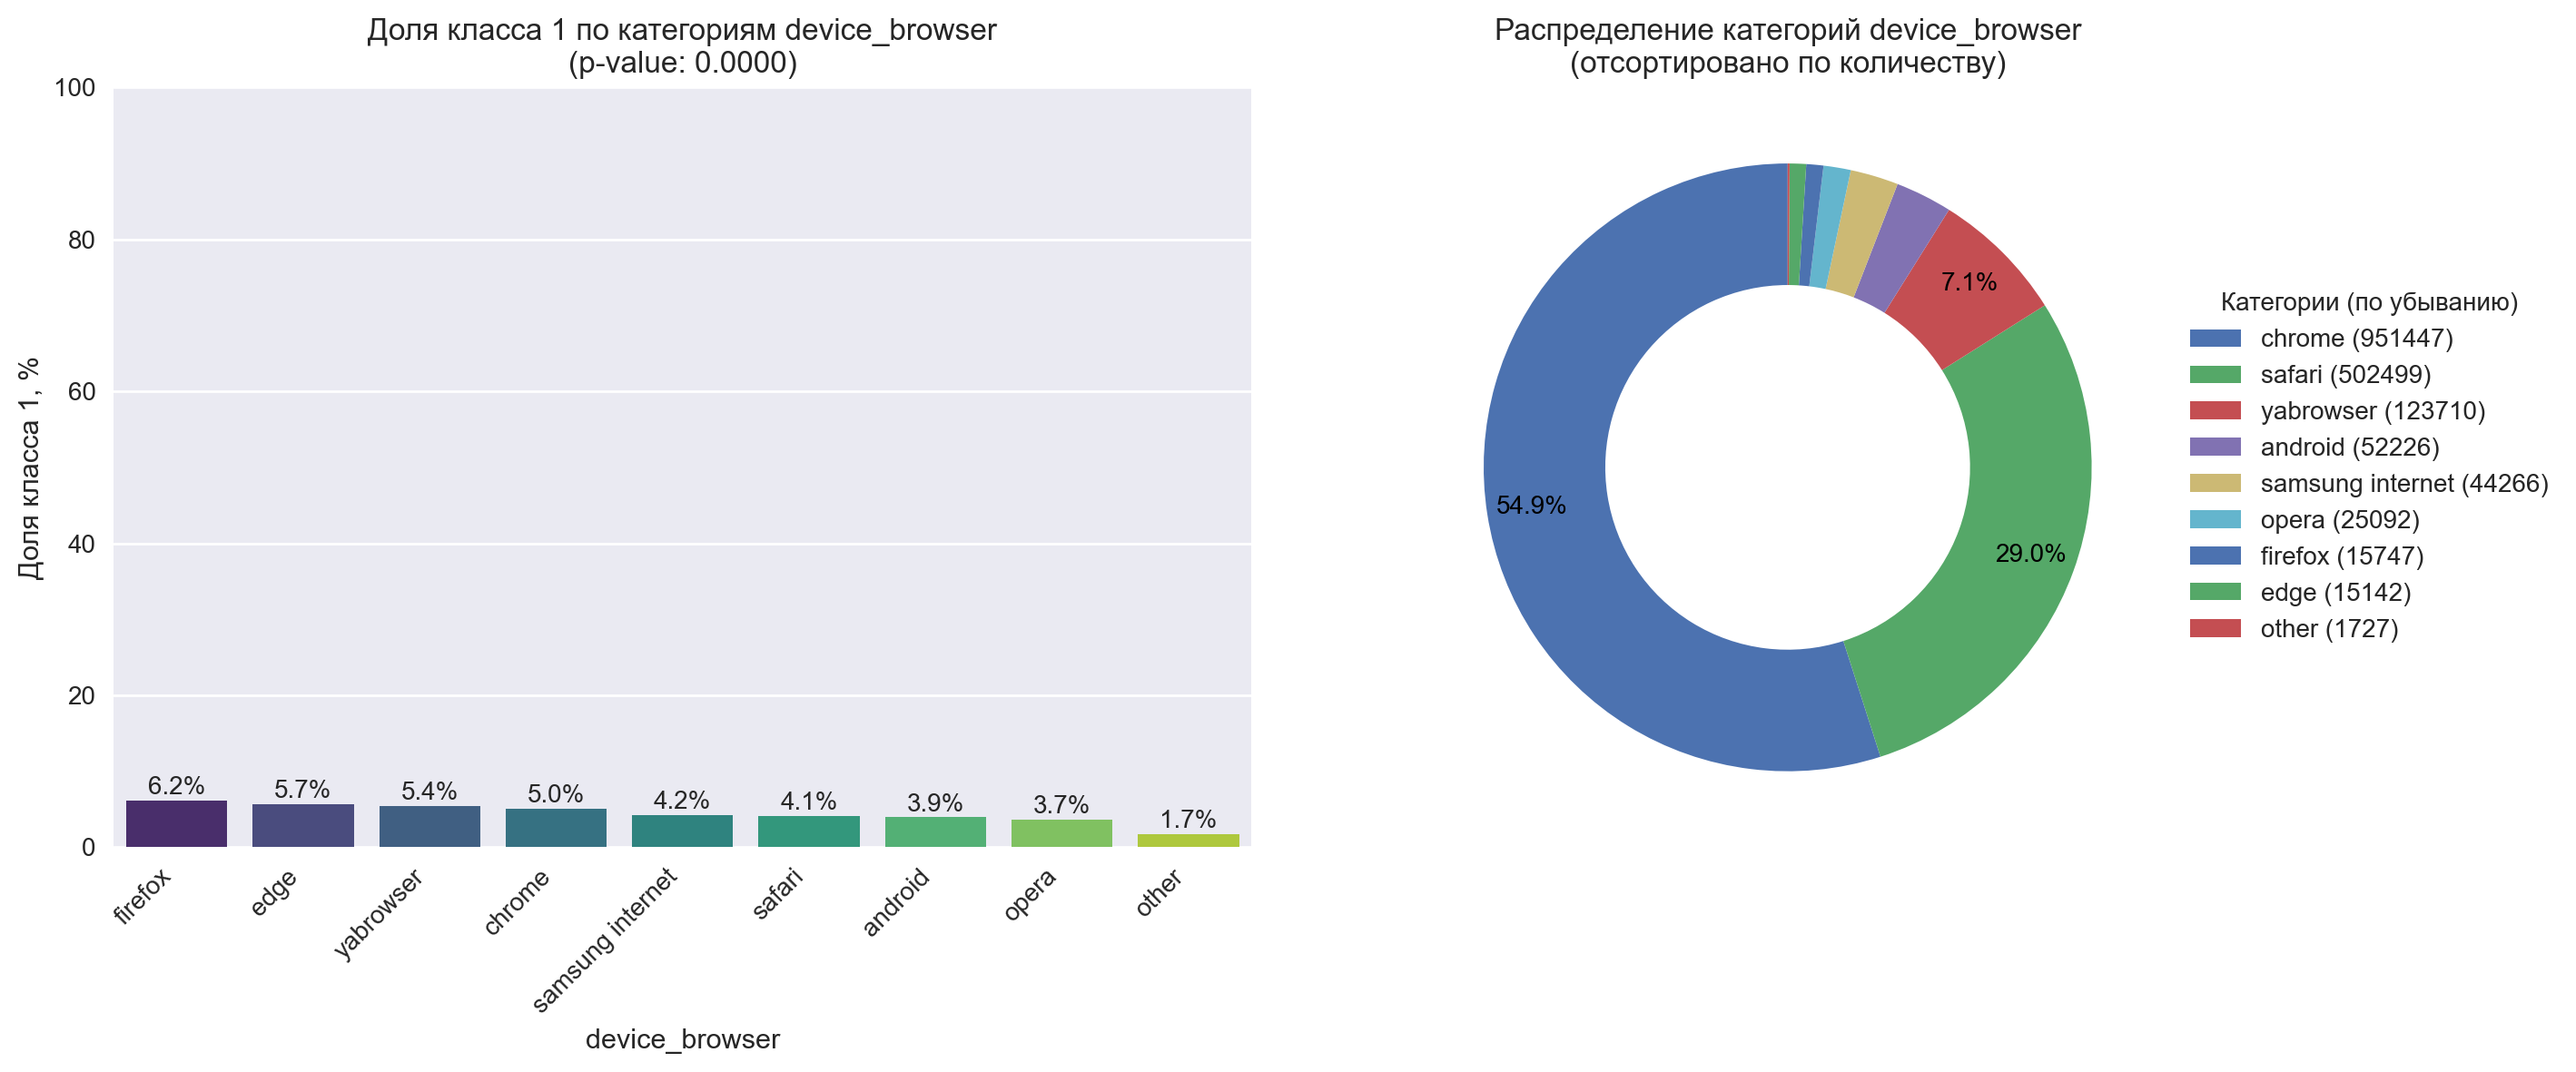

In [47]:
report = analyze_categorical_feature(df, 'device_browser', 'target')

Видно, что при использовании браузеров *firefox*, *edge*, *yabrowser*, *chrome* доля целевых действий в классе 1 более 5%, при этом суммарно данные с этими браузерами занимают более половины объема датасета. Хороший признак.

## Признак `aspect_ratio`

Соотношение сторон экрана устройства.

In [48]:
print('Количество уникальных значений ', df.aspect_ratio.nunique())
df.aspect_ratio.value_counts()[:20]

Количество уникальных значений  4341


aspect_ratio
16:9       206261
207:448    155086
393:851    107959
375:812    106925
9:16        96319
6:13        89071
375:667     86105
9:20        76005
412:915     70477
1:2         69066
8:5         63382
195:422     55365
131:291     48759
9:19        47496
103:223     41571
214:463     37065
683:384     31846
206:423     23726
412:869     23300
40:71       21514
Name: count, dtype: int64

Видно, что есть неявные дубликаты, например *16:9* и *9:16*. Избавимся от них.

In [49]:
def normalize_aspect_ratio(ratio):
    '''
    Функция избавляет от зеркальных дубликатов признак aspect_ratio
    '''
    try:
        # Разбиваем строку на части и преобразуем в числа
        a, b = map(int, ratio.split(':'))
        
        # Нормализуем соотношение (меньшее число всегда первое)
        return f"{min(a, b)}:{max(a, b)}" if a != b else ratio
    except (ValueError, AttributeError):
        # Обработка некорректных значений (NaN, строки без ':')
        return ratio

# Применяем функцию к столбцу
df['aspect_ratio'] = df['aspect_ratio'].apply(normalize_aspect_ratio)

In [50]:
print('Количество уникальных значений ', df.aspect_ratio.nunique())
df.aspect_ratio.value_counts()[:20]

Количество уникальных значений  4034


aspect_ratio
9:16       302580
207:448    155086
393:851    114516
375:812    106925
6:13        92401
375:667     86109
9:20        79749
1:2         72901
412:915     72456
5:8         65480
195:422     55365
131:291     50643
9:19        50094
103:223     42937
214:463     37065
384:683     31847
206:423     24458
412:869     24001
18:37       21585
40:71       21514
Name: count, dtype: int64

Помогло не сильно. Попробуем перевести данный признак из категориального в числовой, выполнив деление соотношения сторон.

In [51]:
def ratio_to_float(ratio):
    '''
    Функция выполняет вычисление соотношения сторон в признаке aspect_ratio,
    переводя признак в числовой
    '''
    try:
        # Разделяем строку по двоеточию и преобразуем в числа
        width, height = map(float, ratio.split(':'))
        return round(width / height, 4)  # Округляем до 4 знаков
    except:
        return None  # Для некорректных значений

df['aspect_ratio'] = df['aspect_ratio'].apply(ratio_to_float)

Проводим анализ измененного признака.


📊 Анализ признака 'aspect_ratio':
► Размер эффекта (разность средних): -0.0002
► t-тест Уэлча: p-value = 0.3159 (не значимо)
► Коэф. Коэна d: -0.003 (малый)

📈 Основные статистики:


count      mean       std     min     25%     50%     75%     max
Класс 0  1649729.0  0.505342  0.071505  0.0800  0.4618  0.4622  0.5625  1.0000
Класс 1    82127.0  0.505111  0.064143  0.2812  0.4618  0.4622  0.5625  0.8875

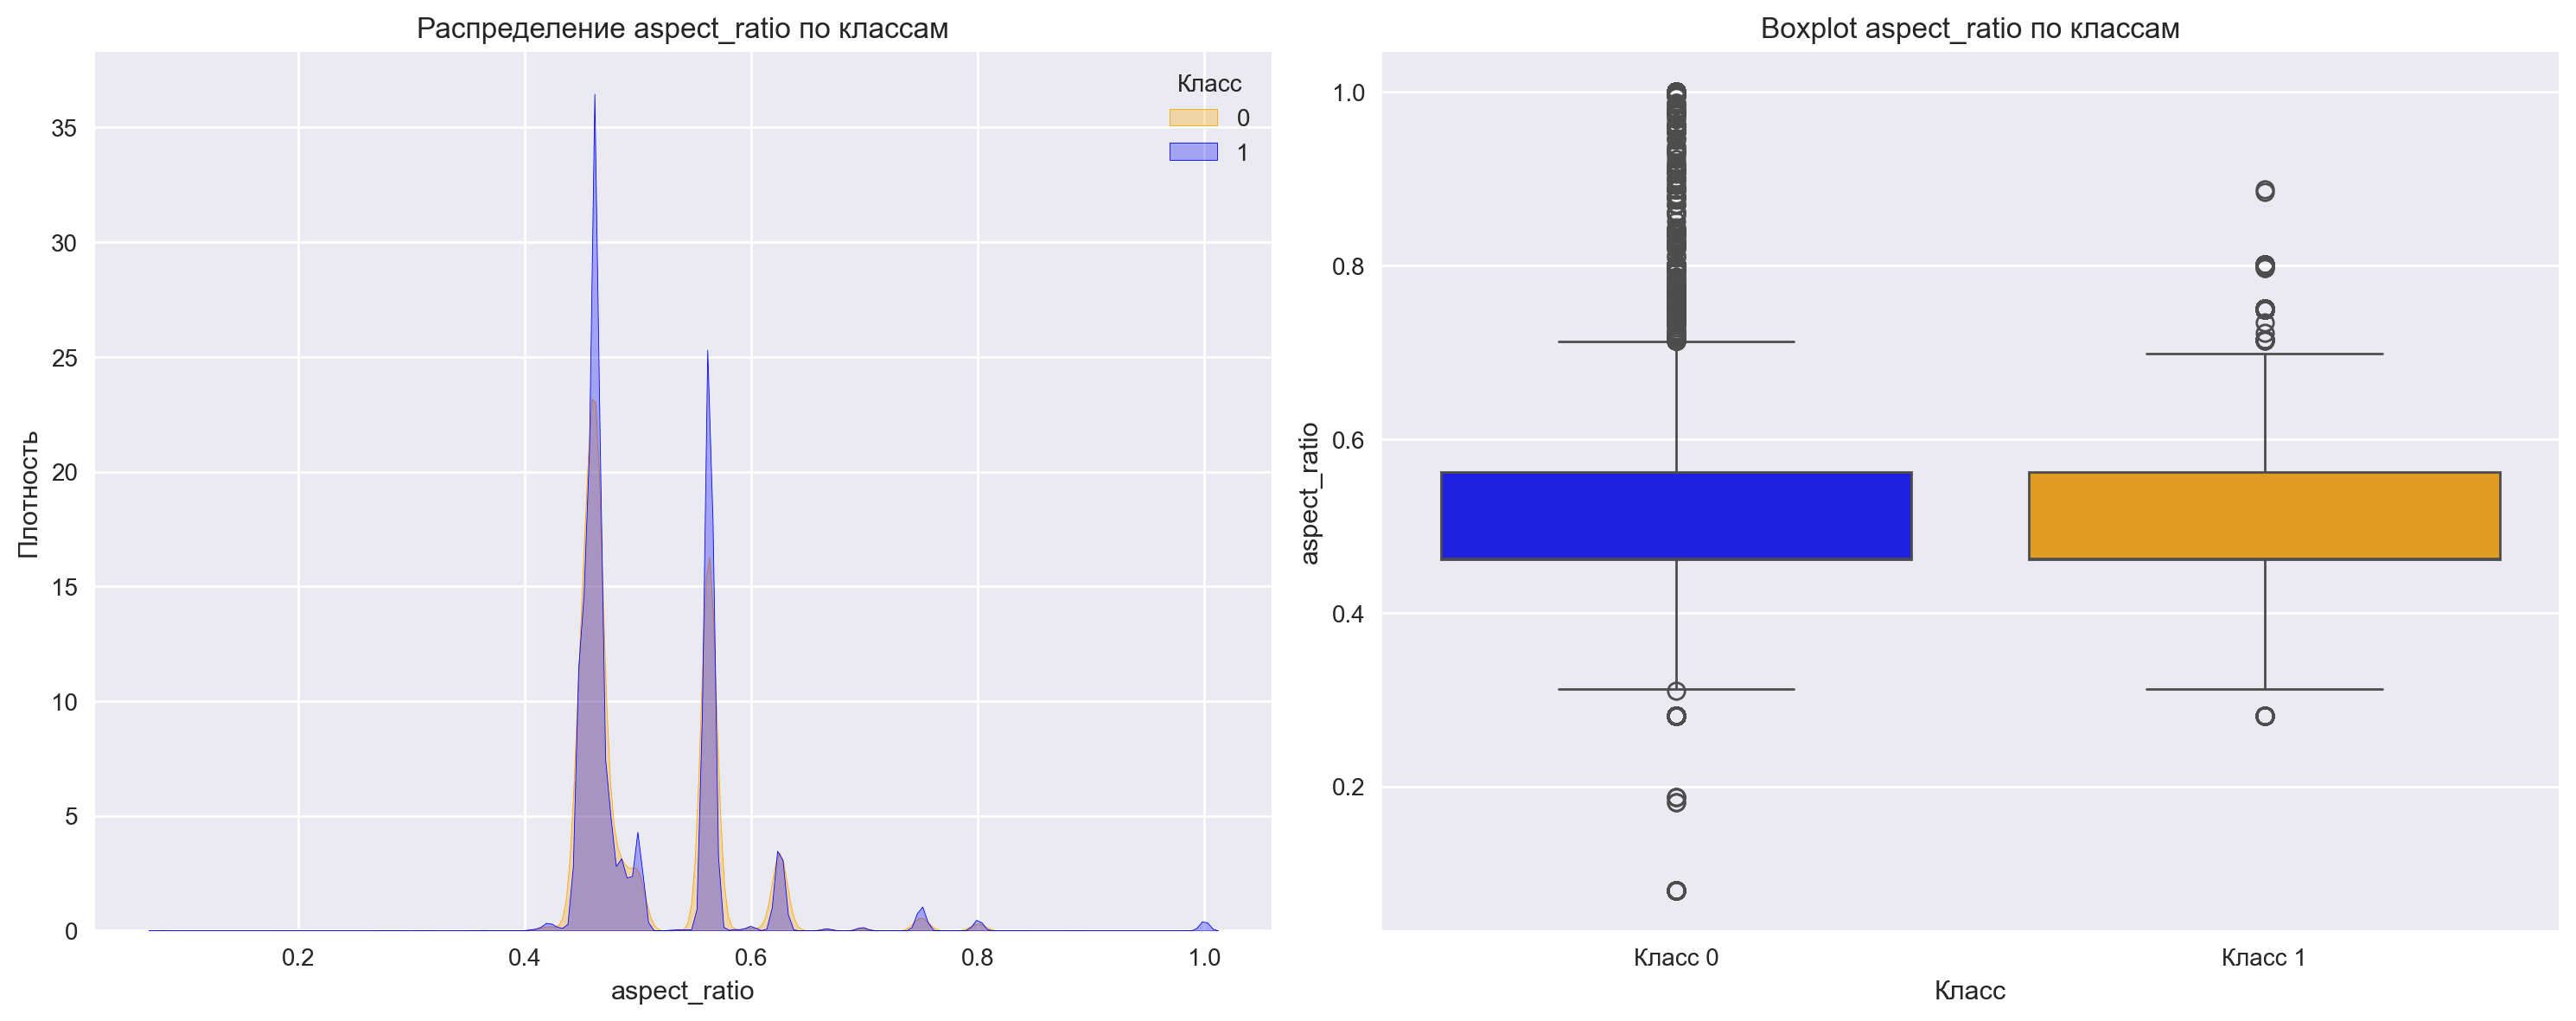

In [52]:
report = analyze_numeric_feature(df, 'aspect_ratio', 'target')

Разницы нет, также нет существенной разницы, если применять маску по значениям признака `device_category`. Удаляем.

In [53]:
df.drop(['aspect_ratio'], axis=1, inplace=True)

## Признак `geo_country`

Страна откуда пришел на сайт пользователь.

In [54]:
print('Количество уникальных значений ', df.geo_country.nunique())
df.geo_country.value_counts()[:20]

Количество уникальных значений  159


geo_country
russia            1682019
ukraine              8455
united states        8140
belarus              3432
kazakhstan           2108
germany              2084
ireland              1989
turkey               1787
sweden               1731
netherlands          1451
uzbekistan           1422
united kingdom       1370
(not set)            1070
kyrgyzstan            926
georgia               881
france                742
cyprus                706
armenia               629
finland               610
spain                 548
Name: count, dtype: int64

Есть неявные пропуски *(not set)*, но число их невелико. Подавляющее количество пользователей из России. Разделим значения данного признака *на russia* и *no_russia*

In [55]:
df['geo_country'] = df['geo_country'].apply(lambda x: x if x=='russia' else 'no_russia')

Тепереь проанализируем обновленный признак.


📊 Анализ признака 'geo_country' (уникальных значений: 2):
► Тест хи-квадрат: p-value = 0.0000 (значимо)
► Коэф. Крамера V (сила связи): 0.007

📈 Распределение таргета по категориям (по убыванию доли класса 1):


Общее_количество  Доля_от_общего_%  Частота_0  Частота_1  \
geo_country                                                             
russia                1682019             97.12    1601658      80361   
no_russia               49837              2.88      48071       1766   

             Доля_класса_1_%  
geo_country                   
russia                  4.78  
no_russia               3.54

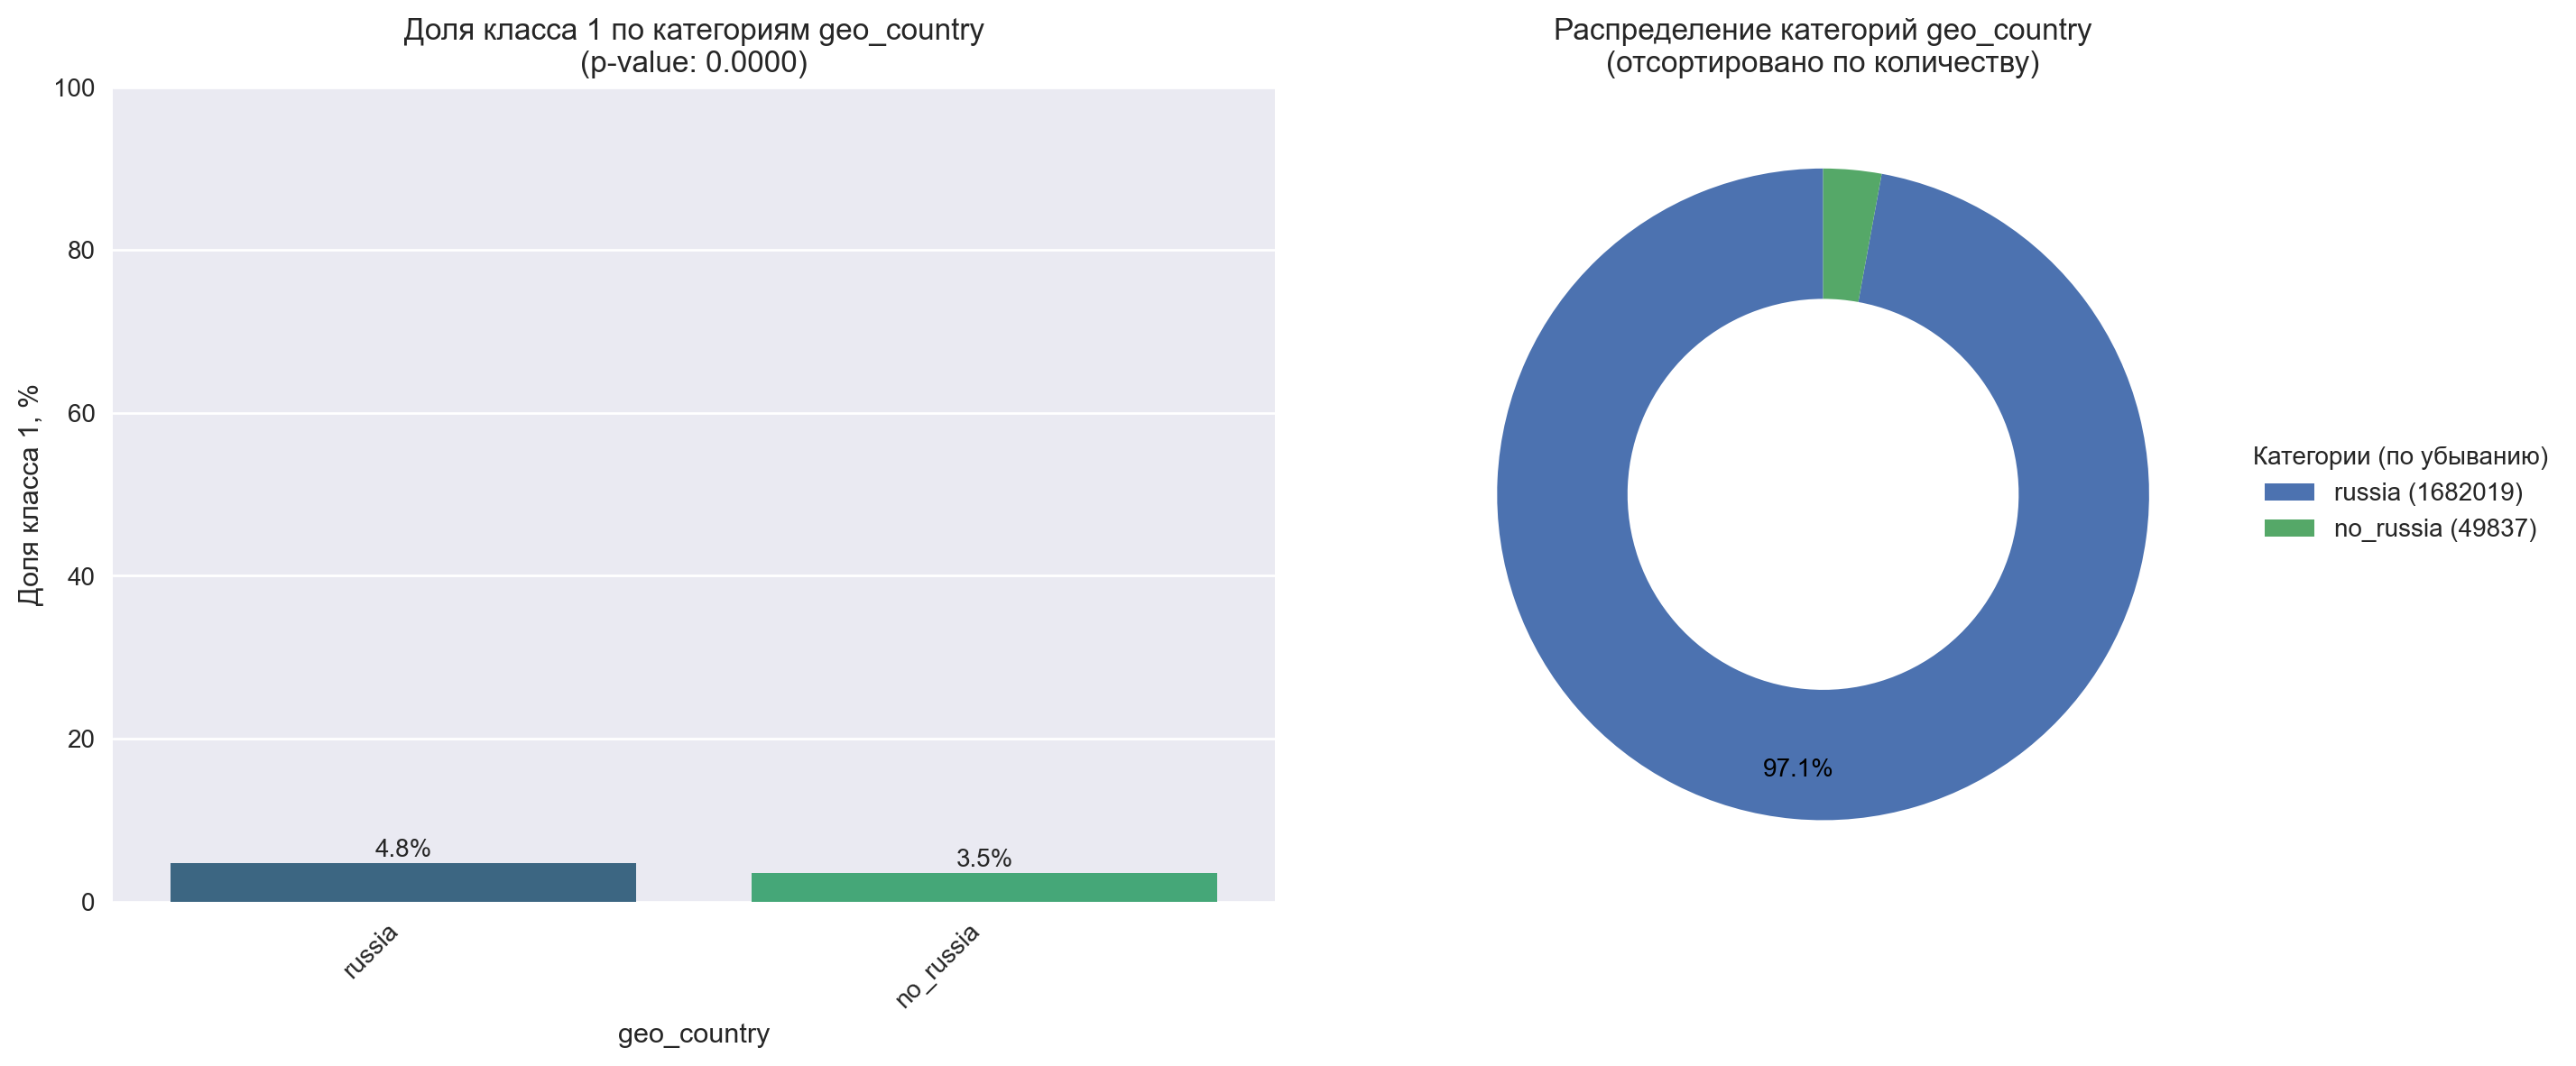

In [56]:
report = analyze_categorical_feature(df, 'geo_country', 'target')

Доля целевых действий пользователей из России все же выше, чем зарубежных пользователей.

## Признак `geo_city`

Город из которого на сайт зашел пользователь.

In [57]:
print('Количество уникальных значений ', df.geo_city.nunique())
df.geo_city.value_counts()[:20]

Количество уникальных значений  2389


geo_city
moscow              750717
saint petersburg    278326
(not set)            73287
yekaterinburg        33552
krasnodar            30257
kazan                27686
samara               23429
nizhny novgorod      20765
ufa                  20280
novosibirsk          20109
krasnoyarsk          15283
chelyabinsk          14920
tula                 14770
rostov-on-don        13062
voronezh             12701
irkutsk              12595
grozny               11949
balashikha           11863
vladivostok          11512
yaroslavl             9143
Name: count, dtype: int64

Города в основном российские, что логично, учитывая значения признака `geo_country`. В подавляющем большинстве пользователи приходят из Москвы и Санкт-Петербурга. На 3-м месте по количеству - неявные пропуски *(not set)*. Оставим значения *moscow* и *saint petersburg*, остальные значения признака будут *other*.

In [58]:
top_2_citys = ['moscow','saint petersburg']

df['geo_city'] = df['geo_city'].apply(lambda x: x if x in top_2_citys else 'other')

Теперь проанализируем обновленный признак.


📊 Анализ признака 'geo_city' (уникальных значений: 3):
► Тест хи-квадрат: p-value = 0.0000 (значимо)
► Коэф. Крамера V (сила связи): 0.013

📈 Распределение таргета по категориям (по убыванию доли класса 1):


Общее_количество  Доля_от_общего_%  Частота_0  Частота_1  \
geo_city                                                                     
other                       702813             40.58     666441      36372   
moscow                      750717             43.35     716626      34091   
saint petersburg            278326             16.07     266662      11664   

                  Доля_класса_1_%  
geo_city                           
other                        5.18  
moscow                       4.54  
saint petersburg             4.19

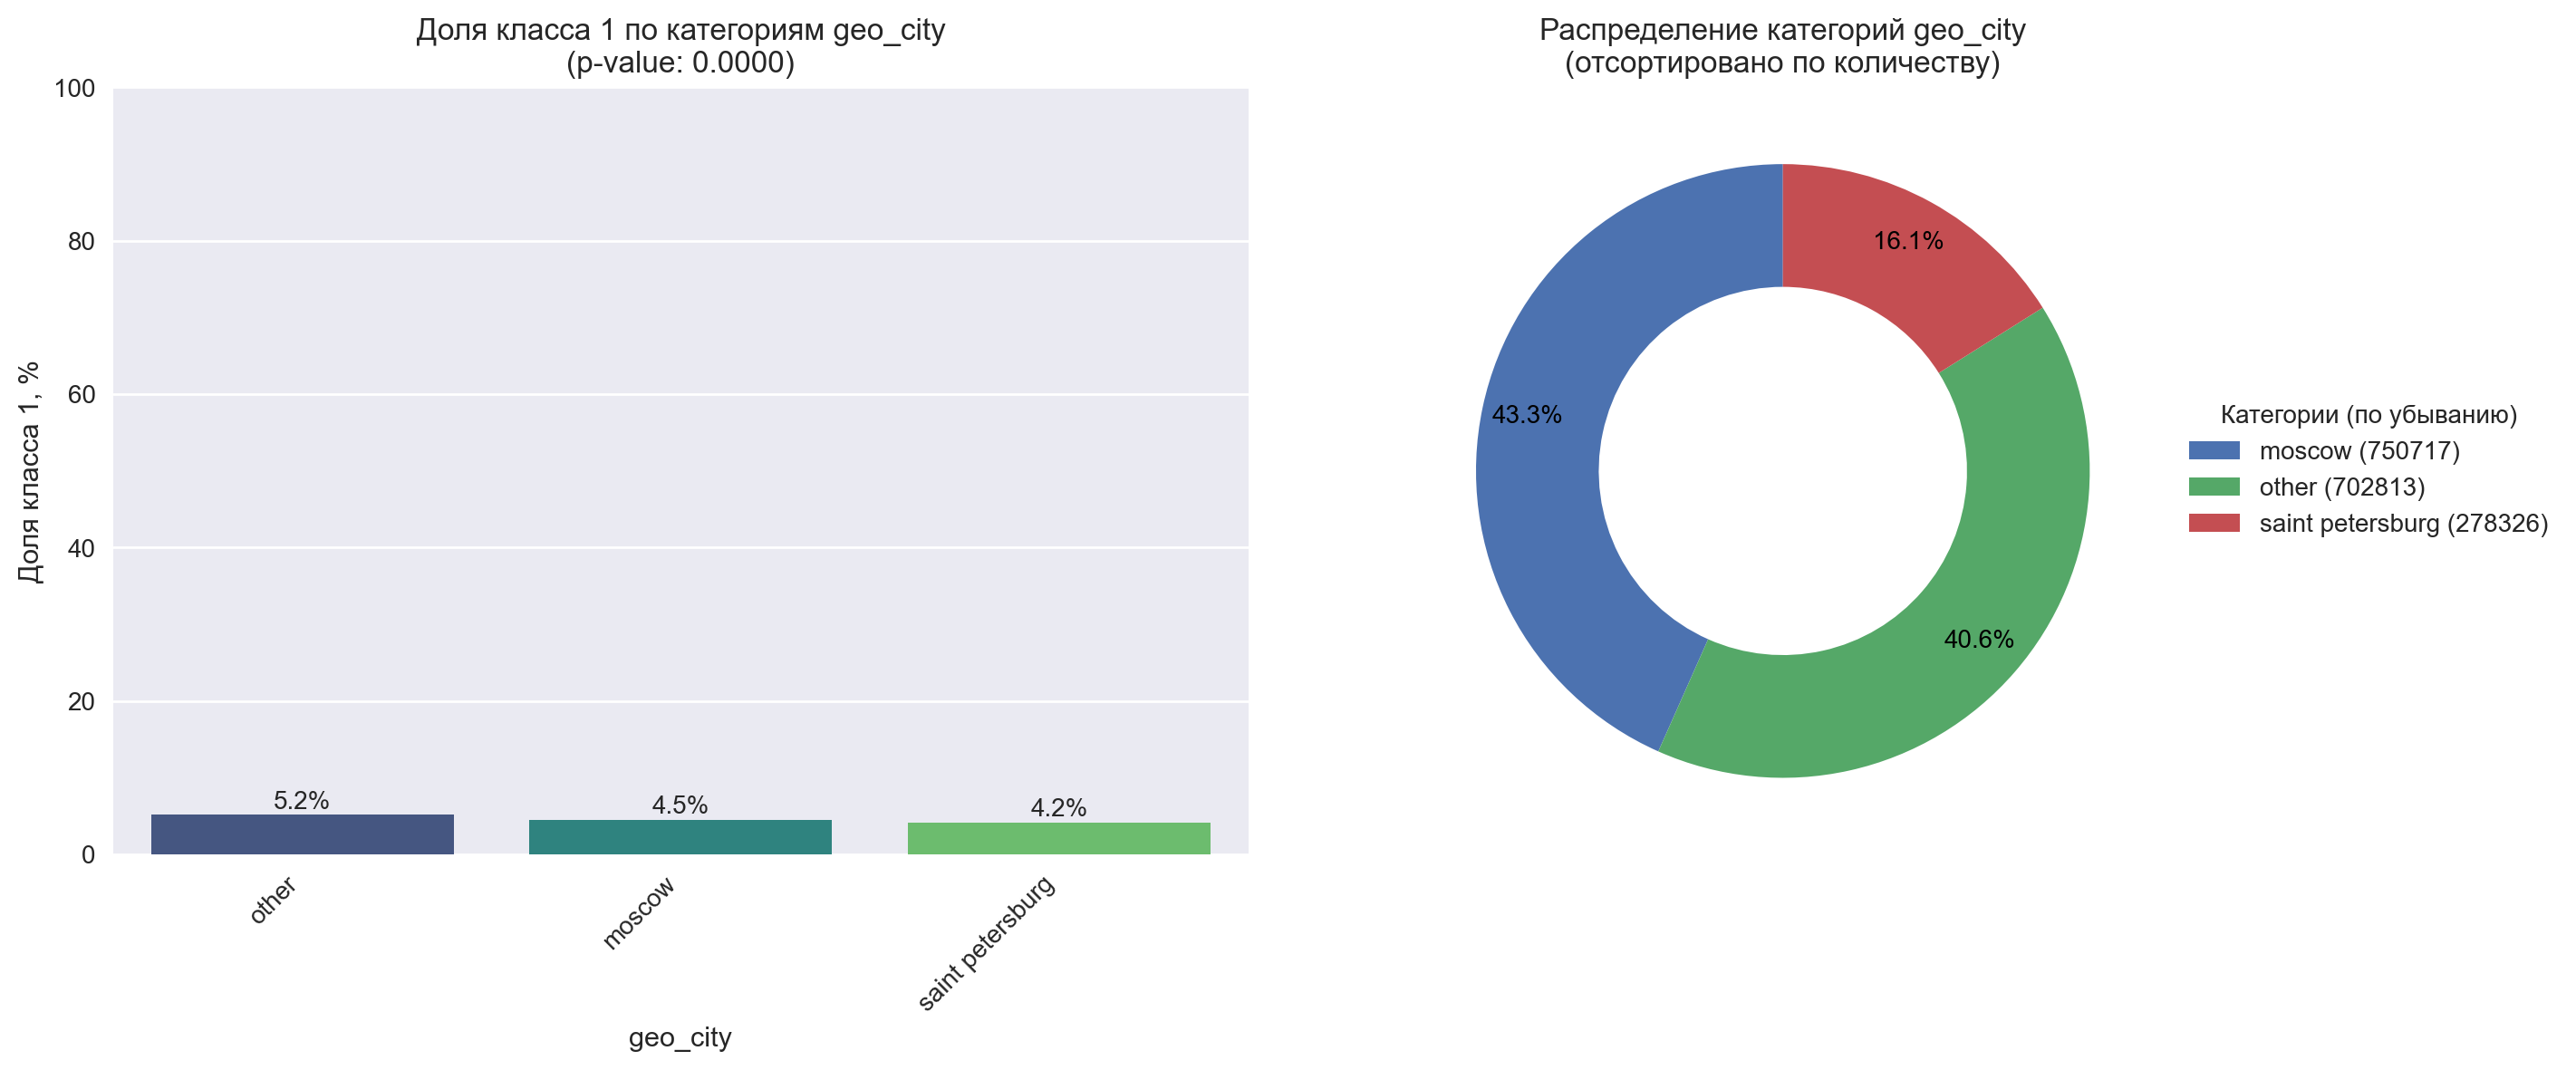

In [59]:
report = analyze_categorical_feature(df, 'geo_city', 'target')

И.. интересная получается картина - в других городах (не столицах) пользователи чаще выполняют целевые действия. При этом доля таких данных - 40.6% от объема датасета. Неожиданно. 

## Создание новых признаков

Создадим новые признаки на основе значимых сочетаний значений существующих категориальных признаков.      
Критерии создания новых признаков:
- доля класса 1 в полученной выборке более 7%
- доля полученной выборки более 10% от объема датасета

In [60]:
def find_valuable_combinations(df, cat_features, target='target', 
                             min_target_share=0.07, min_size_share=0.1):
    """
    Функция находит значимые сочетания категориальных признаков
    
    Параметры:
    - df: DataFrame с данными
    - cat_features: список категориальных признаков
    - target: имя целевой переменной
    - min_target_share: минимальная доля класса 1 в сочетании
    - min_size_share: минимальная доля данных от общего объема
    
    Возвращает:
    - Датафрейм значимых сочетаний и их статистику
    """
    
    valuable_combinations = []
    total_size = len(df)
    
    # Перебираем все возможные пары признаков
    for feature1, feature2 in tqdm(list(combinations(cat_features, 2))):
        # Создаем временный комбинированный признак
        temp_feature = df[feature1].astype(str) + "_" + df[feature2].astype(str)
        
        # Считаем статистику для каждого сочетания
        stats = df.groupby(temp_feature)[target].agg(['size', 'mean'])
        stats = stats[(stats['mean'] > min_target_share) & 
                     (stats['size'] > min_size_share * total_size)]
        
        if not stats.empty:
            # Добавляем информацию о сочетании
            for combo in stats.index:
                combo_data = {
                    'feature1': feature1,
                    'feature2': feature2,
                    'combination': combo,
                    'target_share': stats.loc[combo, 'mean'],
                    'size': stats.loc[combo, 'size'],
                    'size_share': stats.loc[combo, 'size'] / total_size
                }
                valuable_combinations.append(combo_data)
    
    # вывод полученных даных
    print('\n*** Полученные сочетания признаков ***')
    display(pd.DataFrame(valuable_combinations))
    
    return pd.DataFrame(valuable_combinations)

In [61]:
# категориальные признаки
cat_features = df.nunique()[3:].index.to_list()

# находим значимые сочетания признаков
valuable_combos = find_valuable_combinations(df, cat_features)

100%|██████████| 66/66 [00:25<00:00,  2.60it/s]


*** Полученные сочетания признаков ***


feature1         feature2      combination  target_share    size  \
0  top_car_brand     visit_number            1_1.0      0.084024  200836   
1  top_car_brand  device_category  1_mobile_device      0.086381  221680   
2  top_car_brand      geo_country         1_russia      0.086192  274131   
3    geo_country            month        russia_10      0.071819  253583   

   size_share  
0    0.115966  
1    0.128001  
2    0.158287  
3    0.146423

In [62]:
# создаем новые бинарные признаки на основе найденных значимых сочетаний
for _, row in valuable_combos.iterrows():
    # формируем имя нового признака
    combo_name = f"{row['feature1']}_{row['feature2']}_{row['combination'].replace(':', '_').replace(' ', '_')}"
    
    # создаем бинарный признак (1 для значимого сочетания, 0 для остальных)
    df[combo_name] = np.where(
        (df[row['feature1']].astype(str) + "_" + df[row['feature2']].astype(str)) == row['combination'],
        1,  # Значимое сочетание
        0   # Все остальные случаи
    ).astype(int)
    

Для примера выведем анализ одного из полученных новых признаков.


📊 Анализ признака 'top_car_brand_device_category_1_mobile_device' (уникальных значений: 2):
► Тест хи-квадрат: p-value = 0.0000 (значимо)
► Коэф. Крамера V (сила связи): 0.050

📈 Распределение таргета по категориям (по убыванию доли класса 1):


Общее_количество  \
top_car_brand_device_category_1_mobile_device                     
1                                                        221680   
0                                                       1510176   

                                               Доля_от_общего_%  Частота_0  \
top_car_brand_device_category_1_mobile_device                                
1                                                          12.8     202531   
0                                                          87.2    1447198   

                                               Частота_1  Доля_класса_1_%  
top_car_brand_device_category_1_mobile_device                              
1                                                  19149             8.64  
0                                                  62978             4.17

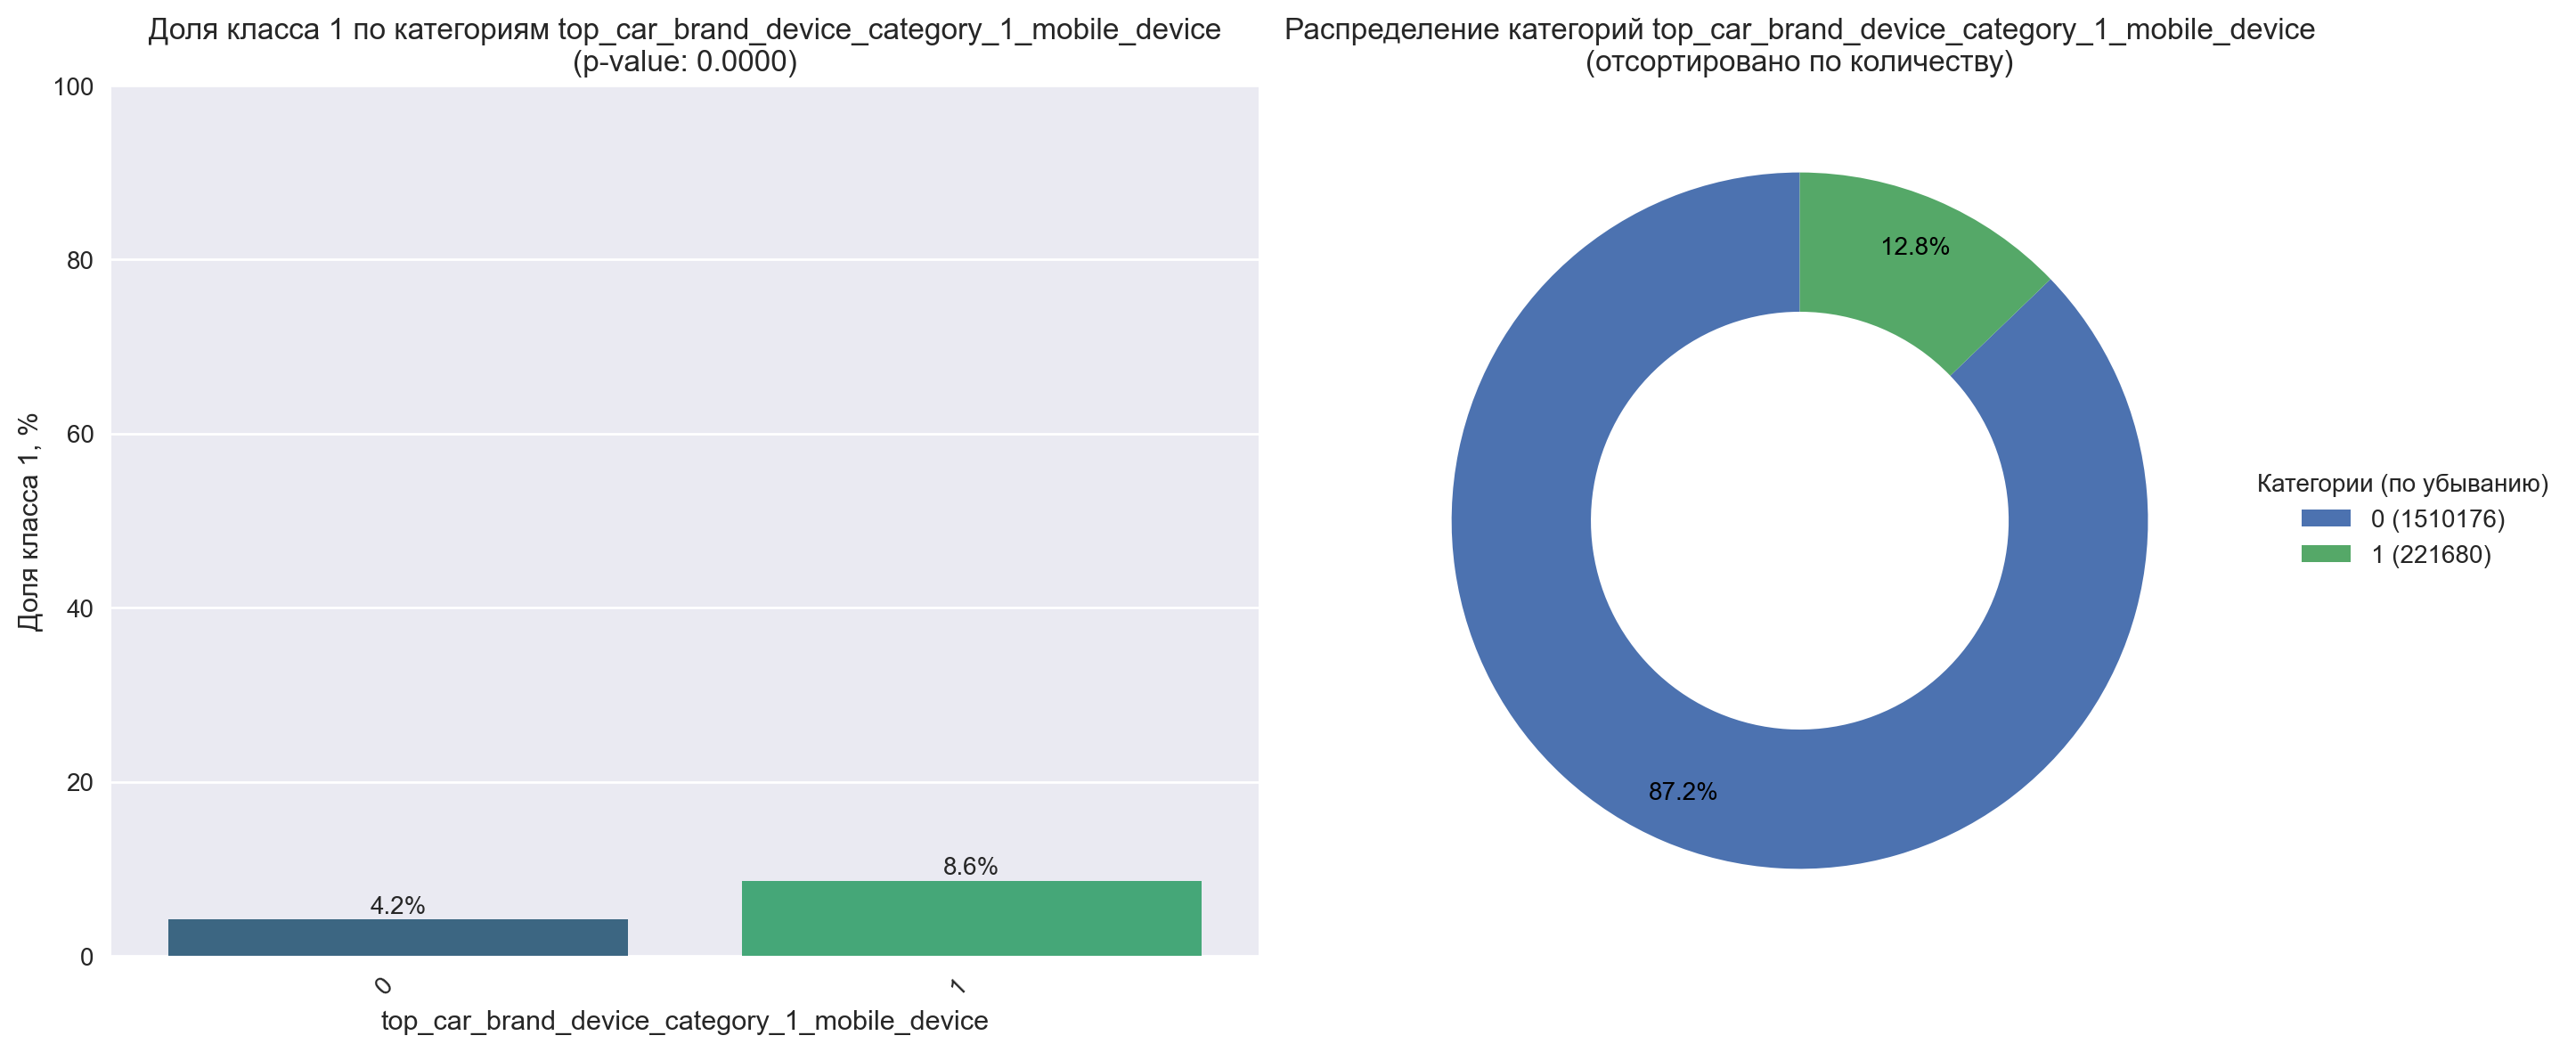

In [63]:
report = analyze_categorical_feature(df, 'top_car_brand_device_category_1_mobile_device', 'target')

Четко видно, что при значении 1 данного нового признака, доля класса 1 достгает 8.6%, объем данной выборки более 12%.

## Избавляемся от выбросов

In [64]:
def handle_lognormal_outliers(df, column, threshold=3, verbose=True):
    """
    Функция обрабатывает выбросы в логнормально распределенных данных:
    1. Логарифмирует данные 
    2. Вычисляет z-оценки для логарифмированных значений
    3. Заменяет выбросы на медиану в исходном масштабе
    
    Параметры:
    - df: DataFrame
    - column: имя столбца
    - threshold: порог для z-оценки (по умолчанию 3)
    - verbose: выводить ли информацию
    """
    # Логарифмируем данные (используем log1p для обработки нулей)
    log_data = np.log1p(df[column])
    
    # Вычисляем z-оценки для логарифмированных данных
    z_scores = np.abs(stats.zscore(log_data))
    outliers = z_scores > threshold
    
    # Вычисляем медиану в исходном масштабе
    median_val = df[column].median()
    
    if verbose:
        n_outliers = outliers.sum()
        print(f"Признак '{column}':")
        print(f" - Всего выбросов: {n_outliers} ({n_outliers/len(df)*100:.2f}%)")
        print(f" - Медианное значение: {median_val:.2f}")
        print(f" - Максимальное значение до обработки: {df[column].max():.2f}")
    
    # Заменяем выбросы на медиану
    df[column] = np.where(outliers, median_val, df[column])
    
    if verbose:
        print(f" - Максимальное значение после обработки: {df[column].max():.2f}\n")
    
    return df

In [65]:
# обрабатываем признаки
print("Анализ выбросов:")
df = handle_lognormal_outliers(df, 'event_categories_number')
df = handle_lognormal_outliers(df, 'hit_number_median')

Анализ выбросов:
Признак 'event_categories_number':
 - Всего выбросов: 2461 (0.14%)
 - Медианное значение: 4.00
 - Максимальное значение до обработки: 768.00
 - Максимальное значение после обработки: 115.00

Признак 'hit_number_median':
 - Всего выбросов: 6587 (0.38%)
 - Медианное значение: 5.50
 - Максимальное значение до обработки: 496.00
 - Максимальное значение после обработки: 71.00



## Матрица корреляций непрерывных числовых признаков и таргета

Так как признаки непрерывные числовые, то можно использовать корреляцию Pearson. Но учитывая то, что таргет по сути категориальный признак, то добавим еще корреляцию Spearman и Kendall.

In [66]:
# непрерывные числовые признаки + target
num_cols = ['event_categories_number','hit_number_median','target']

# список с методами корреляции
methods = ["pearson", "spearman", "kendall"]

# выводим корреляцию по каждому методу
for method in methods:
    print(f"Корреляция *** {method} ***")
    corr = df[num_cols].corr(method=method)
    display(corr.style.background_gradient(cmap="coolwarm"))

Корреляция *** pearson ***


Корреляция *** spearman ***


Корреляция *** kendall ***


**Выводы:**
- наиболее коррелирующий с таргетом признак - `event_categories_number`, хотя связь между этими признаками можно считать слабой или очень слабой (< 0.3). 
- однако признаки `event_categories_number` и `hit_number_median` коррелируют между собой сильно - сильная связь, как мы и предполагали выше.

# Сохранение датасета

In [67]:
df.to_csv('data/dataset_for_ml.csv', index=False)

# Выводы:
- мы работаем с выраженным дисбалансом классов: доля класса 0 = 95.26%, доля класса 1 (целевое действие) = 4.74%
- были подробно обработаны и проанализированы числовые и категориальные признаки, удалены признаки не влияющие на таргет
- обработаны выбросы (замена медианой признака)
- было обнаружено, что:
    - чем выше по счету визит на сайт, тем выше доля целевых действий на сайте, хотя в 75% случаях случаев это 1-й визит 
    - это же справедливо для порядкового номера событий - чем он выше, тем выше вероятность целевого действия
    - чем больше действий в различных категориях осуществляет пользователь, тем выше доля целевых действий
    - данные представлены за период с 19 мая 2021 года по 31 декабря 2021 года
    - чаще пользователи заходят на сайт в дневное время, реже ночью. Днем также больше совершается целевых действий.
    - наиболее частый тип привлечения пользователя - *baner*, однако доля целевых действий максимальна при *referral*
    - только в 17% наблюдений мы имеем информацию о том, страницы с какими марками авто проматривали пользователи. В ТОП-3 по количеству просмотров входят Skoda, Mercedes-Benz и Lada-Vaz. В ТОП-3 по доле целевых действий входят Lada-Vaz, Hyundai и Kia. 
    - чаще пользователи заходят на сайт с мобильных устройств и только в 20% случаев с десктопных, при этом доля целевых действий пользователей выше, если он заходит с десктопа.
    - чаще пользователи заходят с устройств Apple, при этом доля целевых действий среди них минимально, в отличие от пользователей Samsung и Huawei
    - чаще используются браузеры Chrome, Safari, YandexBrowser, доля целевых действий выше при использовани Firefox, Edge, YandexBrowser, Chrome.
    - выяснено, что площадь экрана устройства и его соотношение сторон не влияют на таргет
    - в подавляющем большинстве пользователи находятся на территории РФ, они же чаще совершают целевое действие, в отличие от иностранцев
    - большинство пользователей из Москвы и Санкт-Петербурга, однако они реже остальных совершают целевое действие
- на основе попарных значений категориальных признаков были созданы новые признаки, в которых доля целевых действий более 7% и объем данной выборки составляет более 10% от объема датасета
- итоговый проанализированный и обработанный датасет сохранен